# Predicting House Prices in Brooklyn

#### This is a dataset of house sale prices for Brooklyn, New York. It includes both Residential and Commercial units sold between 2003 and 2017. The dataset provides some features that the units have and the price at which they were sold.

## Loading the Dataset

In [598]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.3.0-posix-seh-rt_v5-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [599]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
from scipy.stats import skew
from pandas import datetime
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import make_scorer, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, RandomForestClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder


warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline


In [600]:
#Load the Brooklyn Dataset

data = pd.read_csv("brooklyn_sales_map.csv")

# Data Exploration

In [601]:
# Shows how many rows and columns in dataset

print('The Brooklyn dataset has {0} rows and {1} columns'.format(data.shape[0], data.shape[1]))

The Brooklyn dataset has 390883 rows and 110 columns


In [602]:
# Check for How much data is missing from the entire Brooklyn Dataset

data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:110]
missing_data = pd.DataFrame({"Missing Data": data_na})
missing_data.head(30)

Missing Data
easement            100.000000
ZoneDist4            99.999233
SPDist3              99.998977
SPDist2              99.993860
Overlay2             99.987720
Landmark             99.967765
ZoneDist3            99.952415
EDesigNum            99.090777
LtdHeight            98.689889
ZMCode               98.436361
FIRM07_FLA           97.786294
ZoneDist2            96.133114
APPDate              95.072950
HistDist             94.966780
PFIRM15_FL           92.894805
SPDist1              90.917998
Overlay1             89.275307
OwnerType            86.314575
Ext                  83.081127
apartment_number     78.096771
CB2010               22.607276
LandUse              22.557133
SanitSub             22.495478
SanitDistr           22.422311
SanitBoro            22.422311
CT2010               22.371656
FireComp             22.360399
OwnerName            22.323560
SchoolDist           22.307187
Address              22.302837

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x0000024205722710>>
Traceback (most recent call last):
  File "C:\Users\vicok\Anaconda3\lib\site-packages\xgboost-0.71-py3.6.egg\xgboost\core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


Text(0.5,1,'Percent missing data by feature')

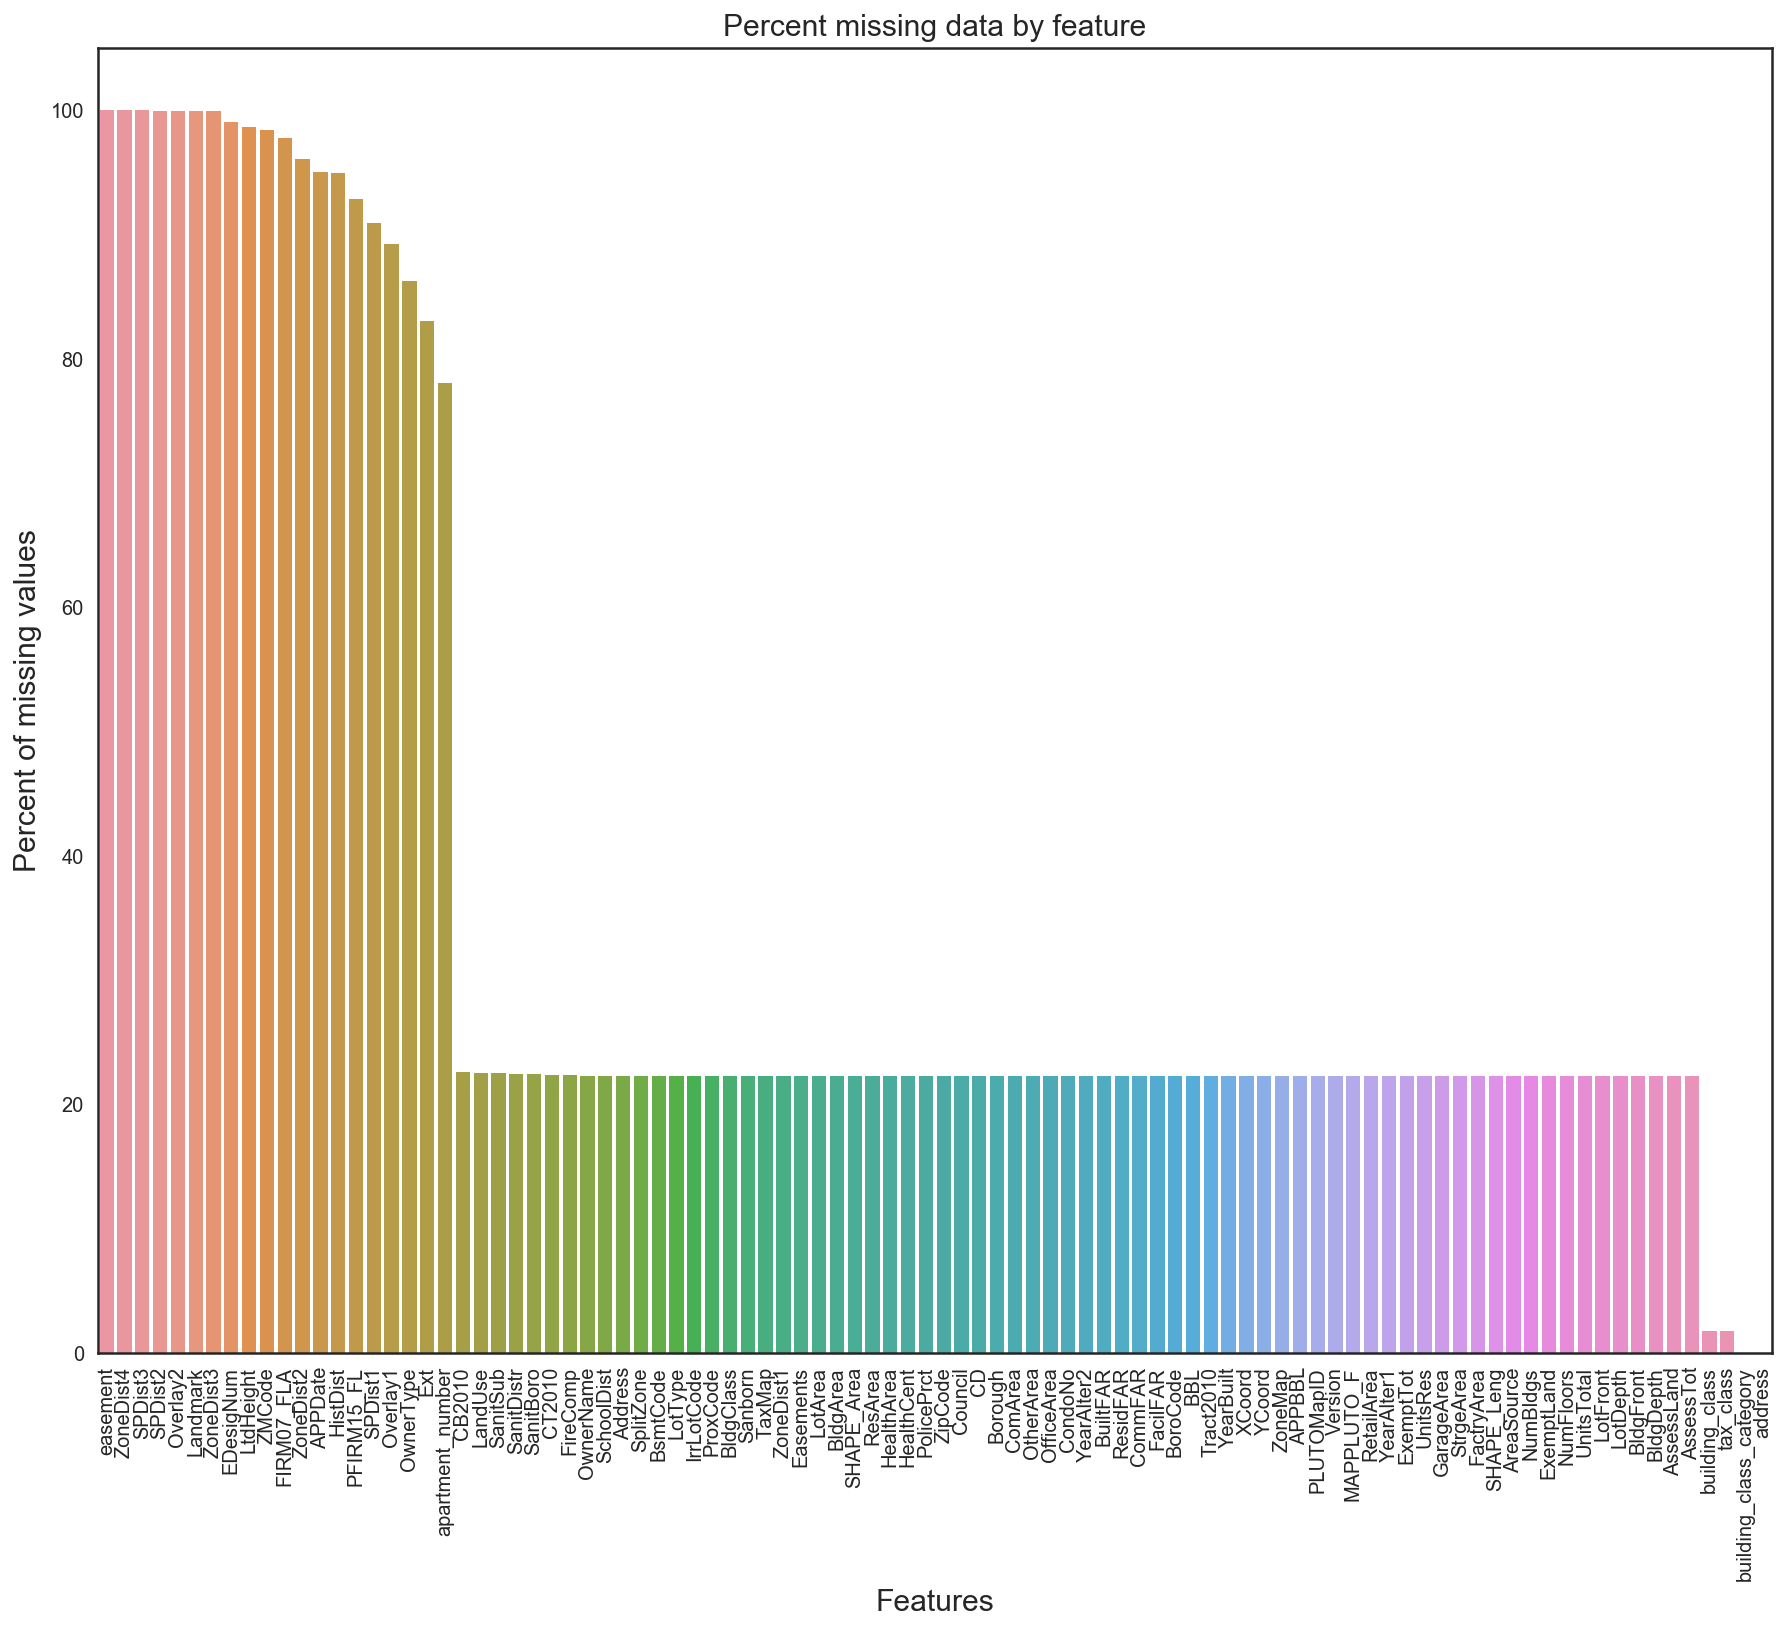

In [603]:
# We notice that a lot of data is missing; Here is a visual of missing data

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=data_na.index, y=data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)


In [604]:
# Here is a Statisical Description of the Dataset

print("A Statistical Description of the Dataset: \n", data.describe())

A Statistical Description of the Dataset: 
         borough          block            lot  easement       zip_code  \
count  390883.0  390883.000000  390883.000000       0.0  390883.000000   
mean        3.0    4275.651169     272.509986       NaN   11208.429087   
std         0.0    2642.765332     484.658837       NaN     361.207836   
min         3.0       1.000000       1.000000       NaN       0.000000   
25%         3.0    1786.000000      21.000000       NaN   11209.000000   
50%         3.0    4305.000000      45.000000       NaN   11219.000000   
75%         3.0    6585.000000      94.000000       NaN   11230.000000   
max         3.0    8955.000000    9133.000000       NaN   33803.000000   

       residential_units  commercial_units    total_units     land_sqft  \
count      390883.000000     390883.000000  390883.000000  3.908830e+05   
mean            2.486138          0.174142       2.673227  2.368464e+03   
std            48.200178          1.653362      48.233343  2.509

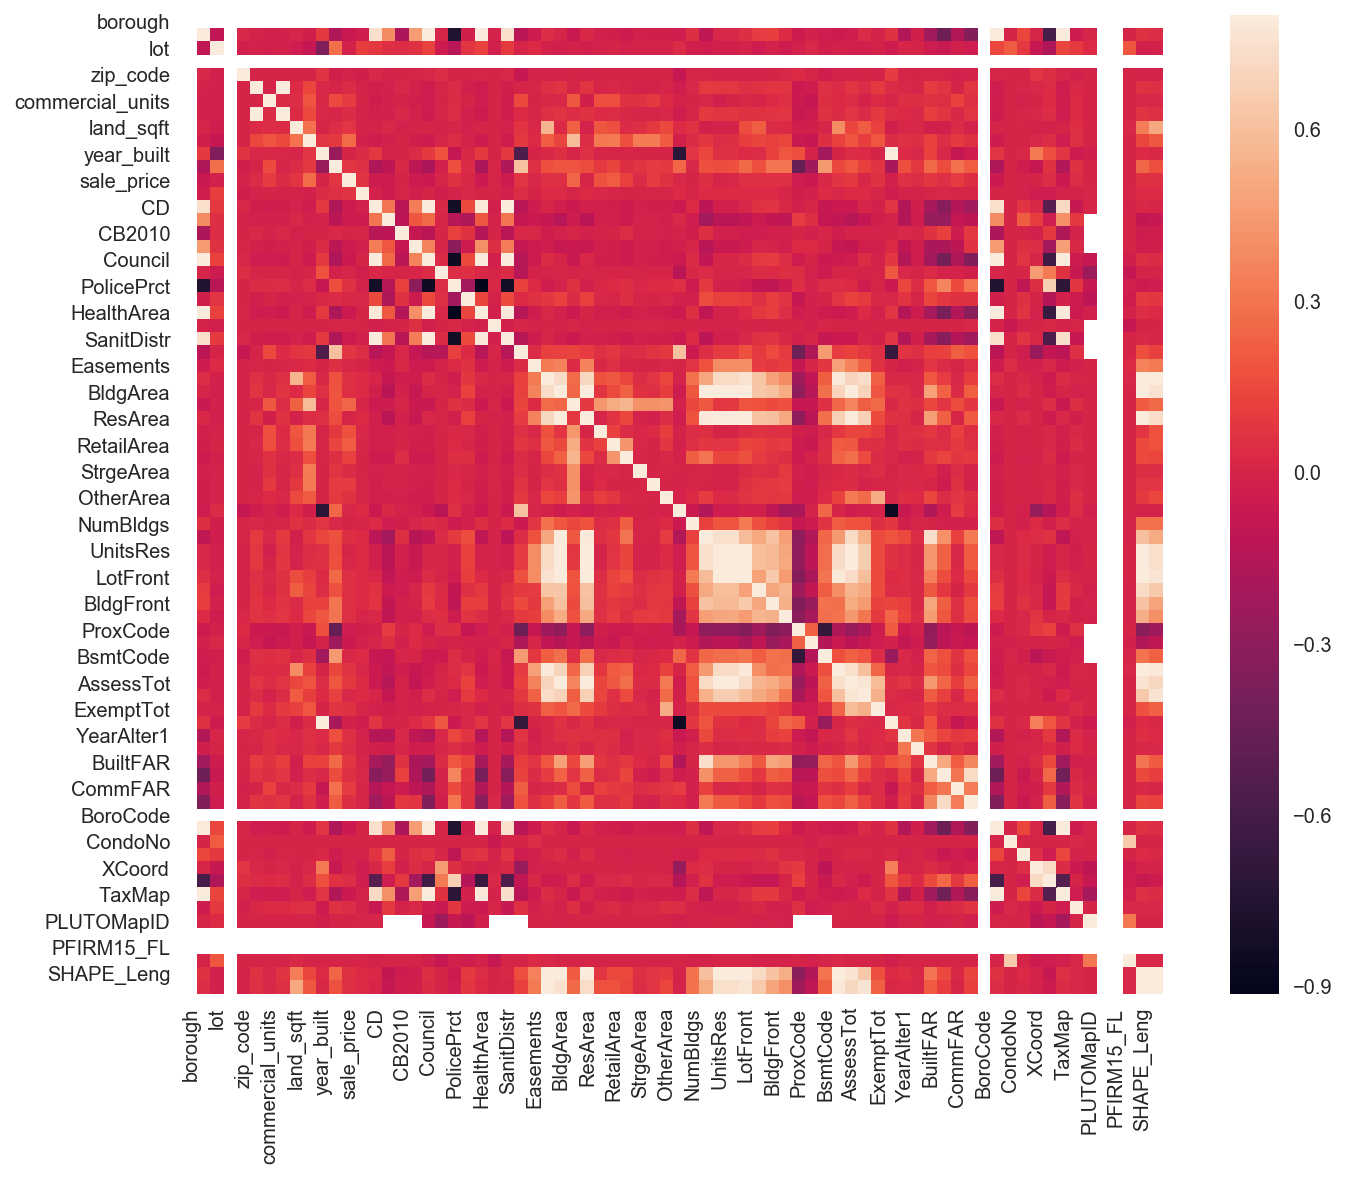

In [605]:
# Correlation matrix heatmap of the entire dataset

corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

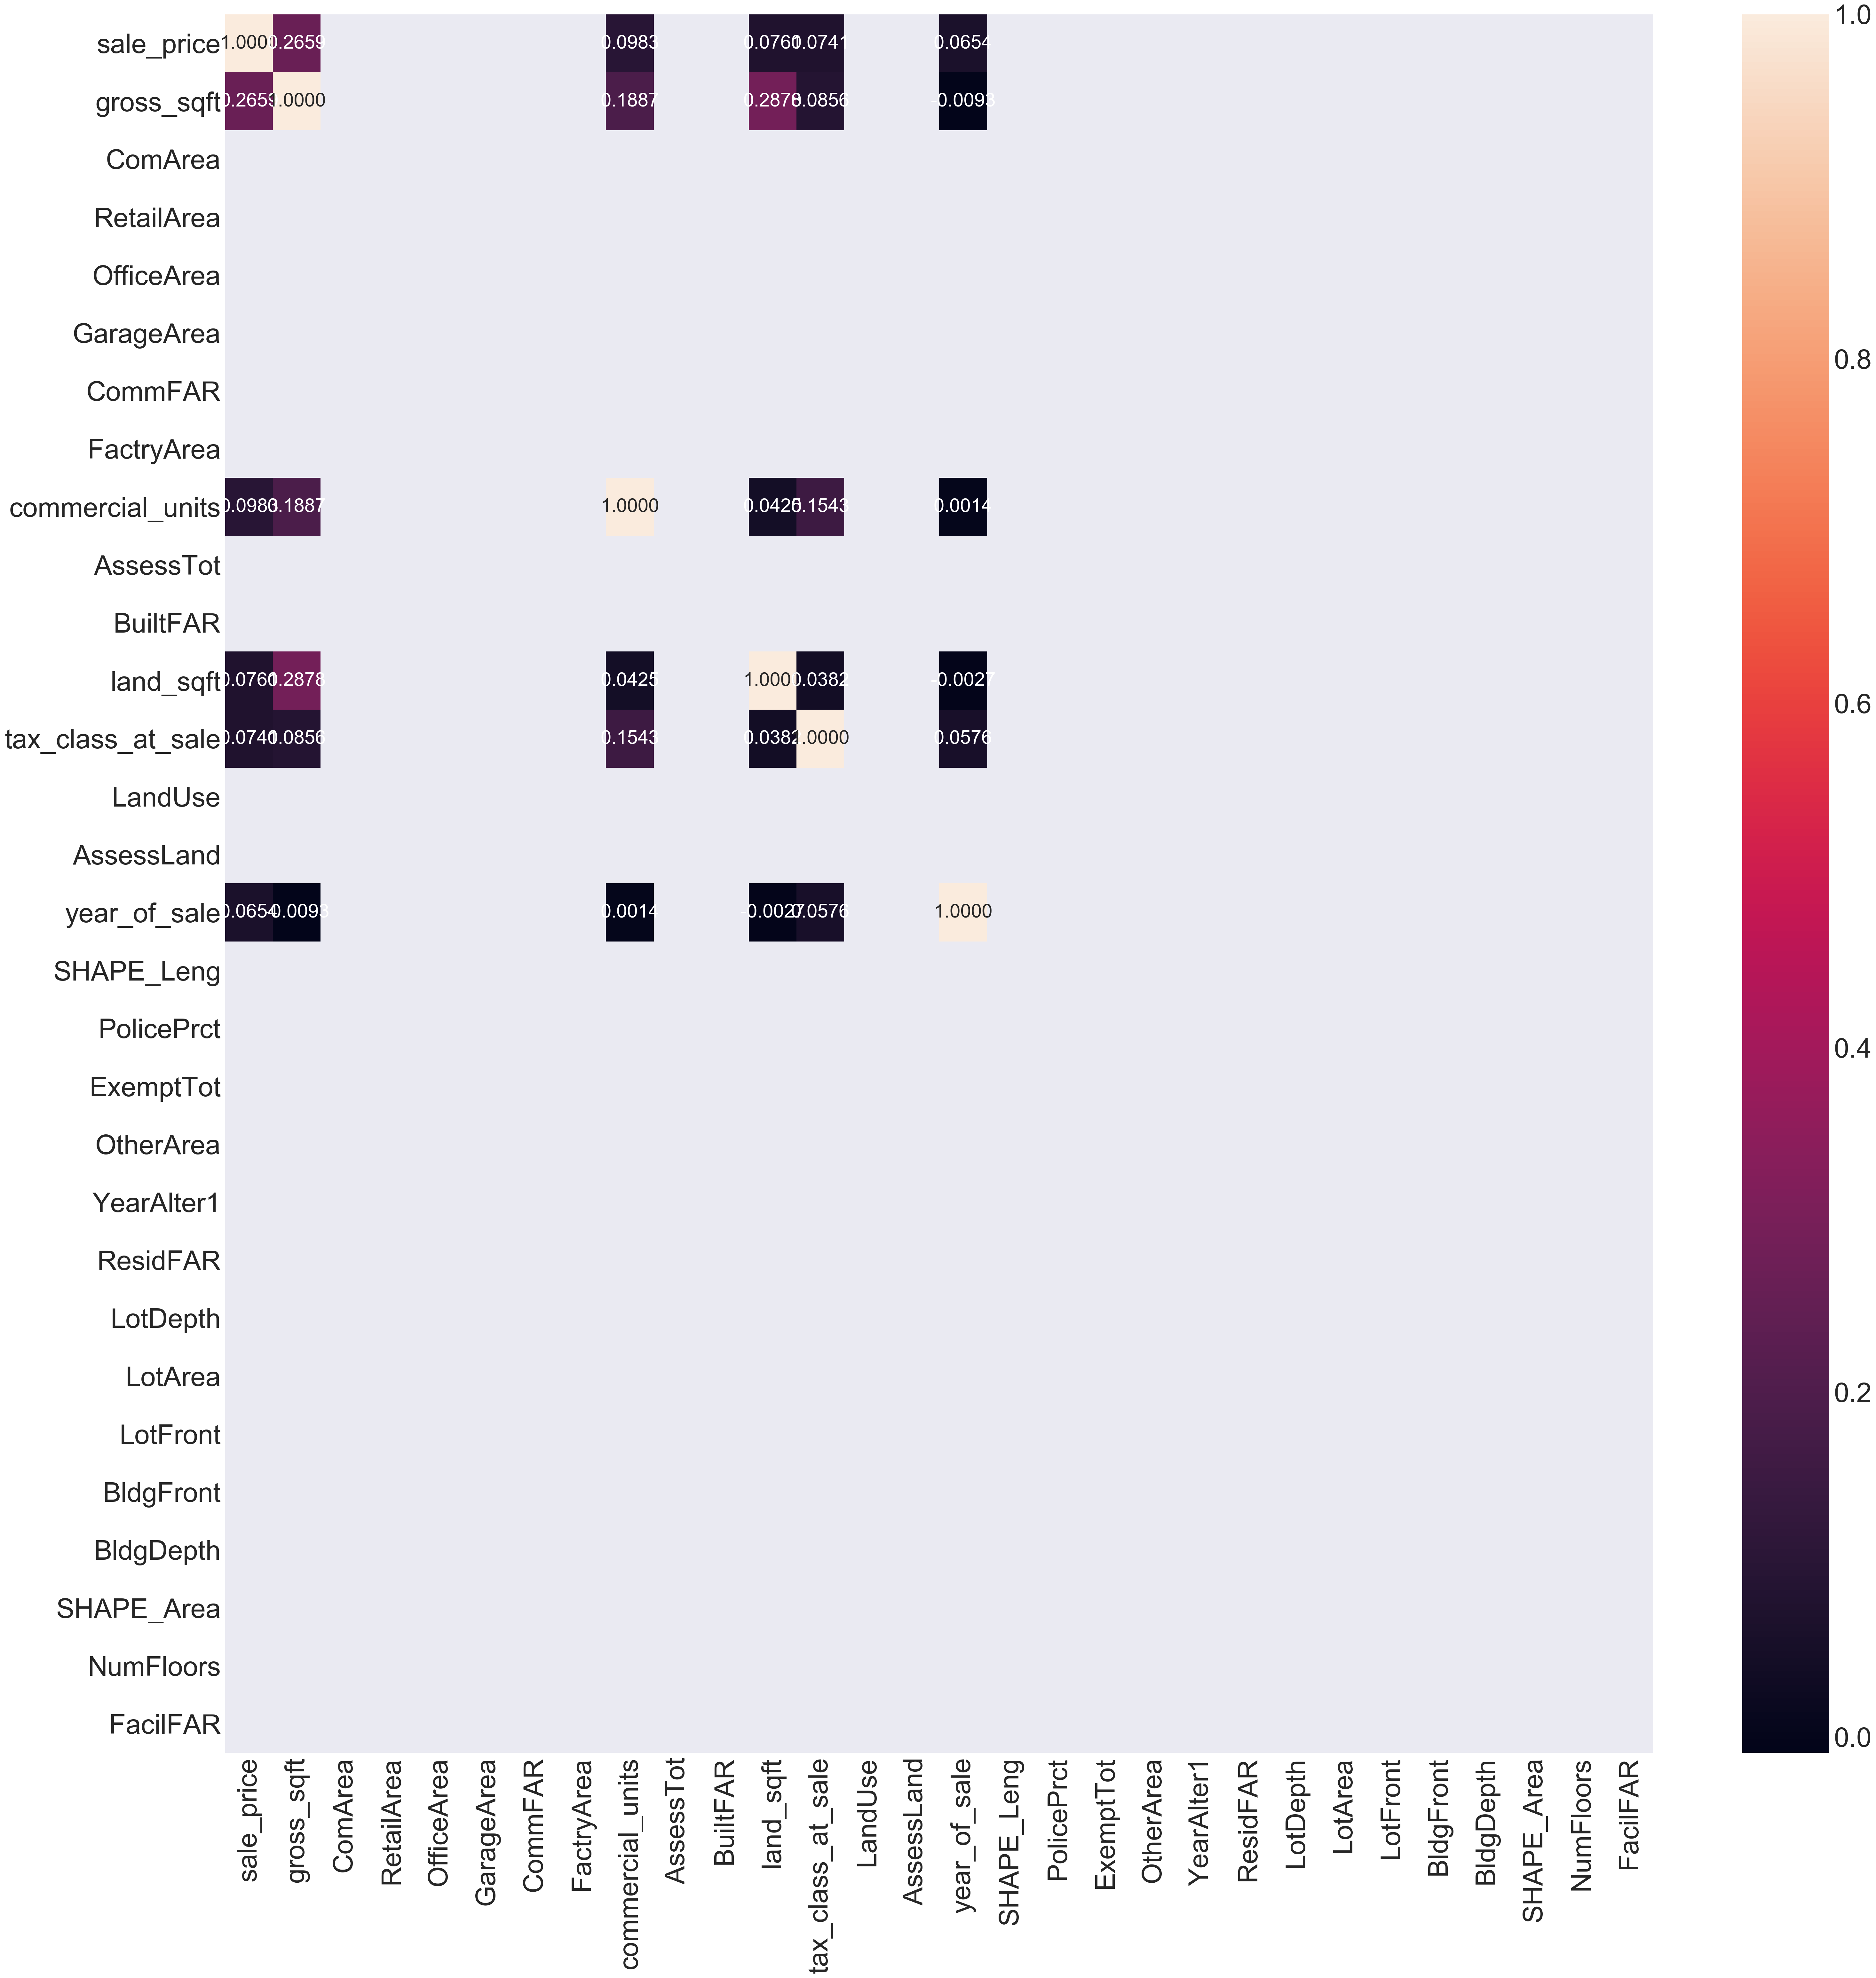

In [606]:
# Top 30 features Heatmap for the entire dataset
plt.figure(figsize=(50,50))
k = 30 #number of variables for heatmap
cols = corrmat.nlargest(k, 'sale_price')['sale_price'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=4.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=False, fmt='.4f', annot_kws={'size': 30}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Preprocessing the Dataset both Manually

In [607]:
# Here all obvious outliers are removed to reduce dataset


data  = data[data.sale_price >= 100000]
data = data[data.sale_price <= 200000000]
data = data[data.year_of_sale > 2009]
data = data[data.year_built > 0]
data = data[data.zip_code > 0]

# Removing outliers manually
data = data.drop(data[(data['gross_sqft']>200000) & (data['sale_price']<100000000)].index).reset_index(drop=True)
data = data.drop(data[(data['land_sqft']>150000) & (data['sale_price']<100000000)].index).reset_index(drop=True)
data = data.drop(data[(data['year_built']<1800) & (data['sale_price']<100000000)].index).reset_index(drop=True)
data = data.drop(data[(data['total_units']>150) & (data['sale_price']<100000000)].index).reset_index(drop=True)
data = data.drop(data[(data['residential_units']>150) & (data['sale_price']<100000000)].index).reset_index(drop=True)
data = data.drop(data[(data['commercial_units']>15) & (data['sale_price']<100000000)].index).reset_index(drop=True)
data = data.drop(data[(data['GarageArea']>30000) & (data['sale_price']<100000000)].index).reset_index(drop=True)
data = data.drop(data[(data['RetailArea']>50000) & (data['sale_price']<100000000)].index).reset_index(drop=True)
data = data.drop(data[(data['OfficeArea']>50000) & (data['sale_price']<100000000)].index).reset_index(drop=True)
data = data.drop(data[(data['UnitsRes']>400) & (data['sale_price']<100000000)].index).reset_index(drop=True)
data = data.drop(data[(data['NumFloors']>40) & (data['sale_price']<100000000)].index).reset_index(drop=True)
#data = data.drop(data[(data['YearAlter1'] == 0) & (data['sale_price']<100000000)].index).reset_index(drop=True)


data_cols = list(data.columns.values)
want = [ 'building_class_category', 'block', 'gross_sqft', 'zip_code', 'land_sqft', 'year_built', 'sale_price', 'year_of_sale',
       'total_units', 'residential_units', 'commercial_units', 'PolicePrct', 'HealthCent', 'LandUse', 'GarageArea', 'RetailArea',
       'OfficeArea', 'UnitsRes', 'NumFloors', 'SchoolDist', 'ComArea', 'YearAlter1', 'CommFar', 'AssessLand', 'FactryArea', 'BldgFront',
       'LotArea']

for i in data_cols:
    if i not in want:
        data = data.drop(i, axis=1)

In [608]:
data.shape

(99032, 26)

In [609]:
# All the Years where the feature YearAlter1 == 0 are changed to the value of the year when the buliding was built

l1 = len(data.YearAlter1)

for i in range(0, l1, 1):
    if data.YearAlter1.values[i] == 0:
        data.YearAlter1.values[i] = data.year_built.values[i]
    

In [610]:
data.shape

(99032, 26)

In [611]:
# Here all NaN values are removed

data = data.dropna(axis=0, how='any')
print('New Data Shape: ', data.shape)

New Data Shape:  (78431, 26)


In [612]:
# Removing Remaining Outliers Automatically

from scipy import stats

data = data[(np.abs(stats.zscore(df)) < 1).all(axis=1)]

print('New Data Shape: ', data.shape)

New Data Shape:  (74683, 26)


In [613]:
#convert nominal and ordinal features into category

data['LandUse'] = data['LandUse'].astype('category')
data['zip_code'] = data['zip_code'].astype('category')


In [614]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74683 entries, 33 to 99031
Data columns (total 26 columns):
building_class_category    74683 non-null object
block                      74683 non-null int64
zip_code                   74683 non-null category
residential_units          74683 non-null int64
commercial_units           74683 non-null int64
total_units                74683 non-null int64
land_sqft                  74683 non-null float64
gross_sqft                 74683 non-null float64
year_built                 74683 non-null int64
sale_price                 74683 non-null float64
year_of_sale               74683 non-null int64
SchoolDist                 74683 non-null float64
PolicePrct                 74683 non-null float64
HealthCent                 74683 non-null float64
LandUse                    74683 non-null category
LotArea                    74683 non-null float64
ComArea                    74683 non-null float64
OfficeArea                 74683 non-null float64
R

In [615]:
data.head()

building_class_category  block zip_code  residential_units  \
33      14  RENTALS - 4-10 UNIT   2352    11211                  3   
57               30  WAREHOUSES   2334    11249                  0   
123        21  OFFICE BUILDINGS    146    11201                  0   
126  31  COMMERCIAL VACANT LAND    165    11201                  1   
128         22  STORE BUILDINGS   2319    11249                  0   

     commercial_units  total_units  land_sqft  gross_sqft  year_built  \
33                  1            4     1000.0      4000.0        2005   
57                  4            4     3700.0      7475.0        1920   
123                 2            2     2598.0      6900.0        1920   
126                 0            1     2217.0         0.0        1920   
128                 1            1     3600.0      7200.0        2014   

     sale_price     ...      ComArea  OfficeArea  RetailArea  GarageArea  \
33   66000000.0     ...       1000.0         0.0      1000.0         0.0   
57   49000000.0     ...      35741.0         0.0     18191.0         0.0   
123  30000000.0     ...       5223.0         0.0      5223.0         0.0   
126  30000000.0     ...          0.0         0.0         0.0         0.0   
128  30000000.0     ...       7200.0         0.0      7200.0         0.0   

    FactryArea  NumFloors  UnitsRes  BldgFront  AssessLand  YearAlter1  
33         0.0        4.0       3.0       20.0     44497.0      2005.0  
57         0.0        3.0       0.0       83.0    429750.0      1957.0  
123        0.0       28.0      33.0        0.0     58500.0      1920.0  
126        0.0        0.0       0.0        0.0    339750.0      1920.0  
128        0.0        2.0       0.0       60.0    180000.0      2014.0  

[5 rows x 26 columns]

In [616]:
from sklearn.preprocessing import LabelEncoder, RobustScaler

In [617]:
# This shows which features are numerical and categorical

cat = len(data.select_dtypes(include=['object', 'category']).columns)
num = len(data.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')
print('\n')
categorical = list(data.select_dtypes(include=['object', 'category']).columns)
print('The Categorical Features Are:', categorical)
print('\n')
numerical = list(data.select_dtypes(include=['int64','float64']).columns)
print('The Numerical Features Are:', numerical)
      

Total Features:  3 categorical + 23 numerical = 26 features


The Categorical Features Are: ['building_class_category', 'zip_code', 'LandUse']


The Numerical Features Are: ['block', 'residential_units', 'commercial_units', 'total_units', 'land_sqft', 'gross_sqft', 'year_built', 'sale_price', 'year_of_sale', 'SchoolDist', 'PolicePrct', 'HealthCent', 'LotArea', 'ComArea', 'OfficeArea', 'RetailArea', 'GarageArea', 'FactryArea', 'NumFloors', 'UnitsRes', 'BldgFront', 'AssessLand', 'YearAlter1']


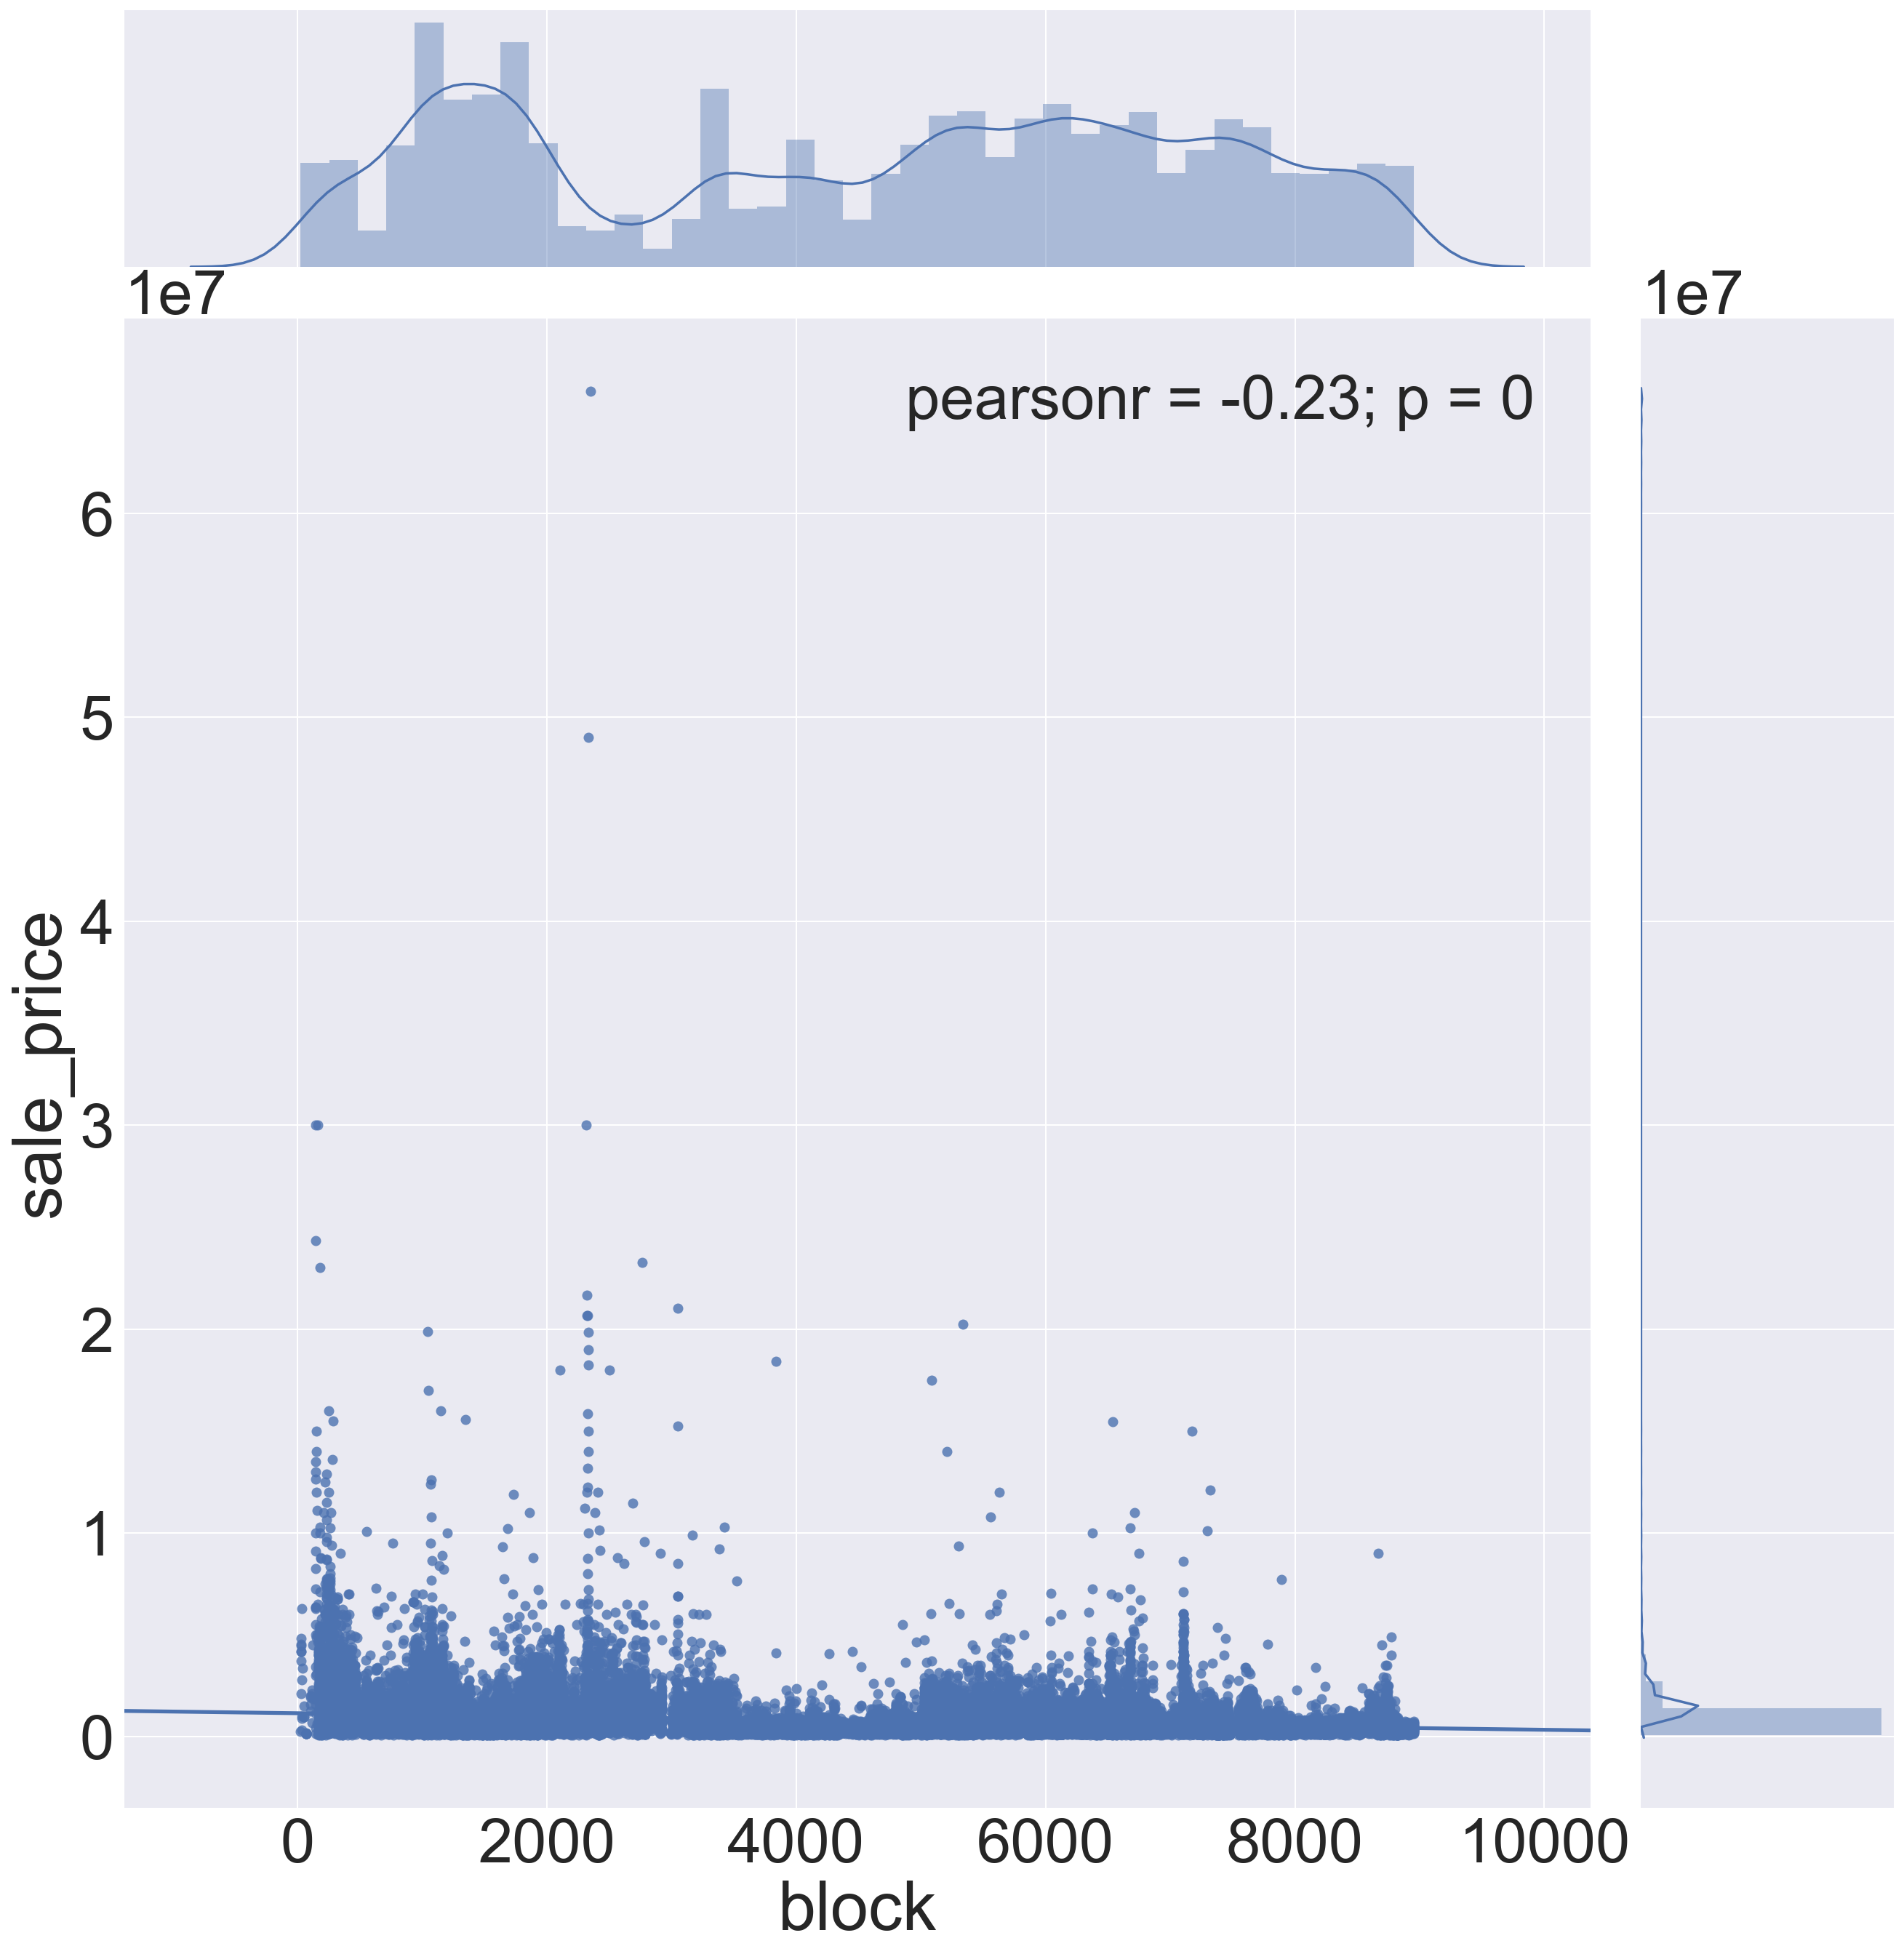

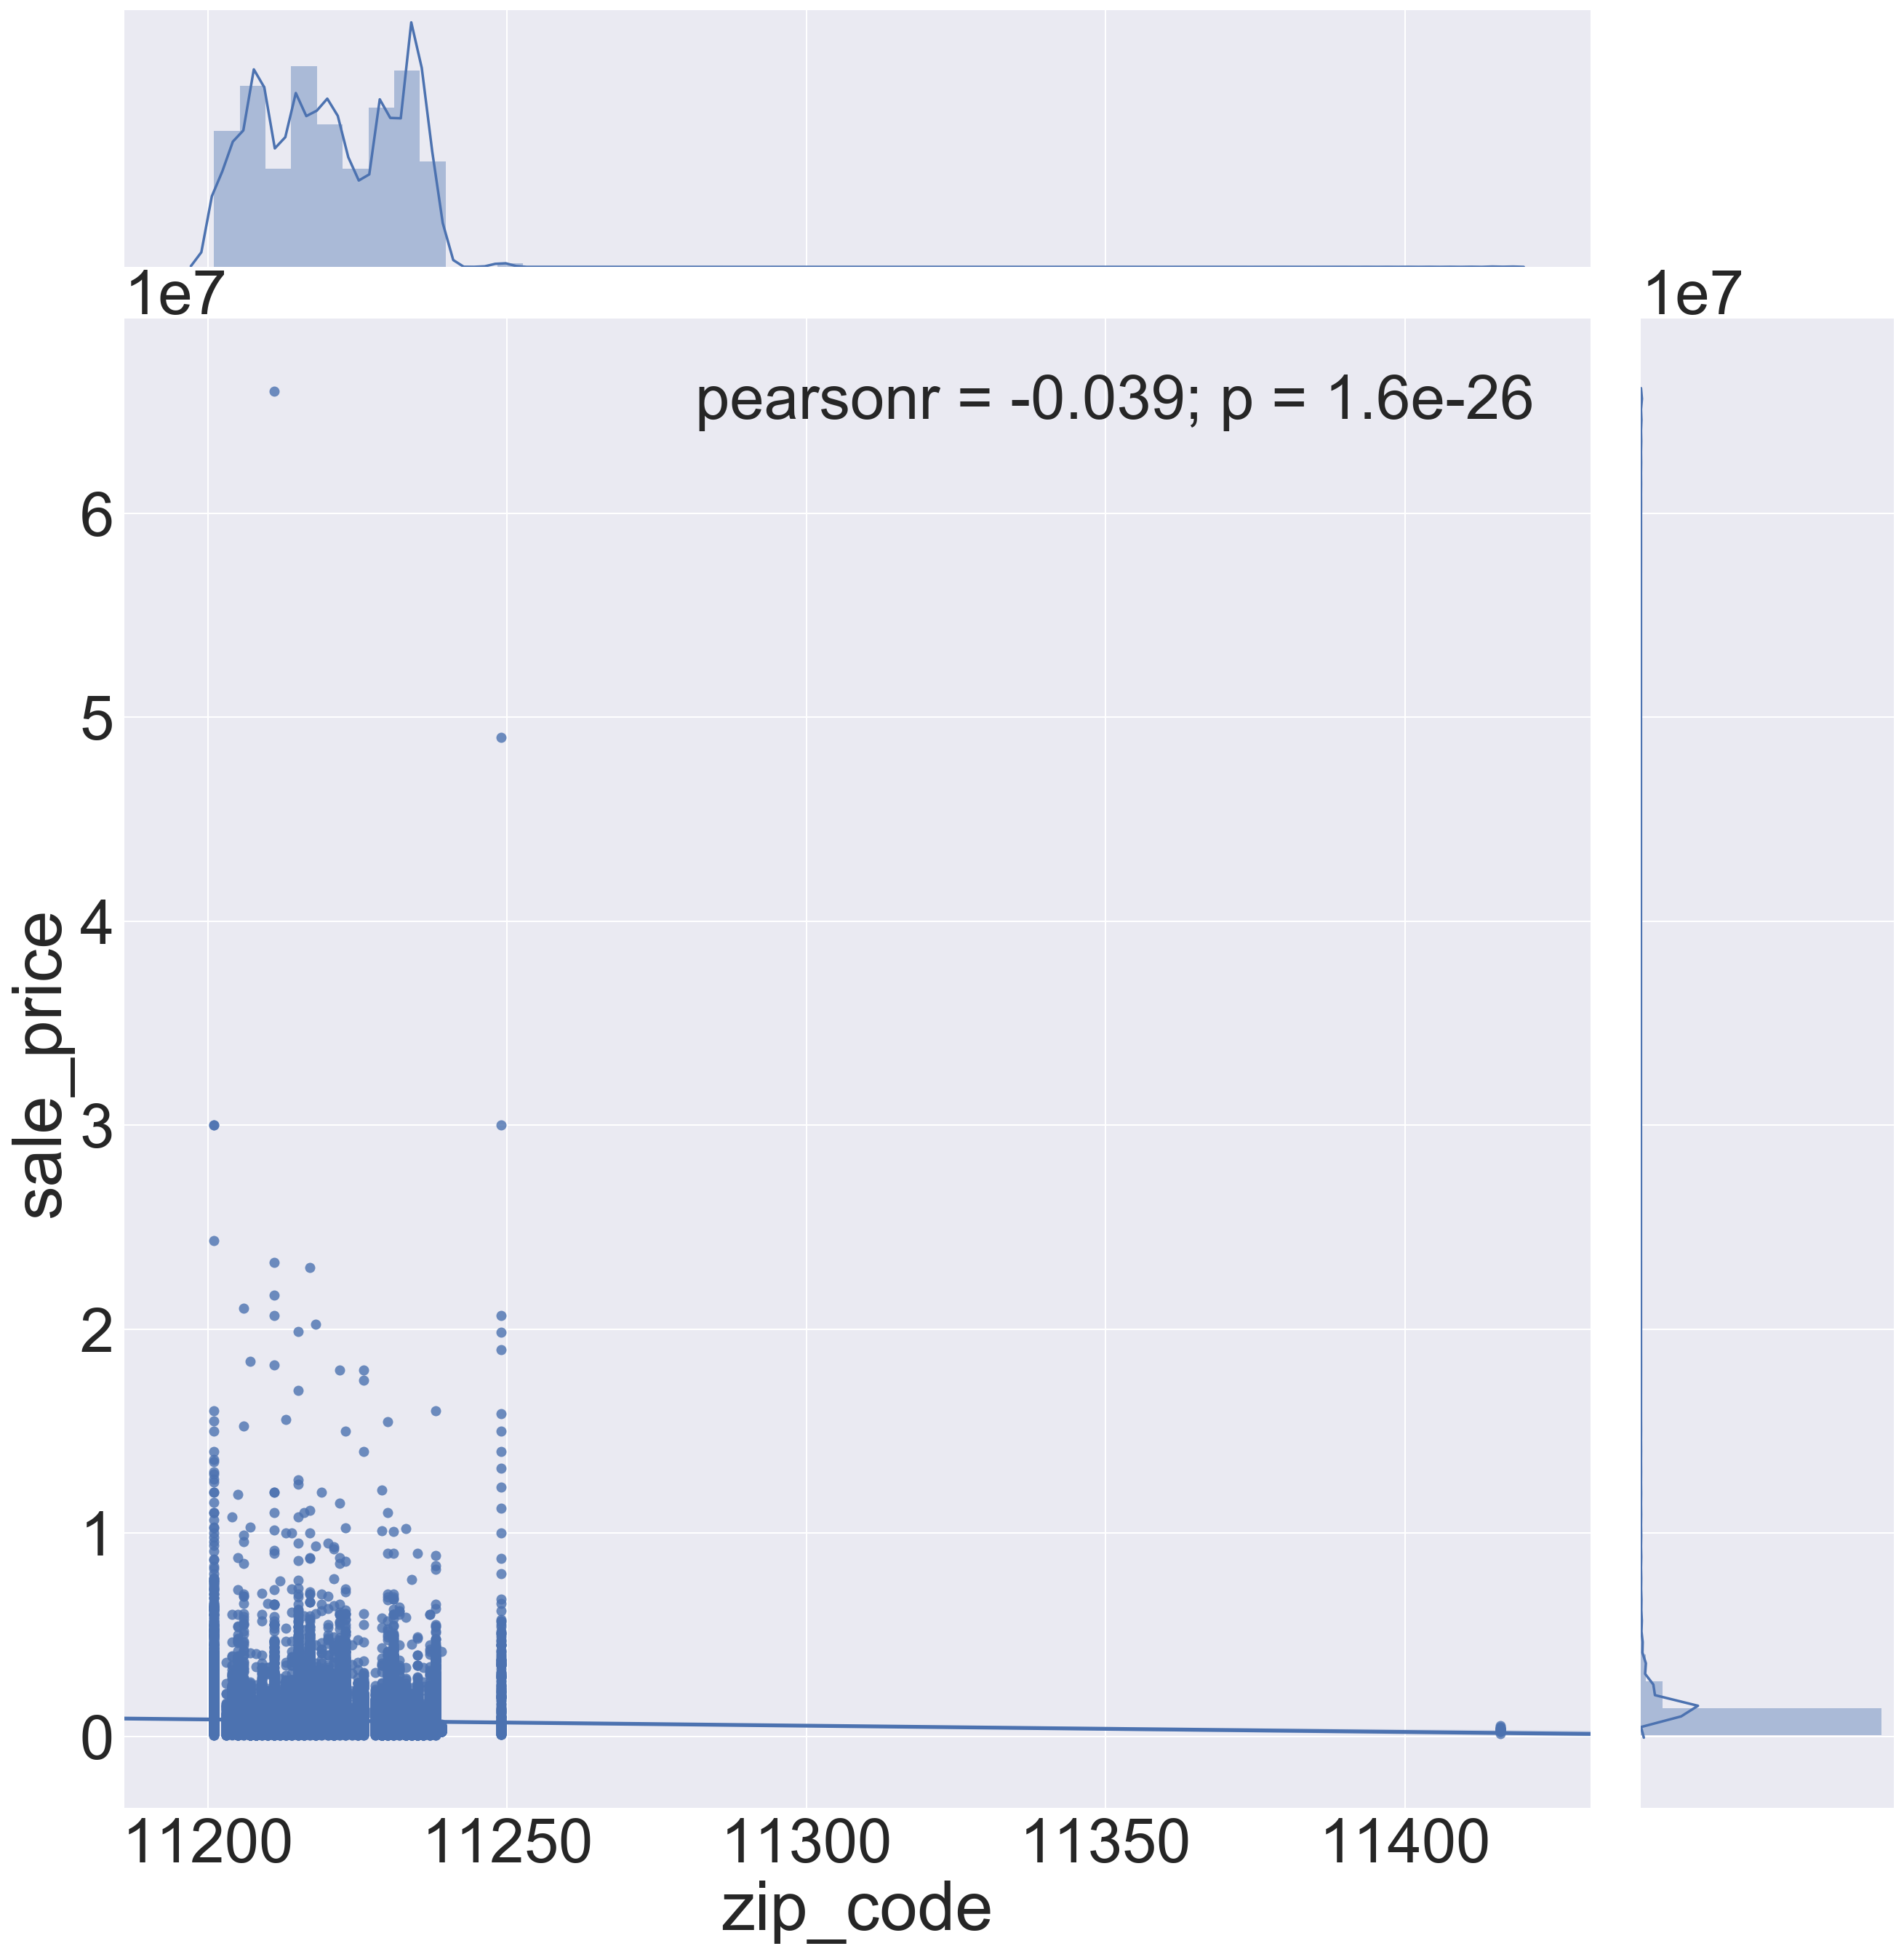

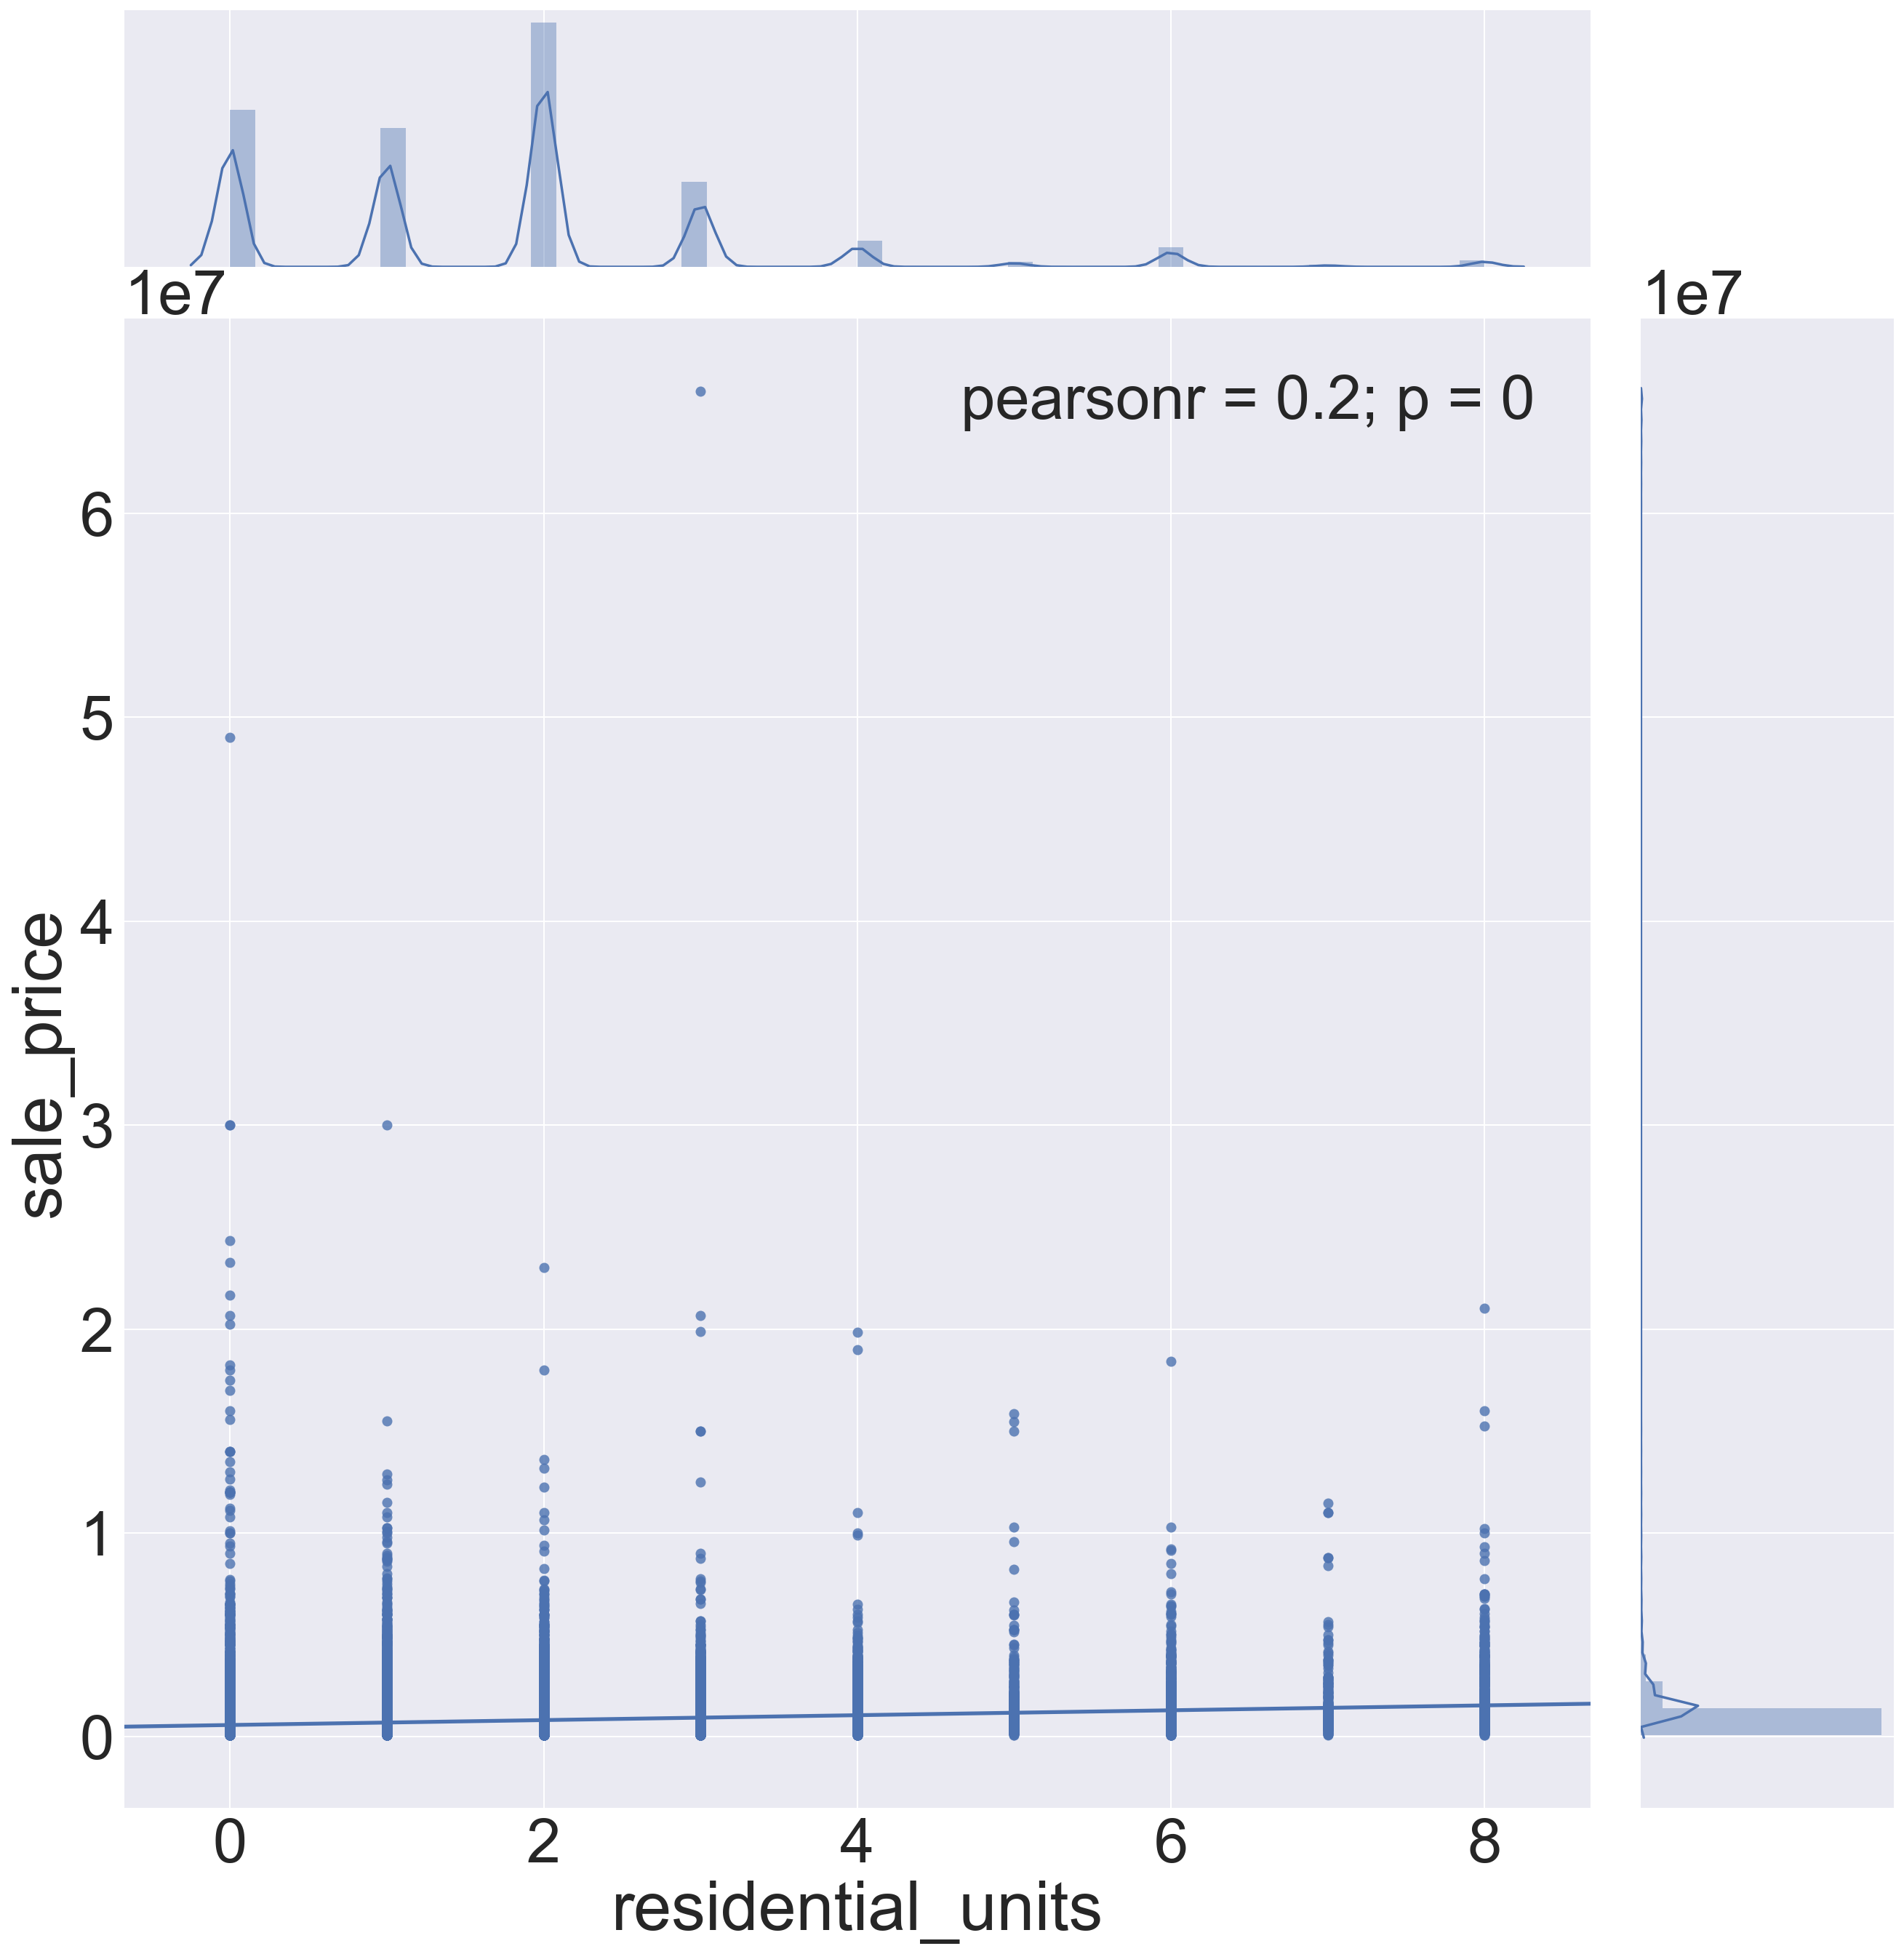

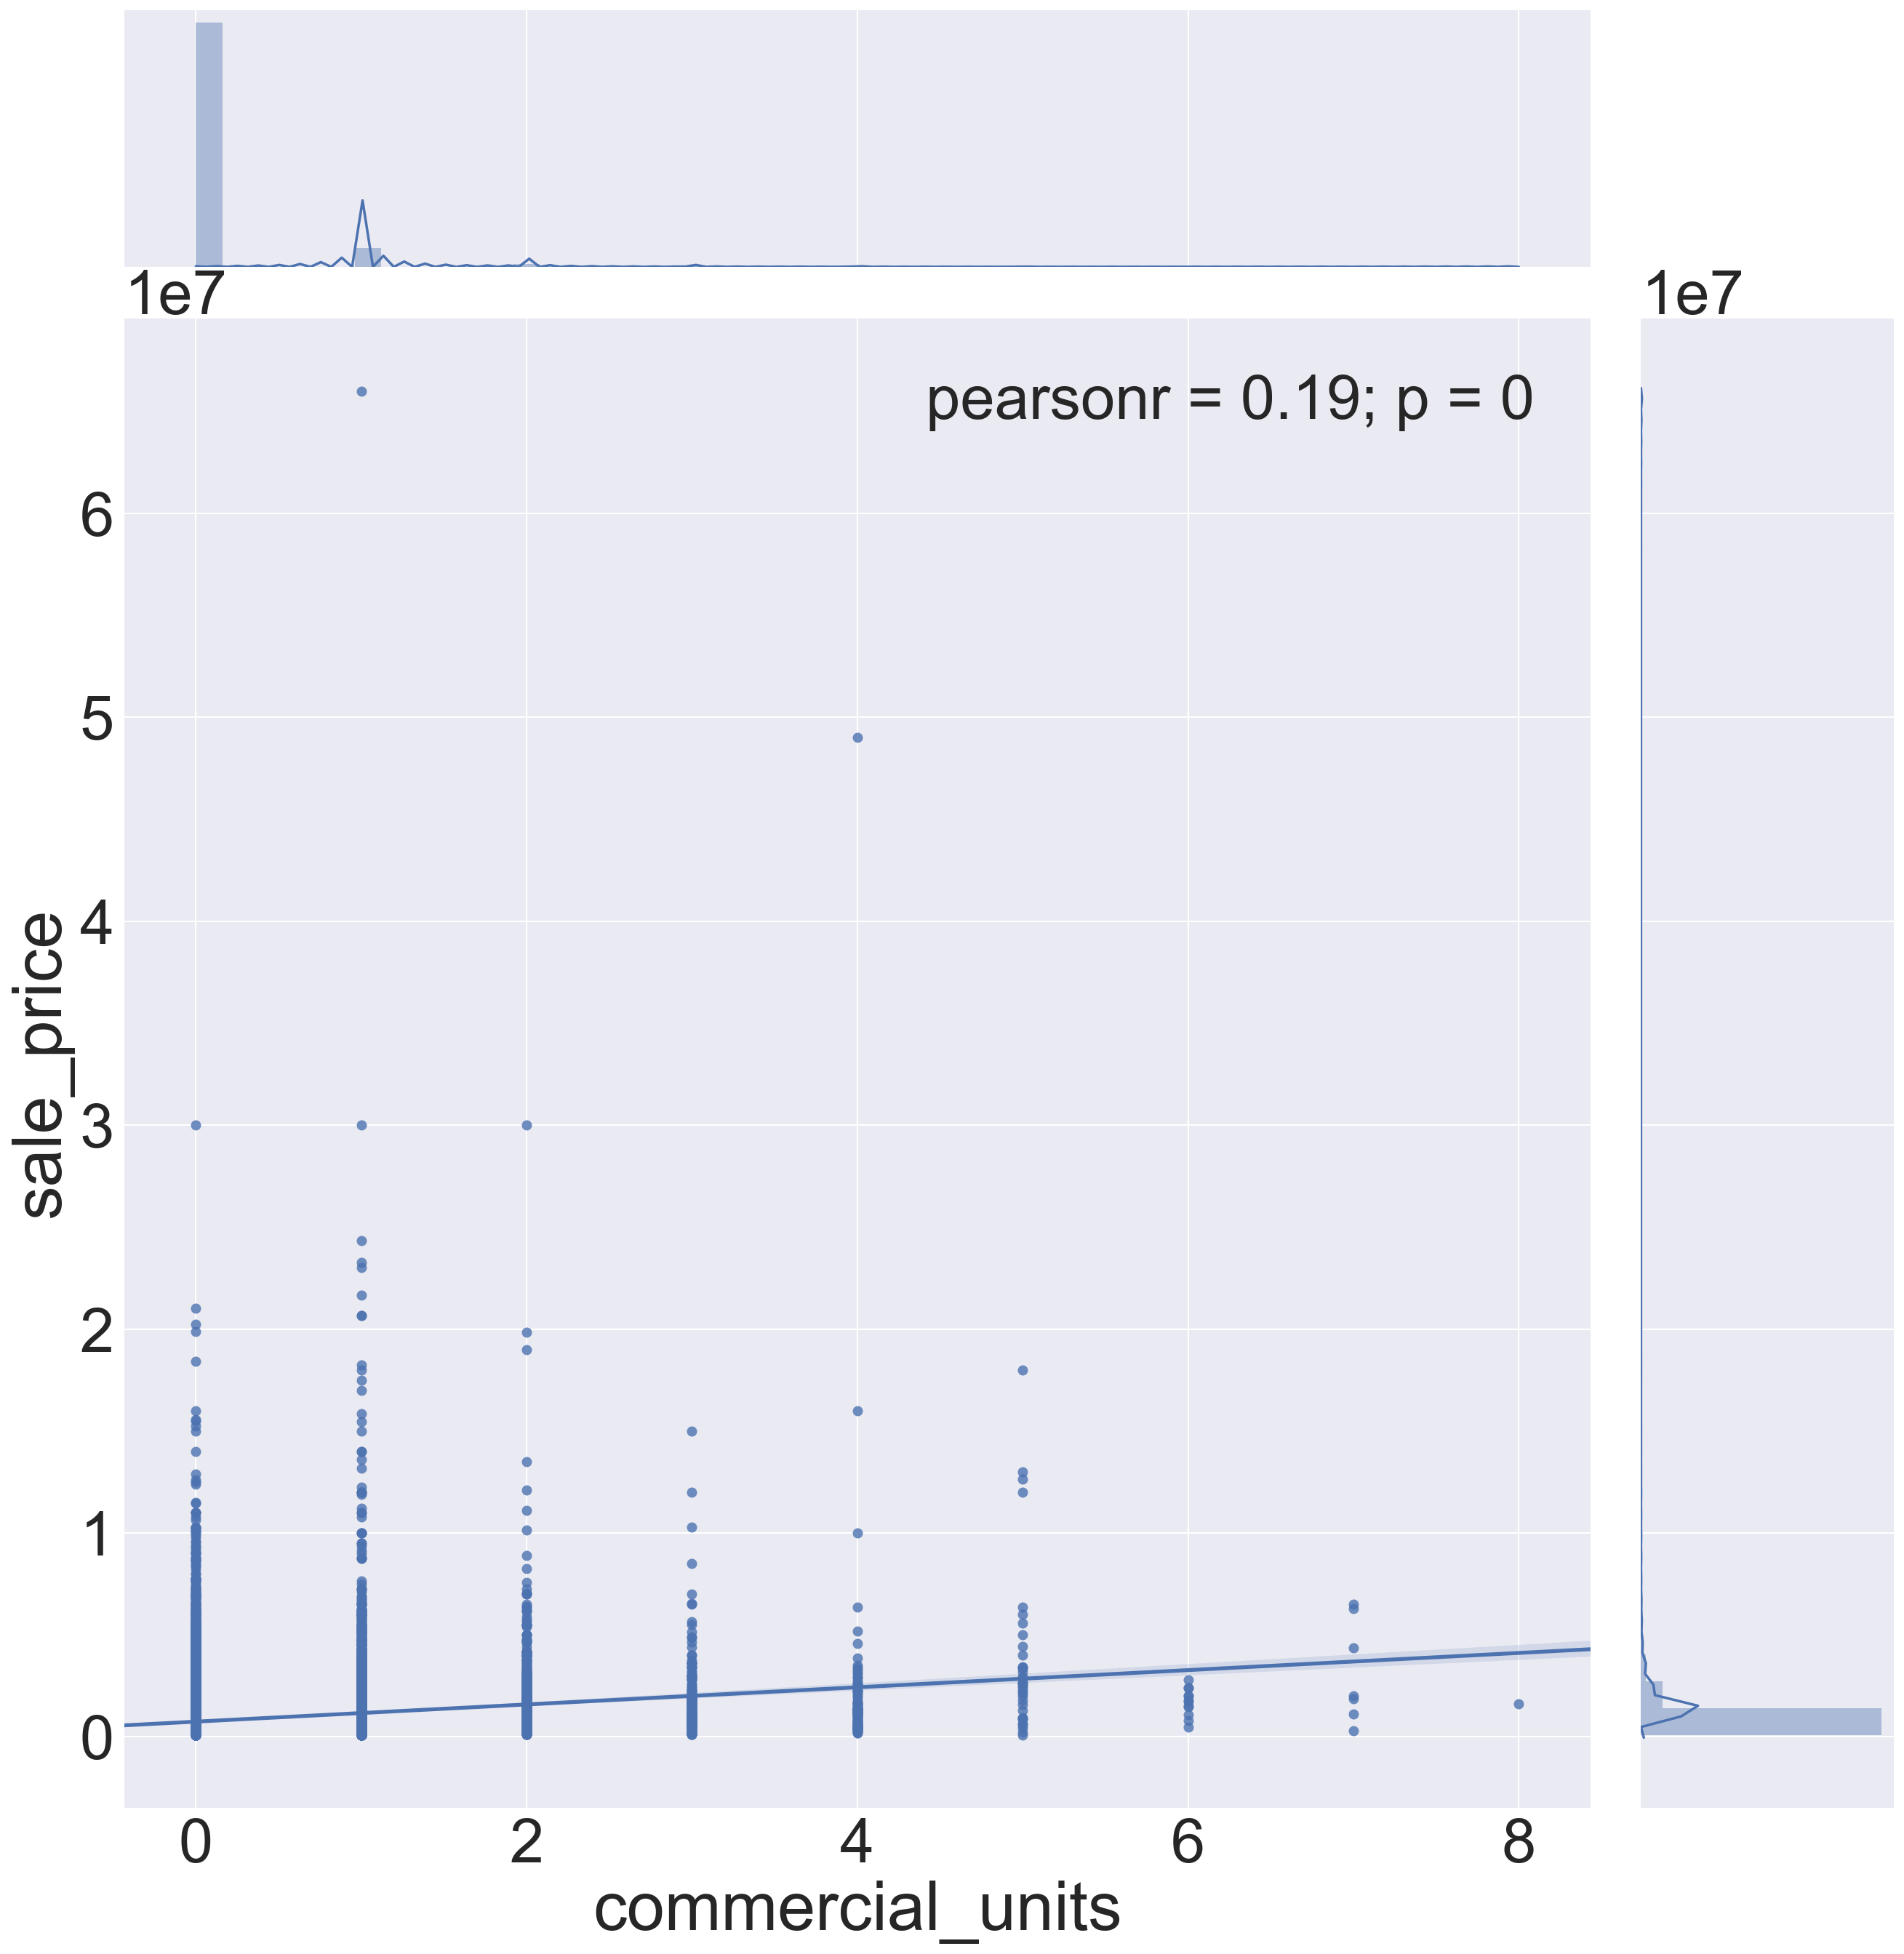

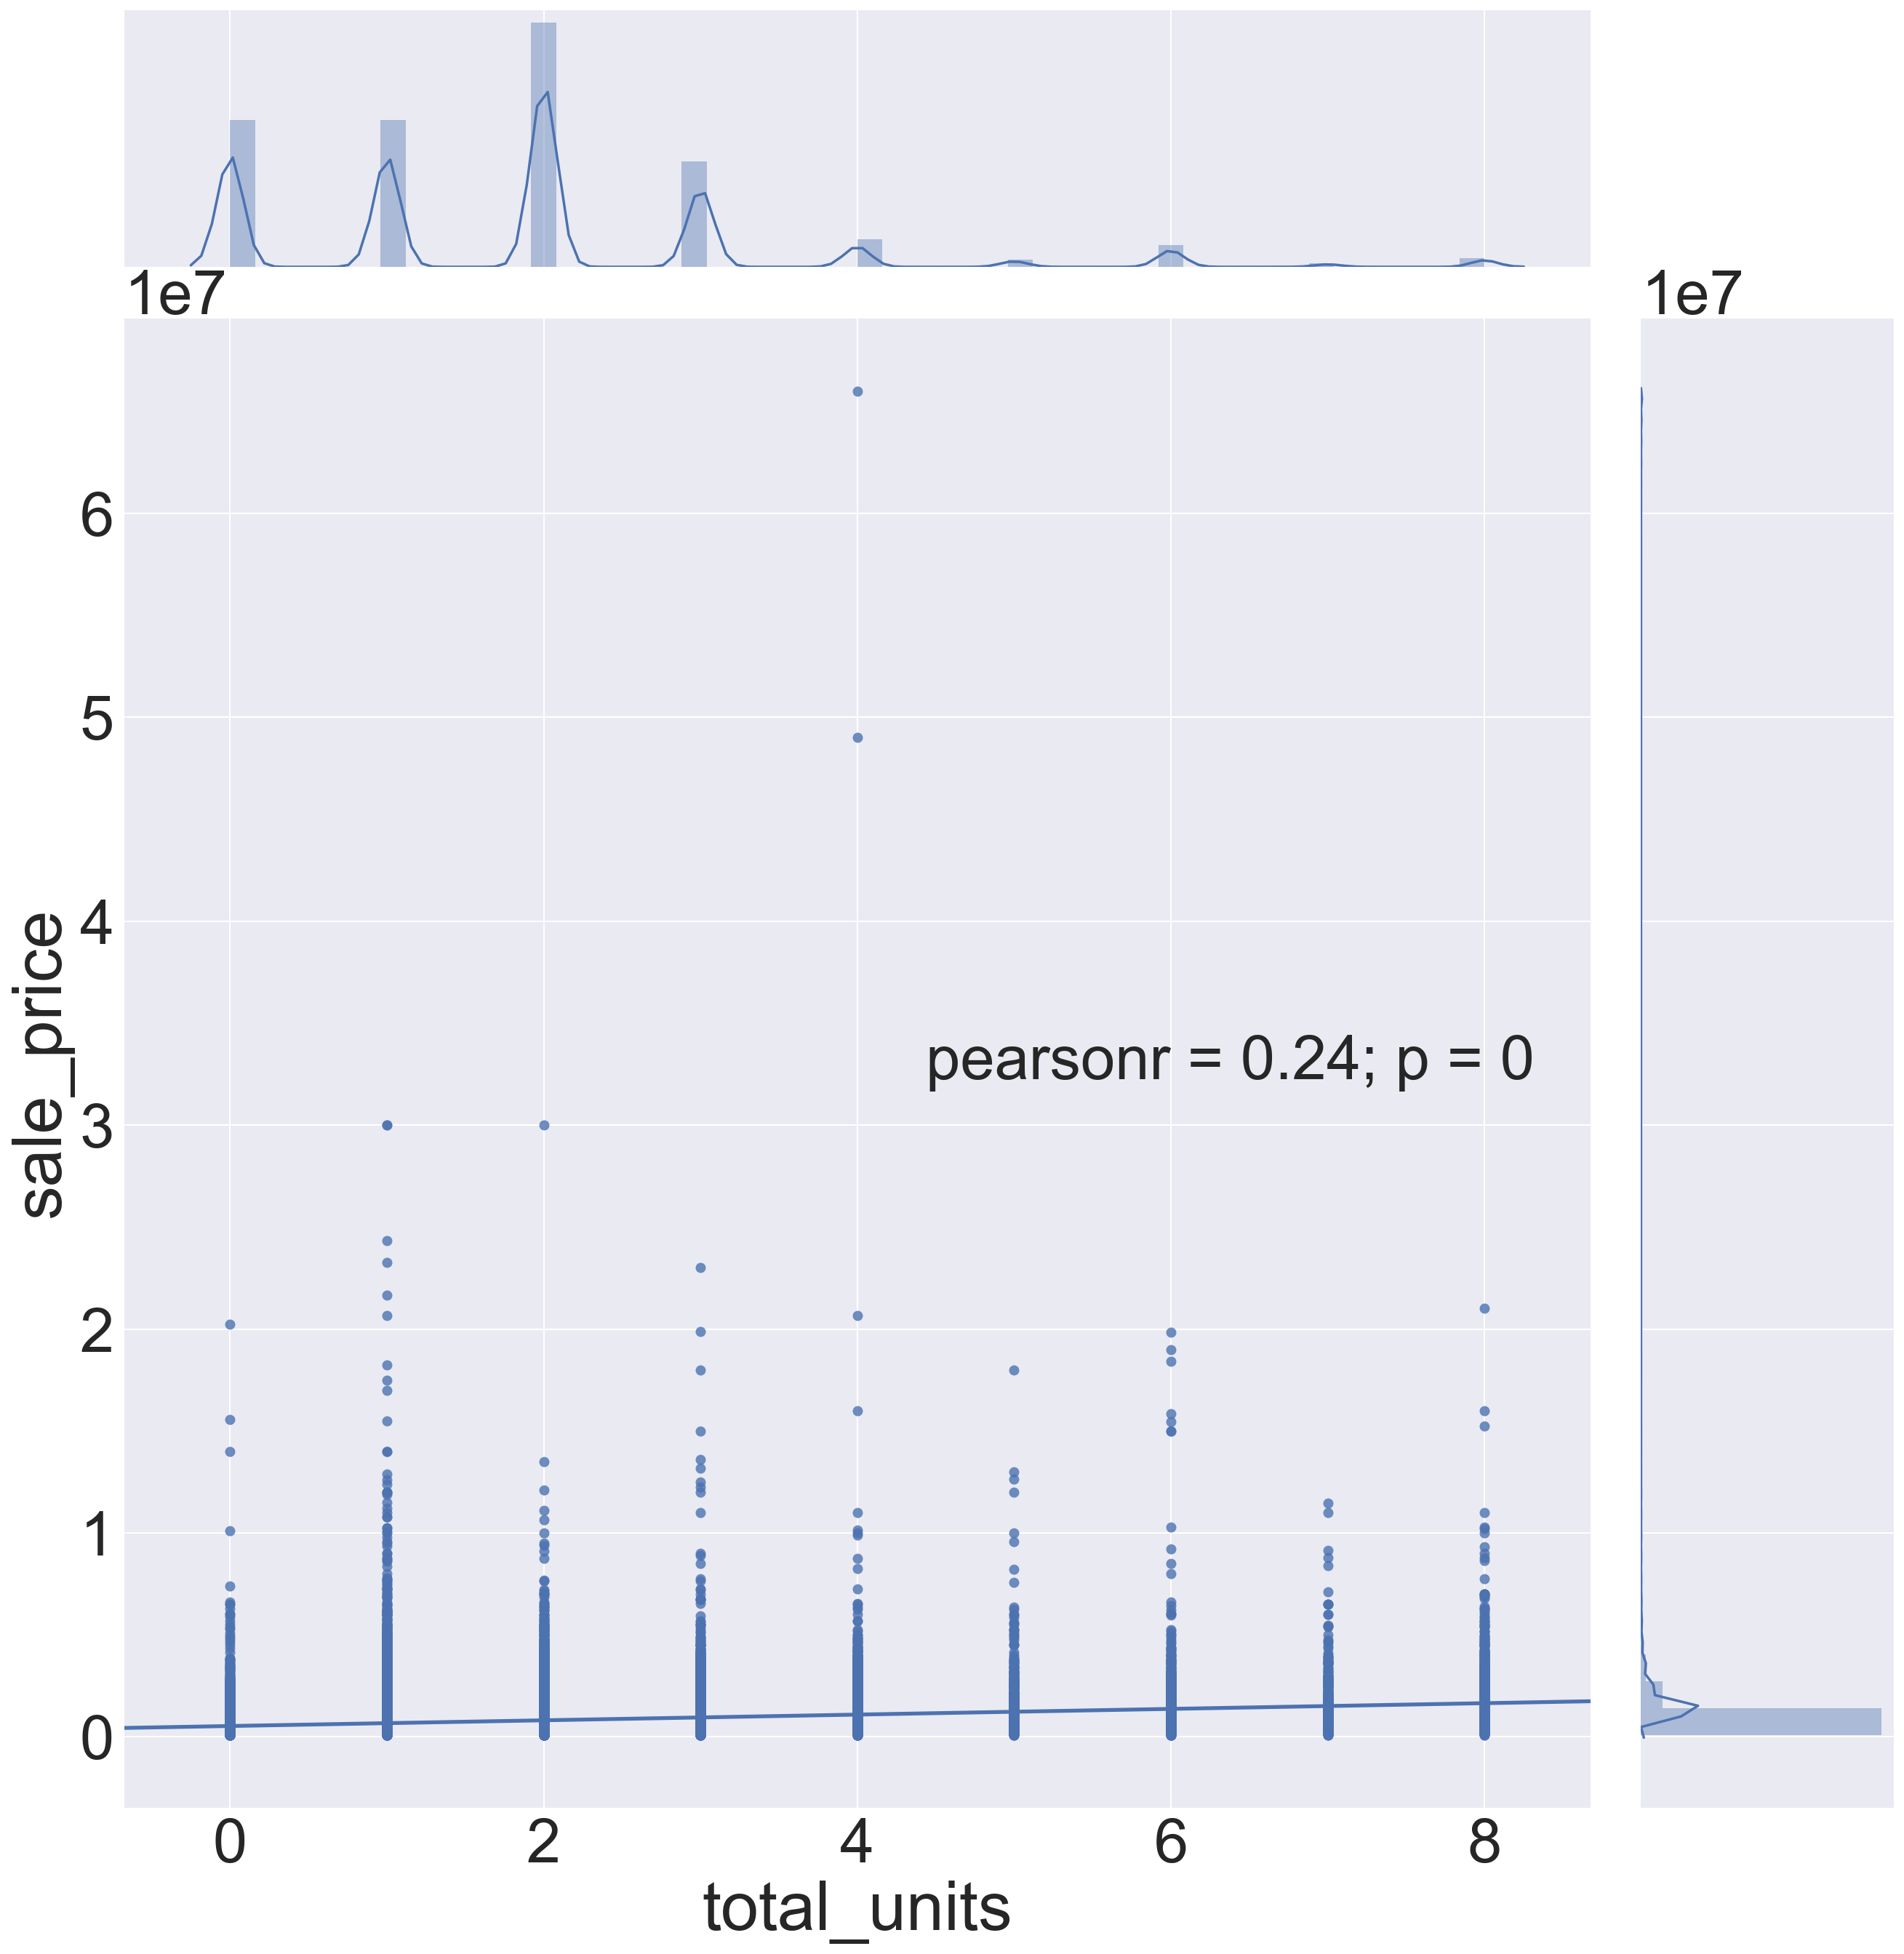

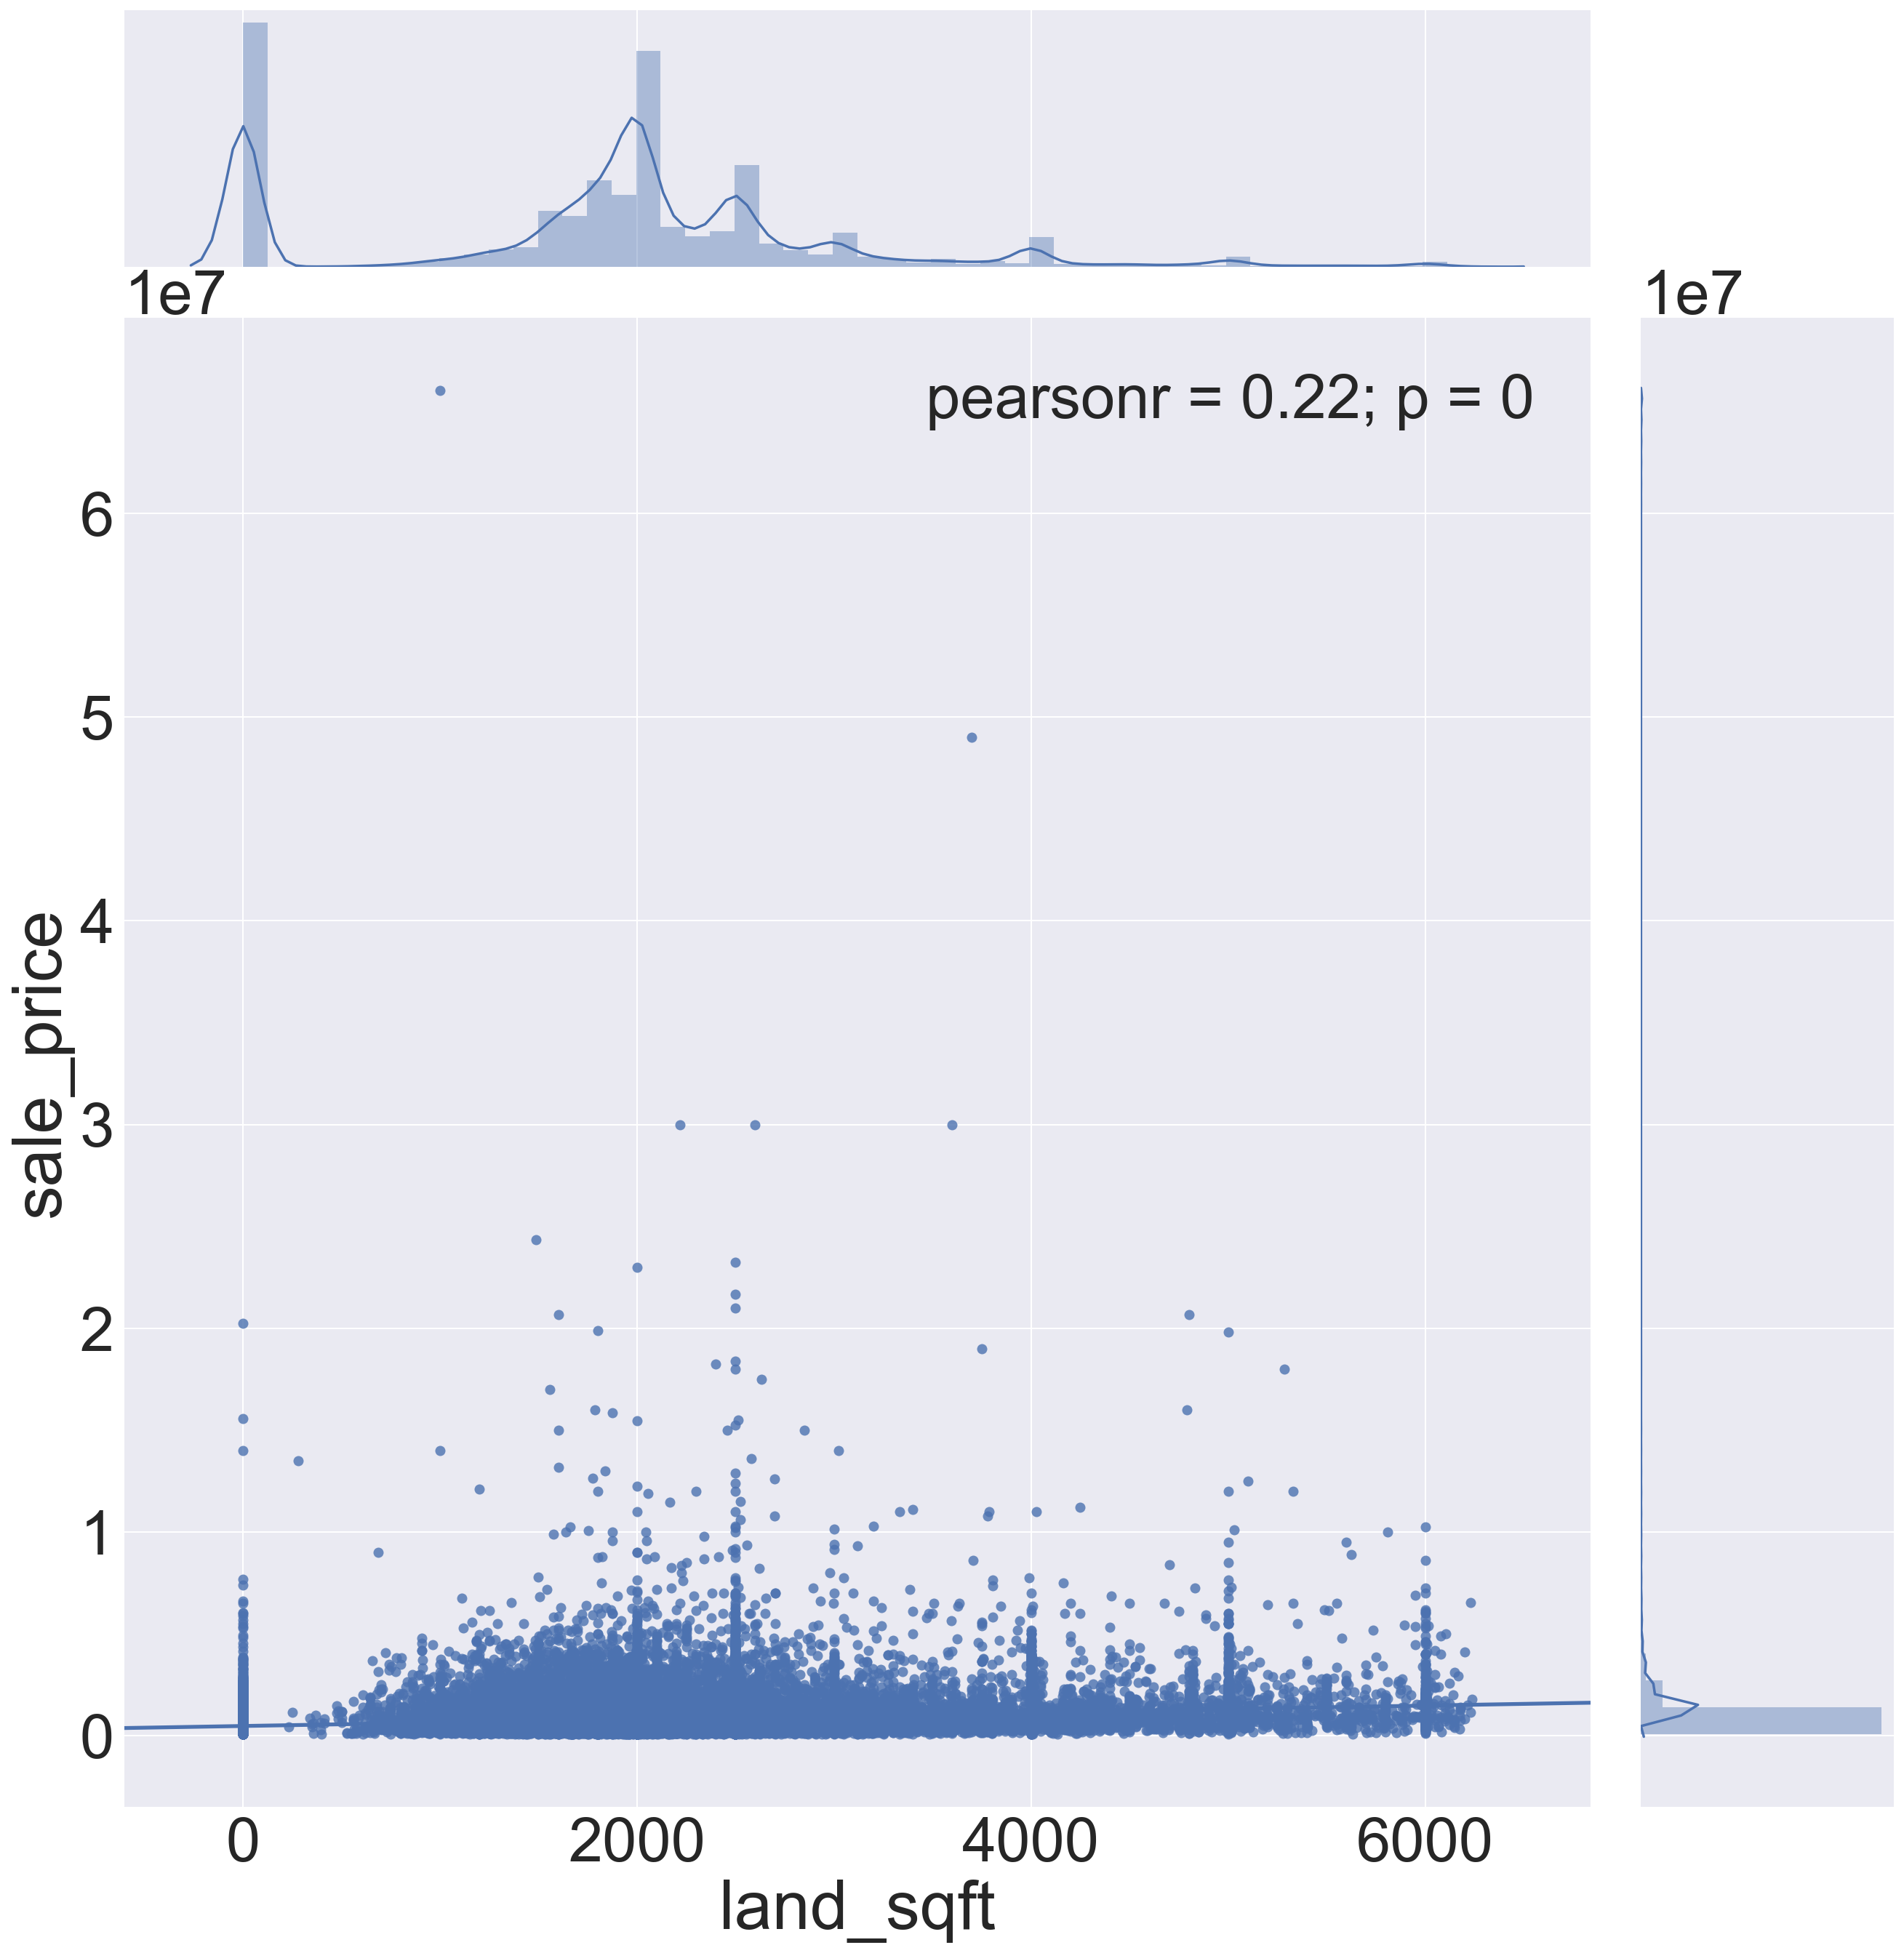

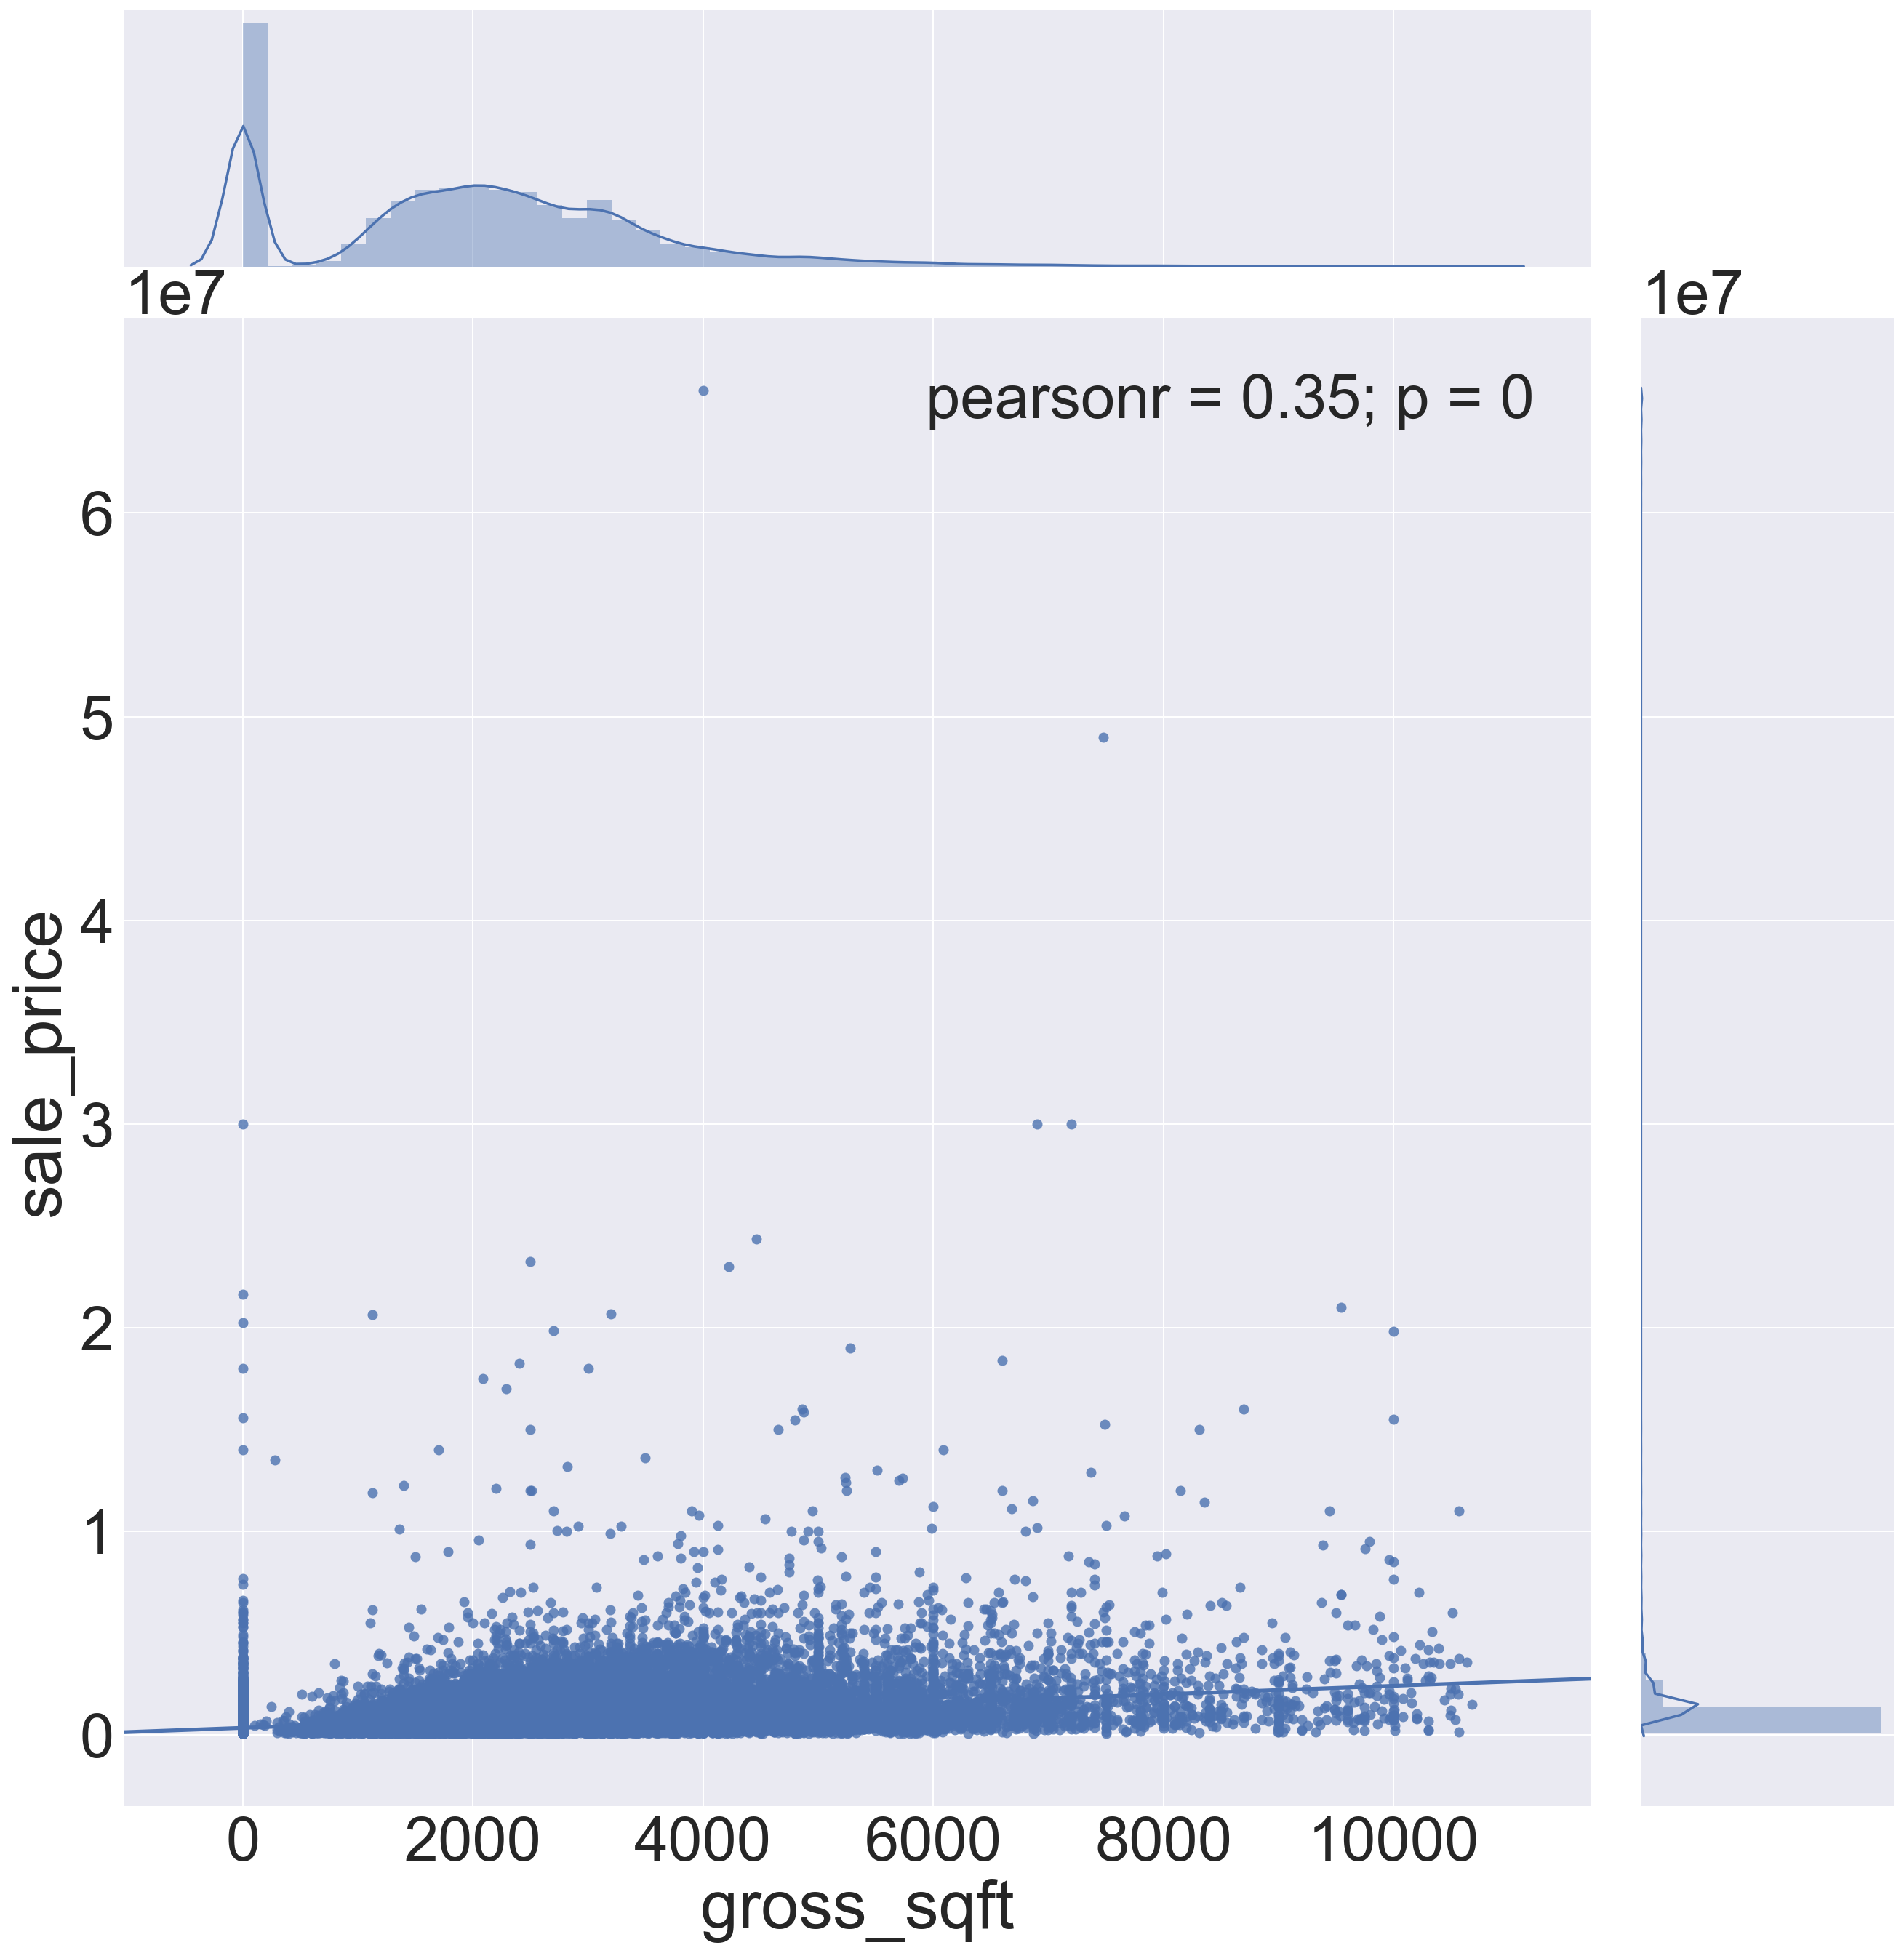

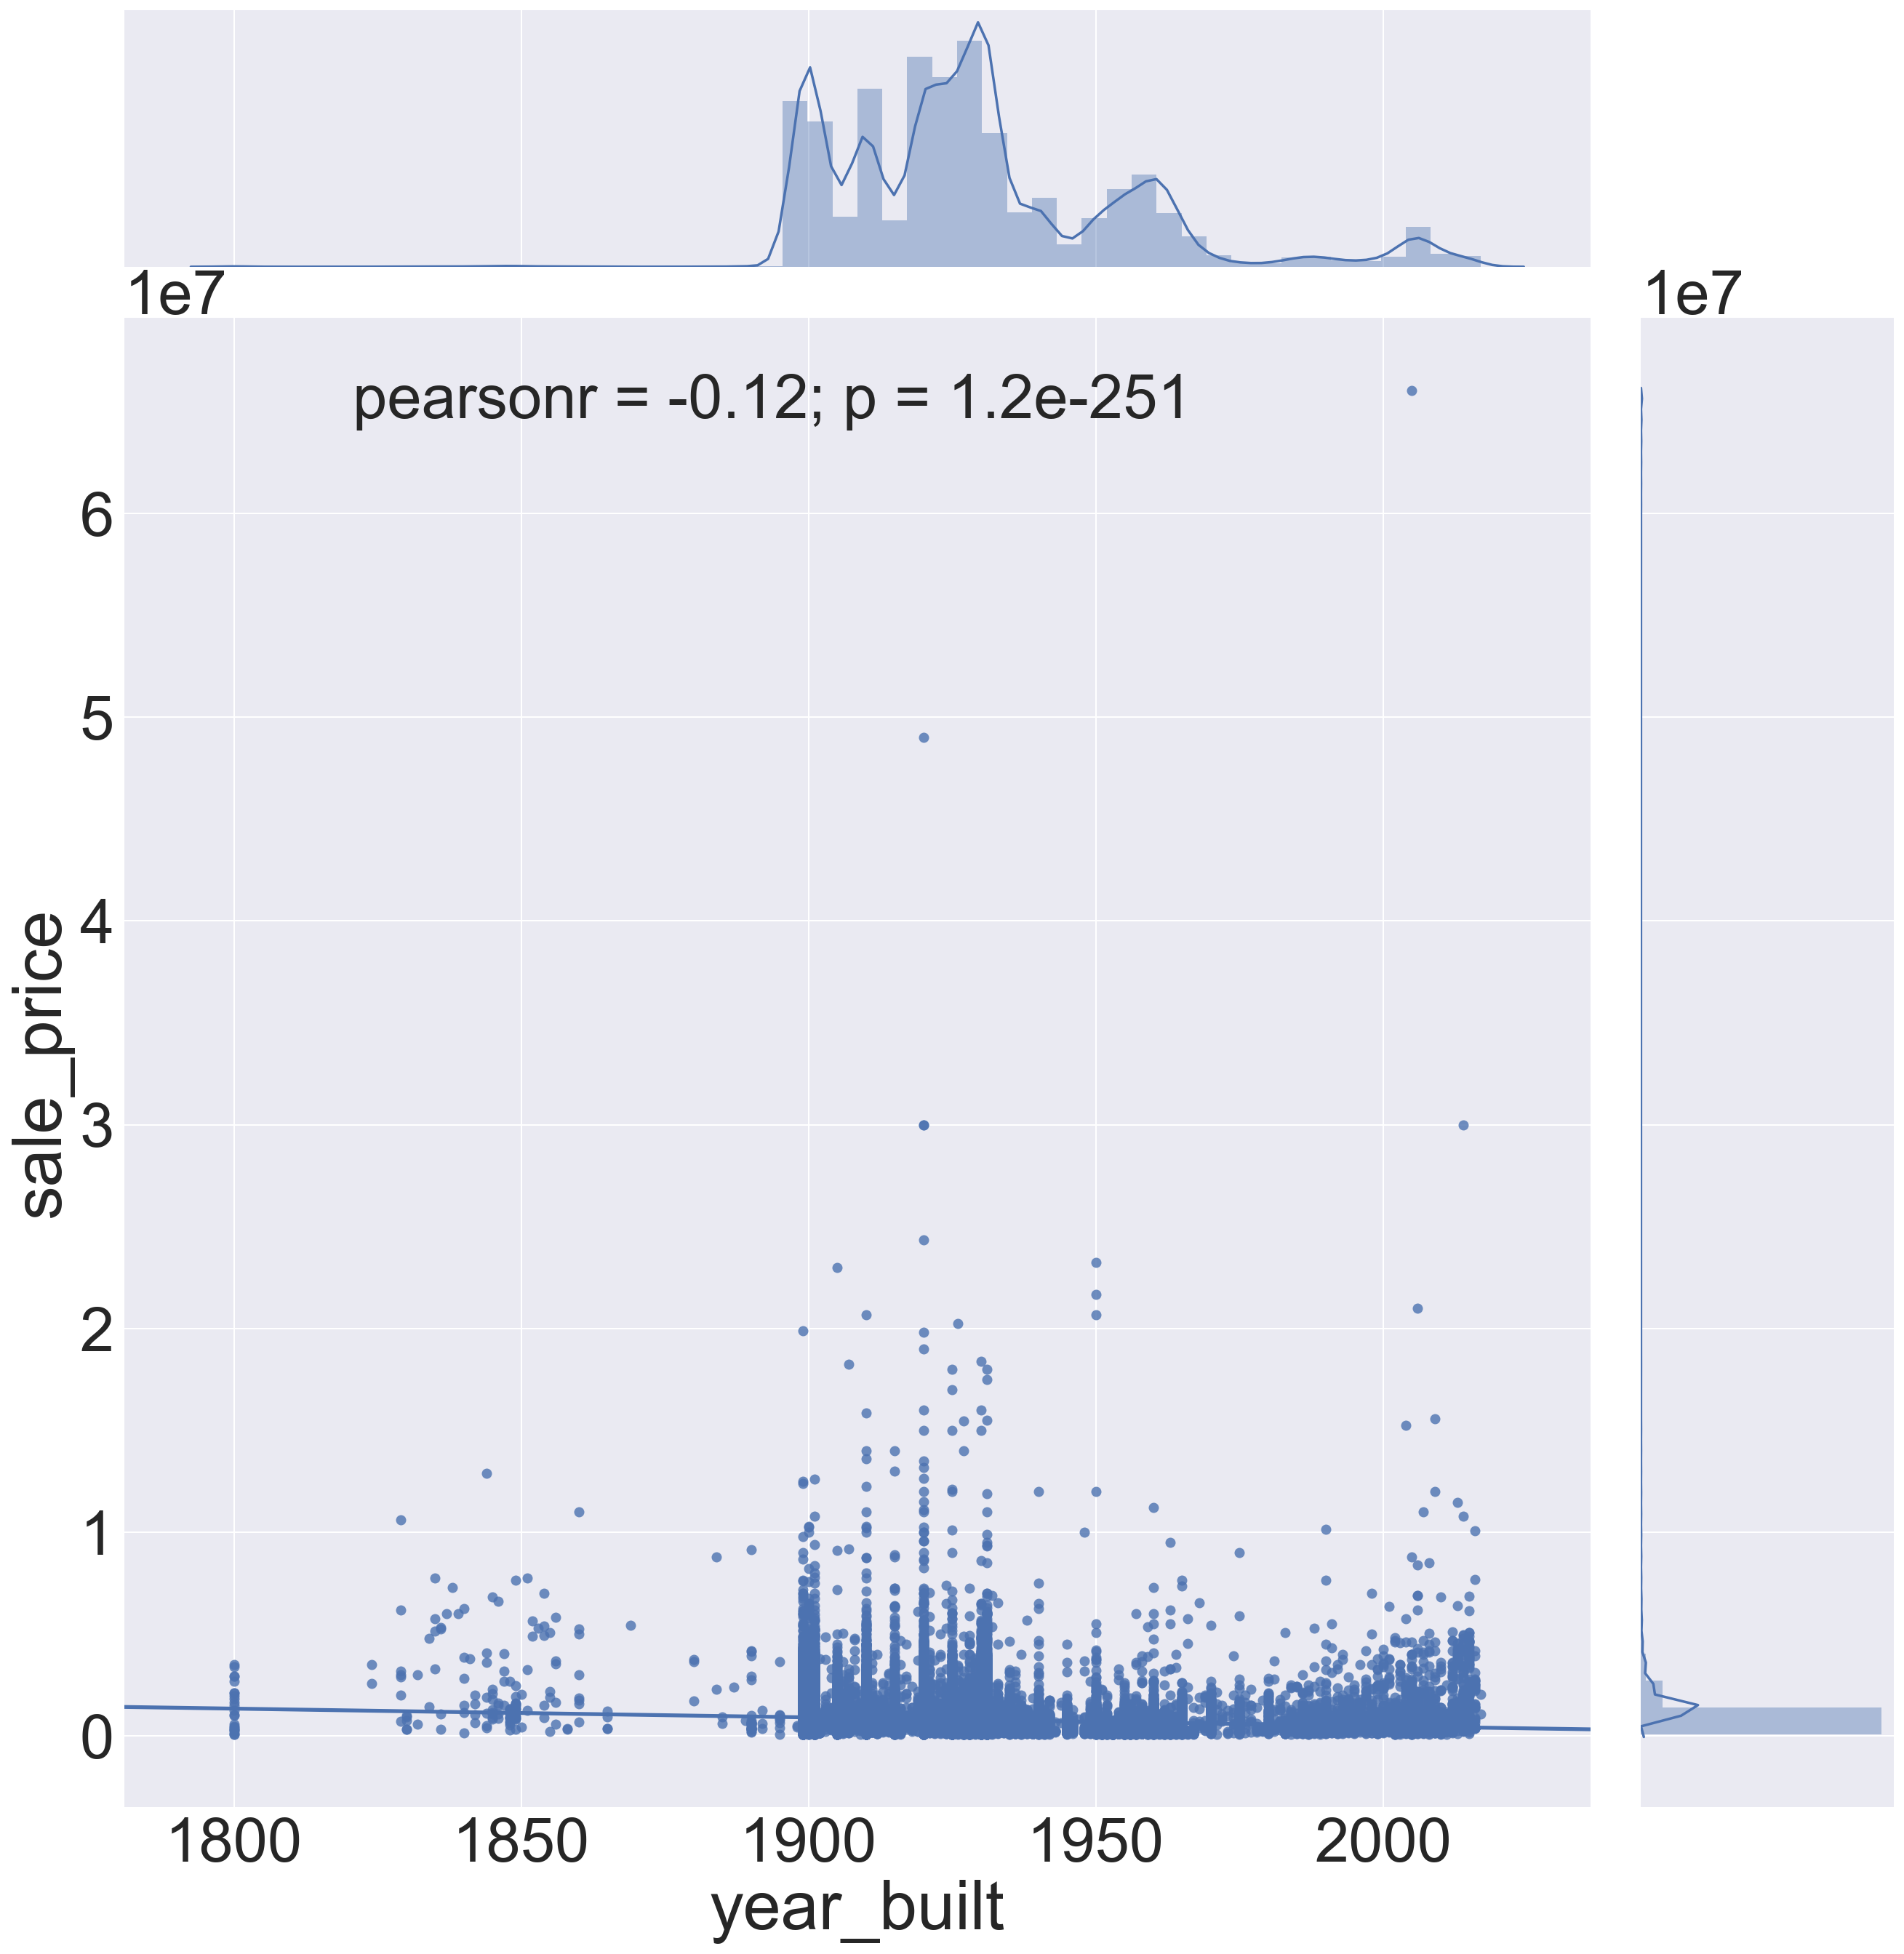

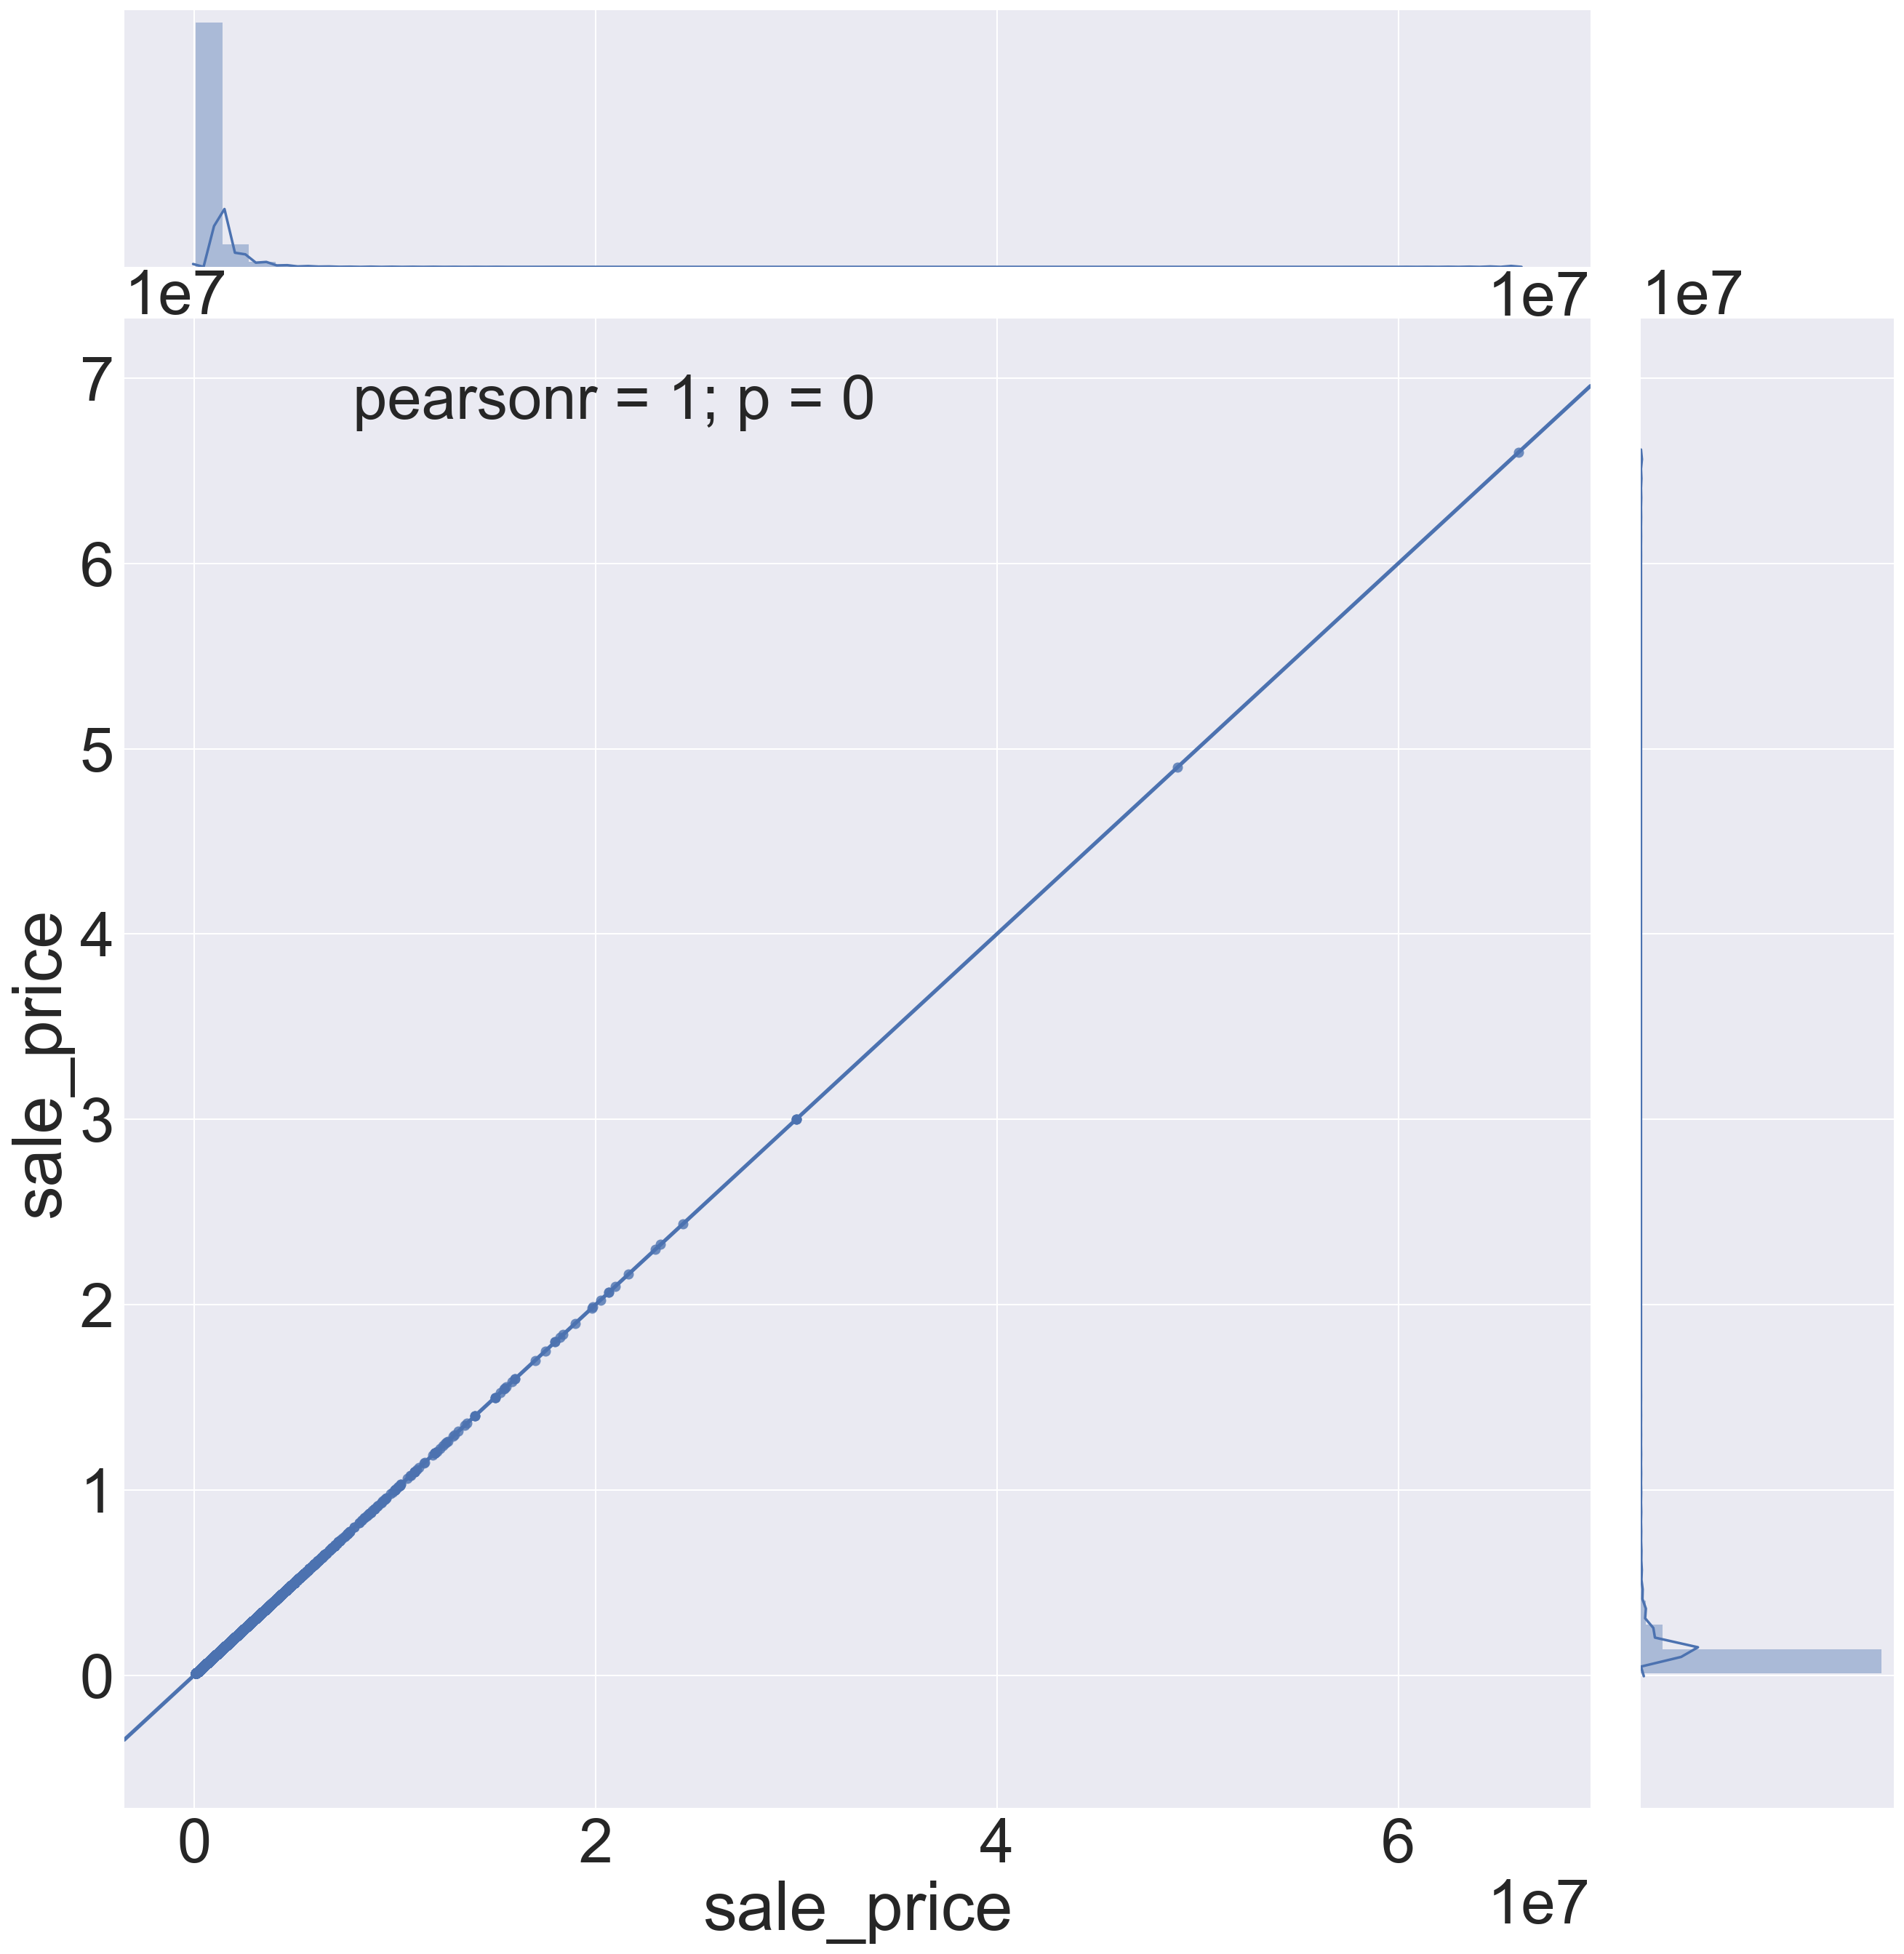

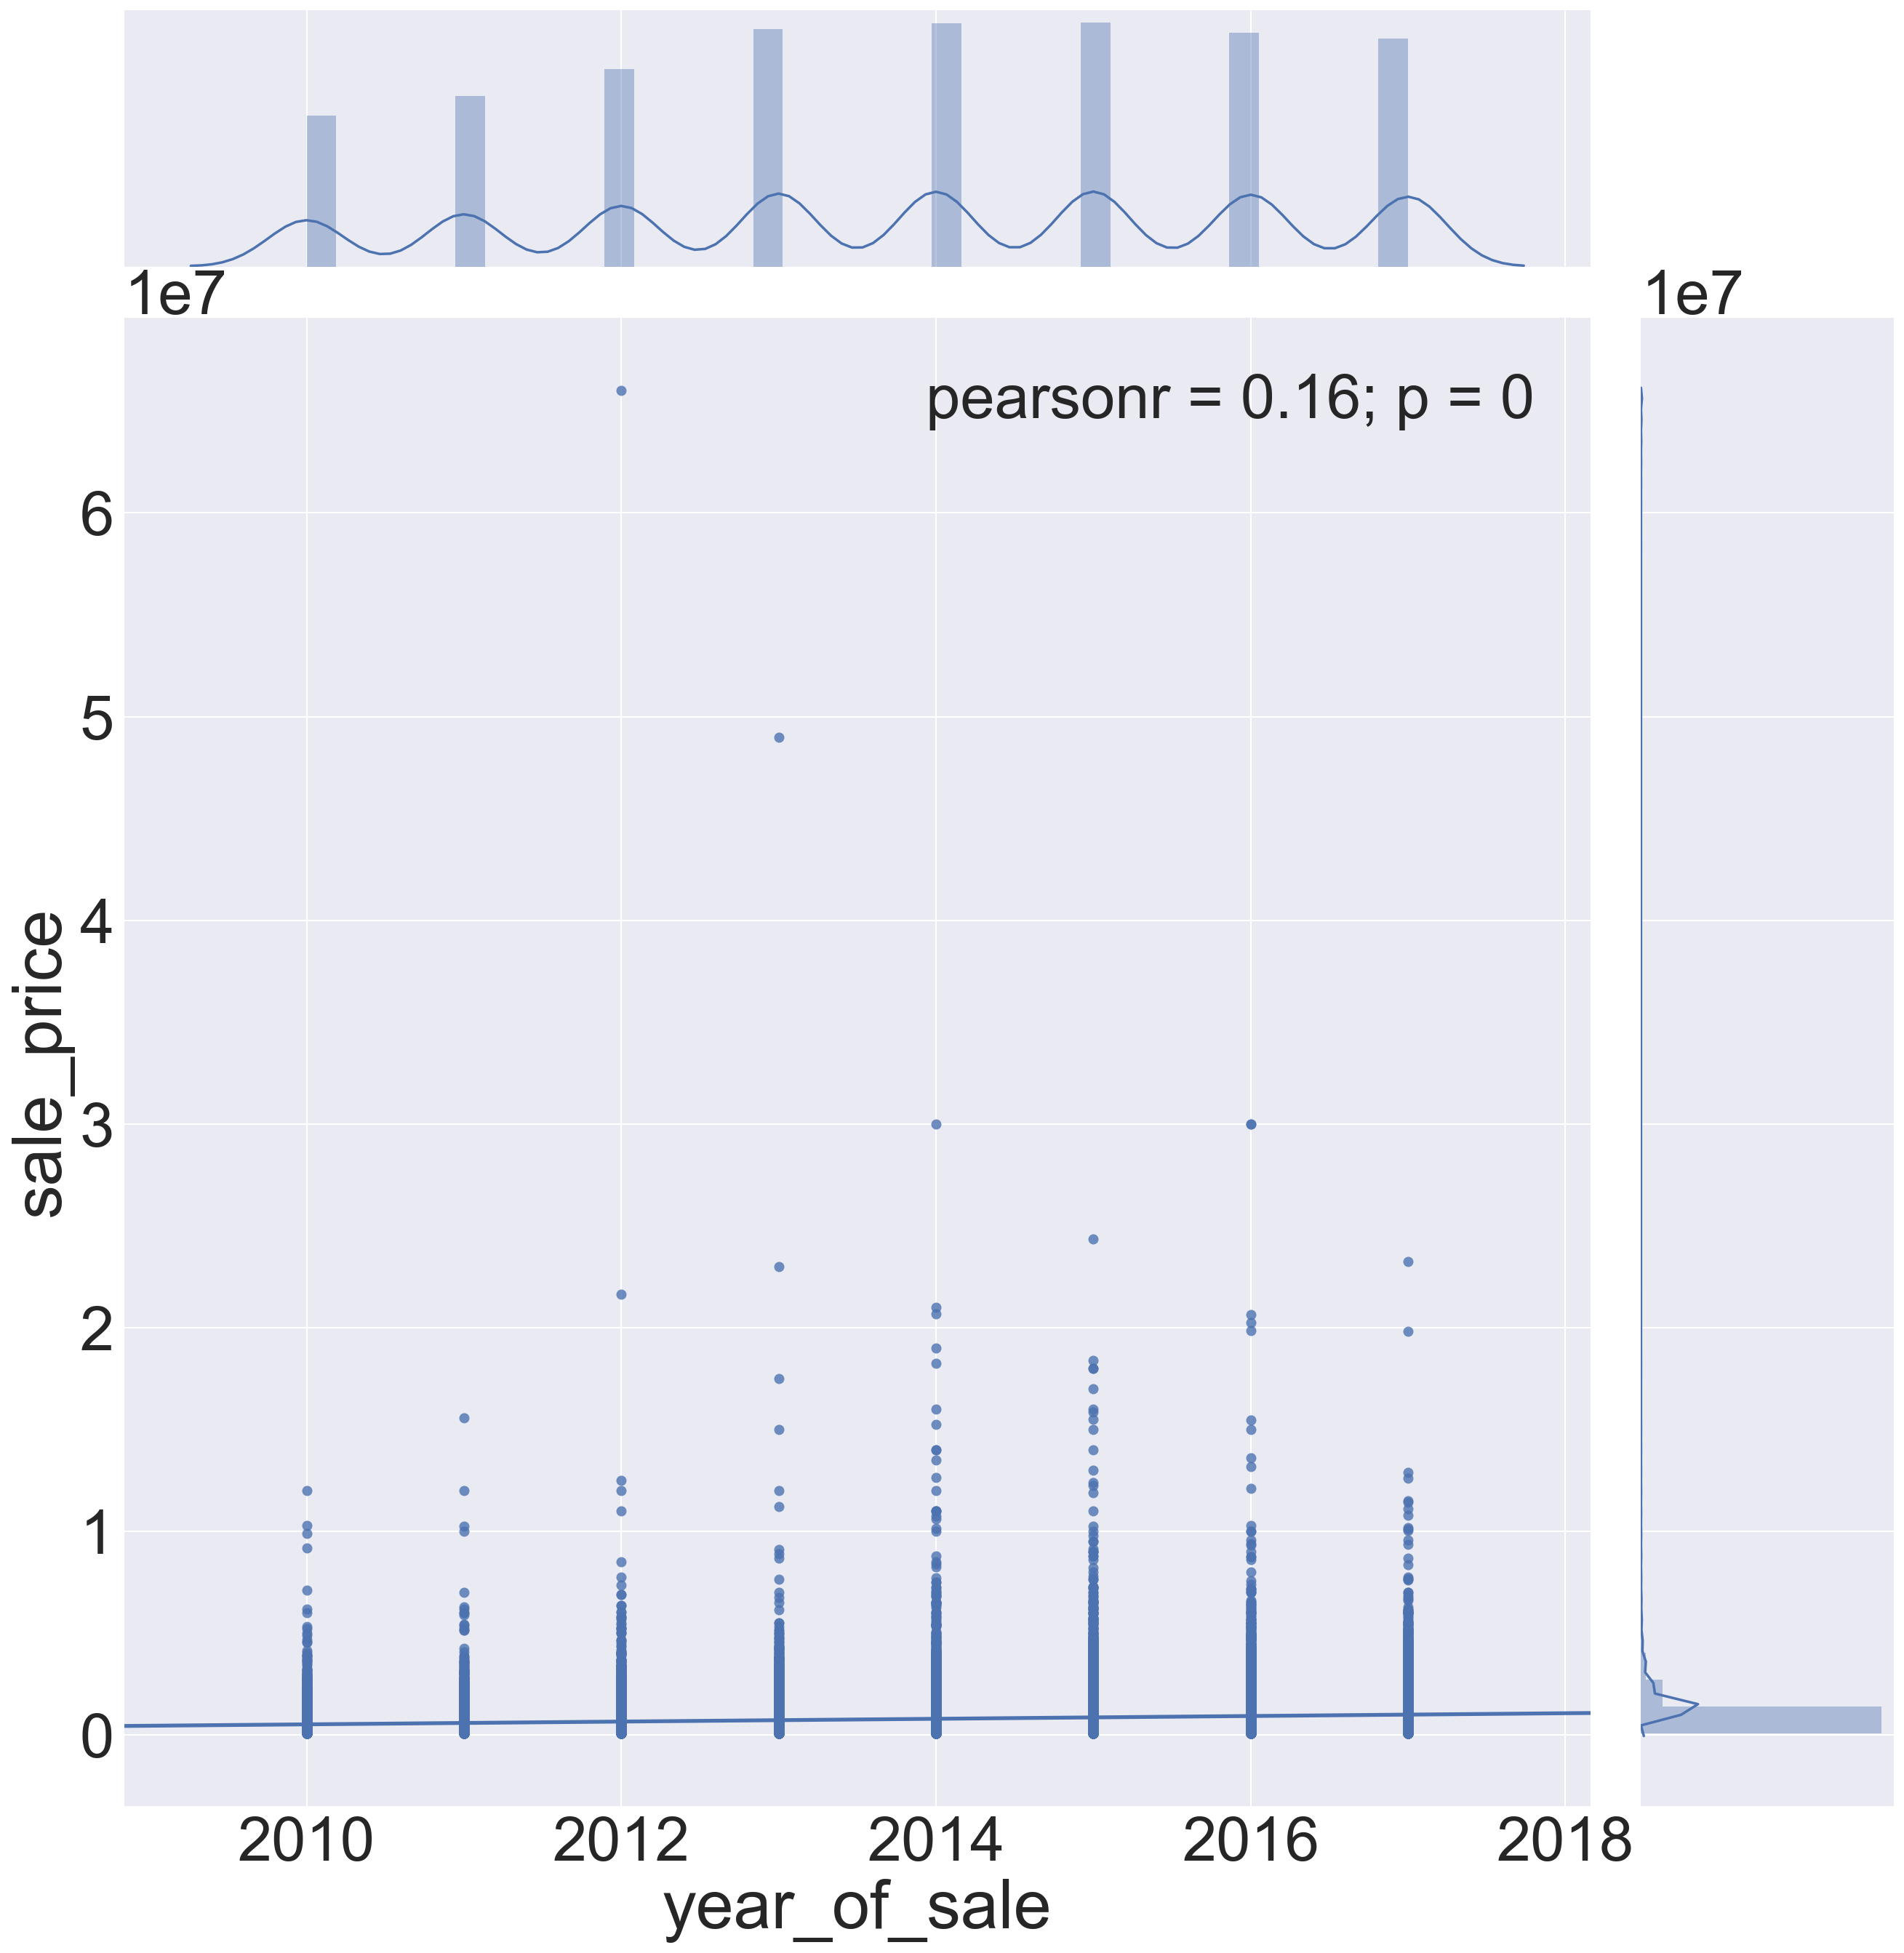

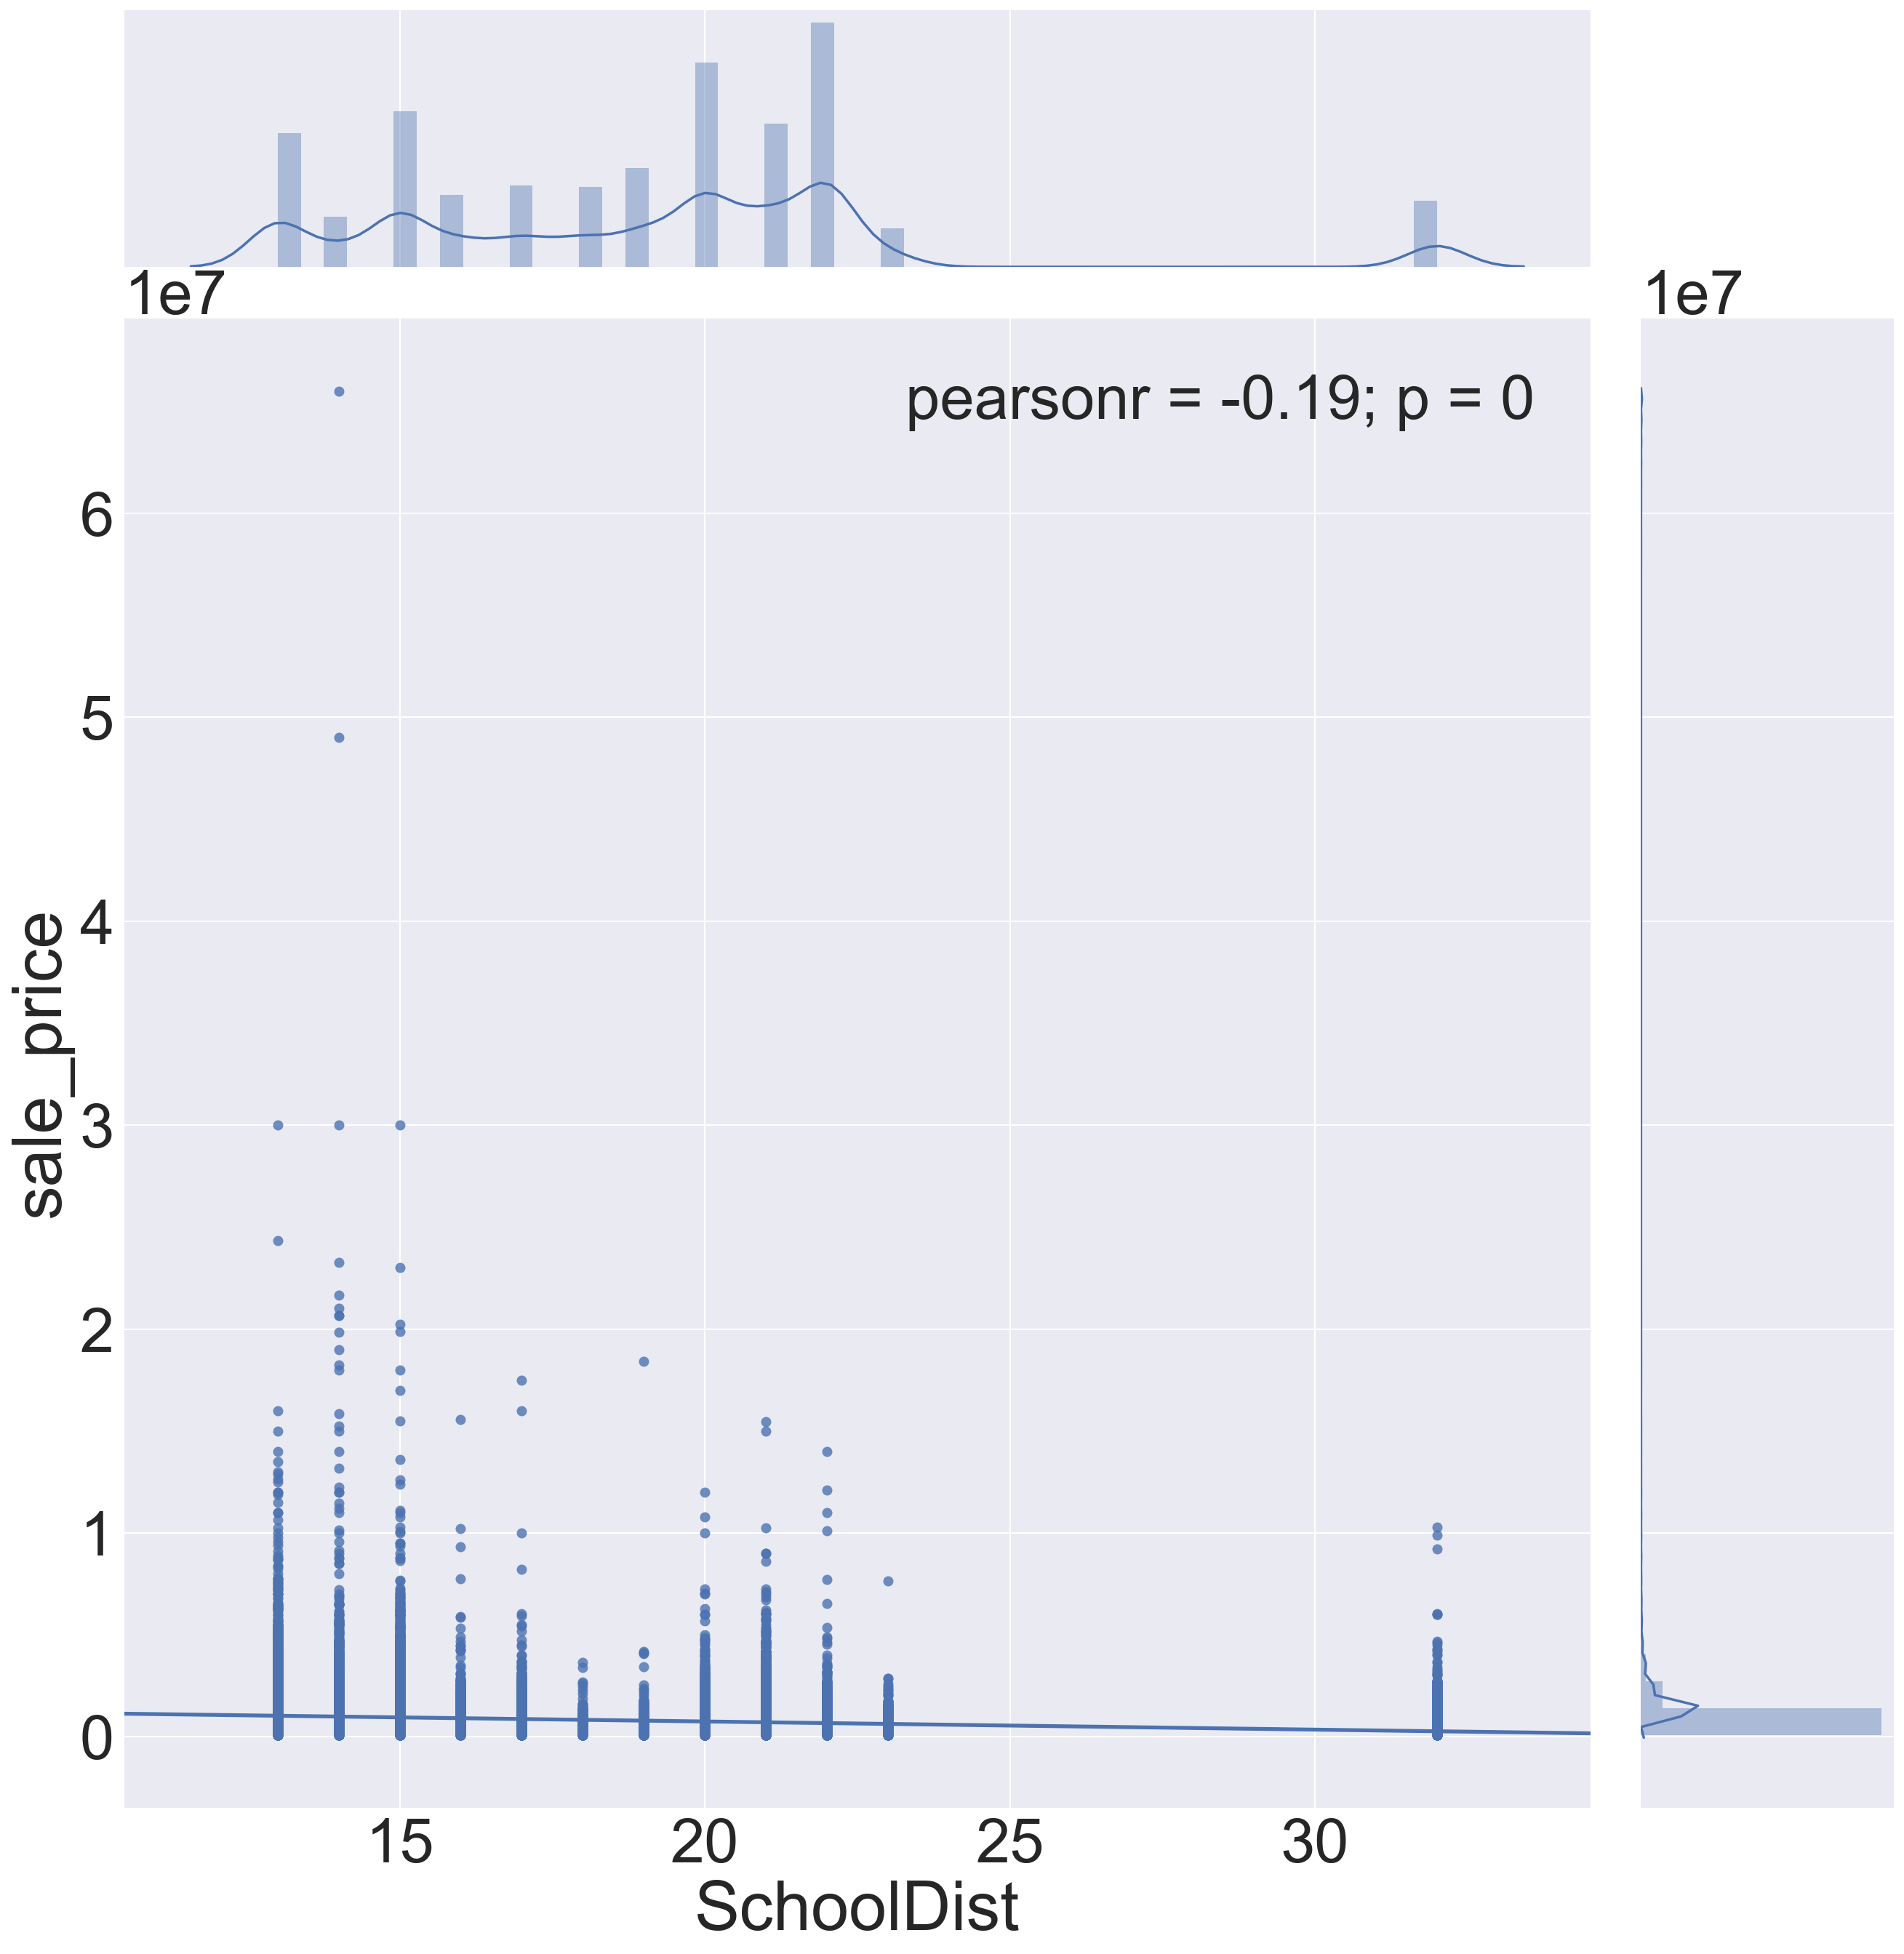

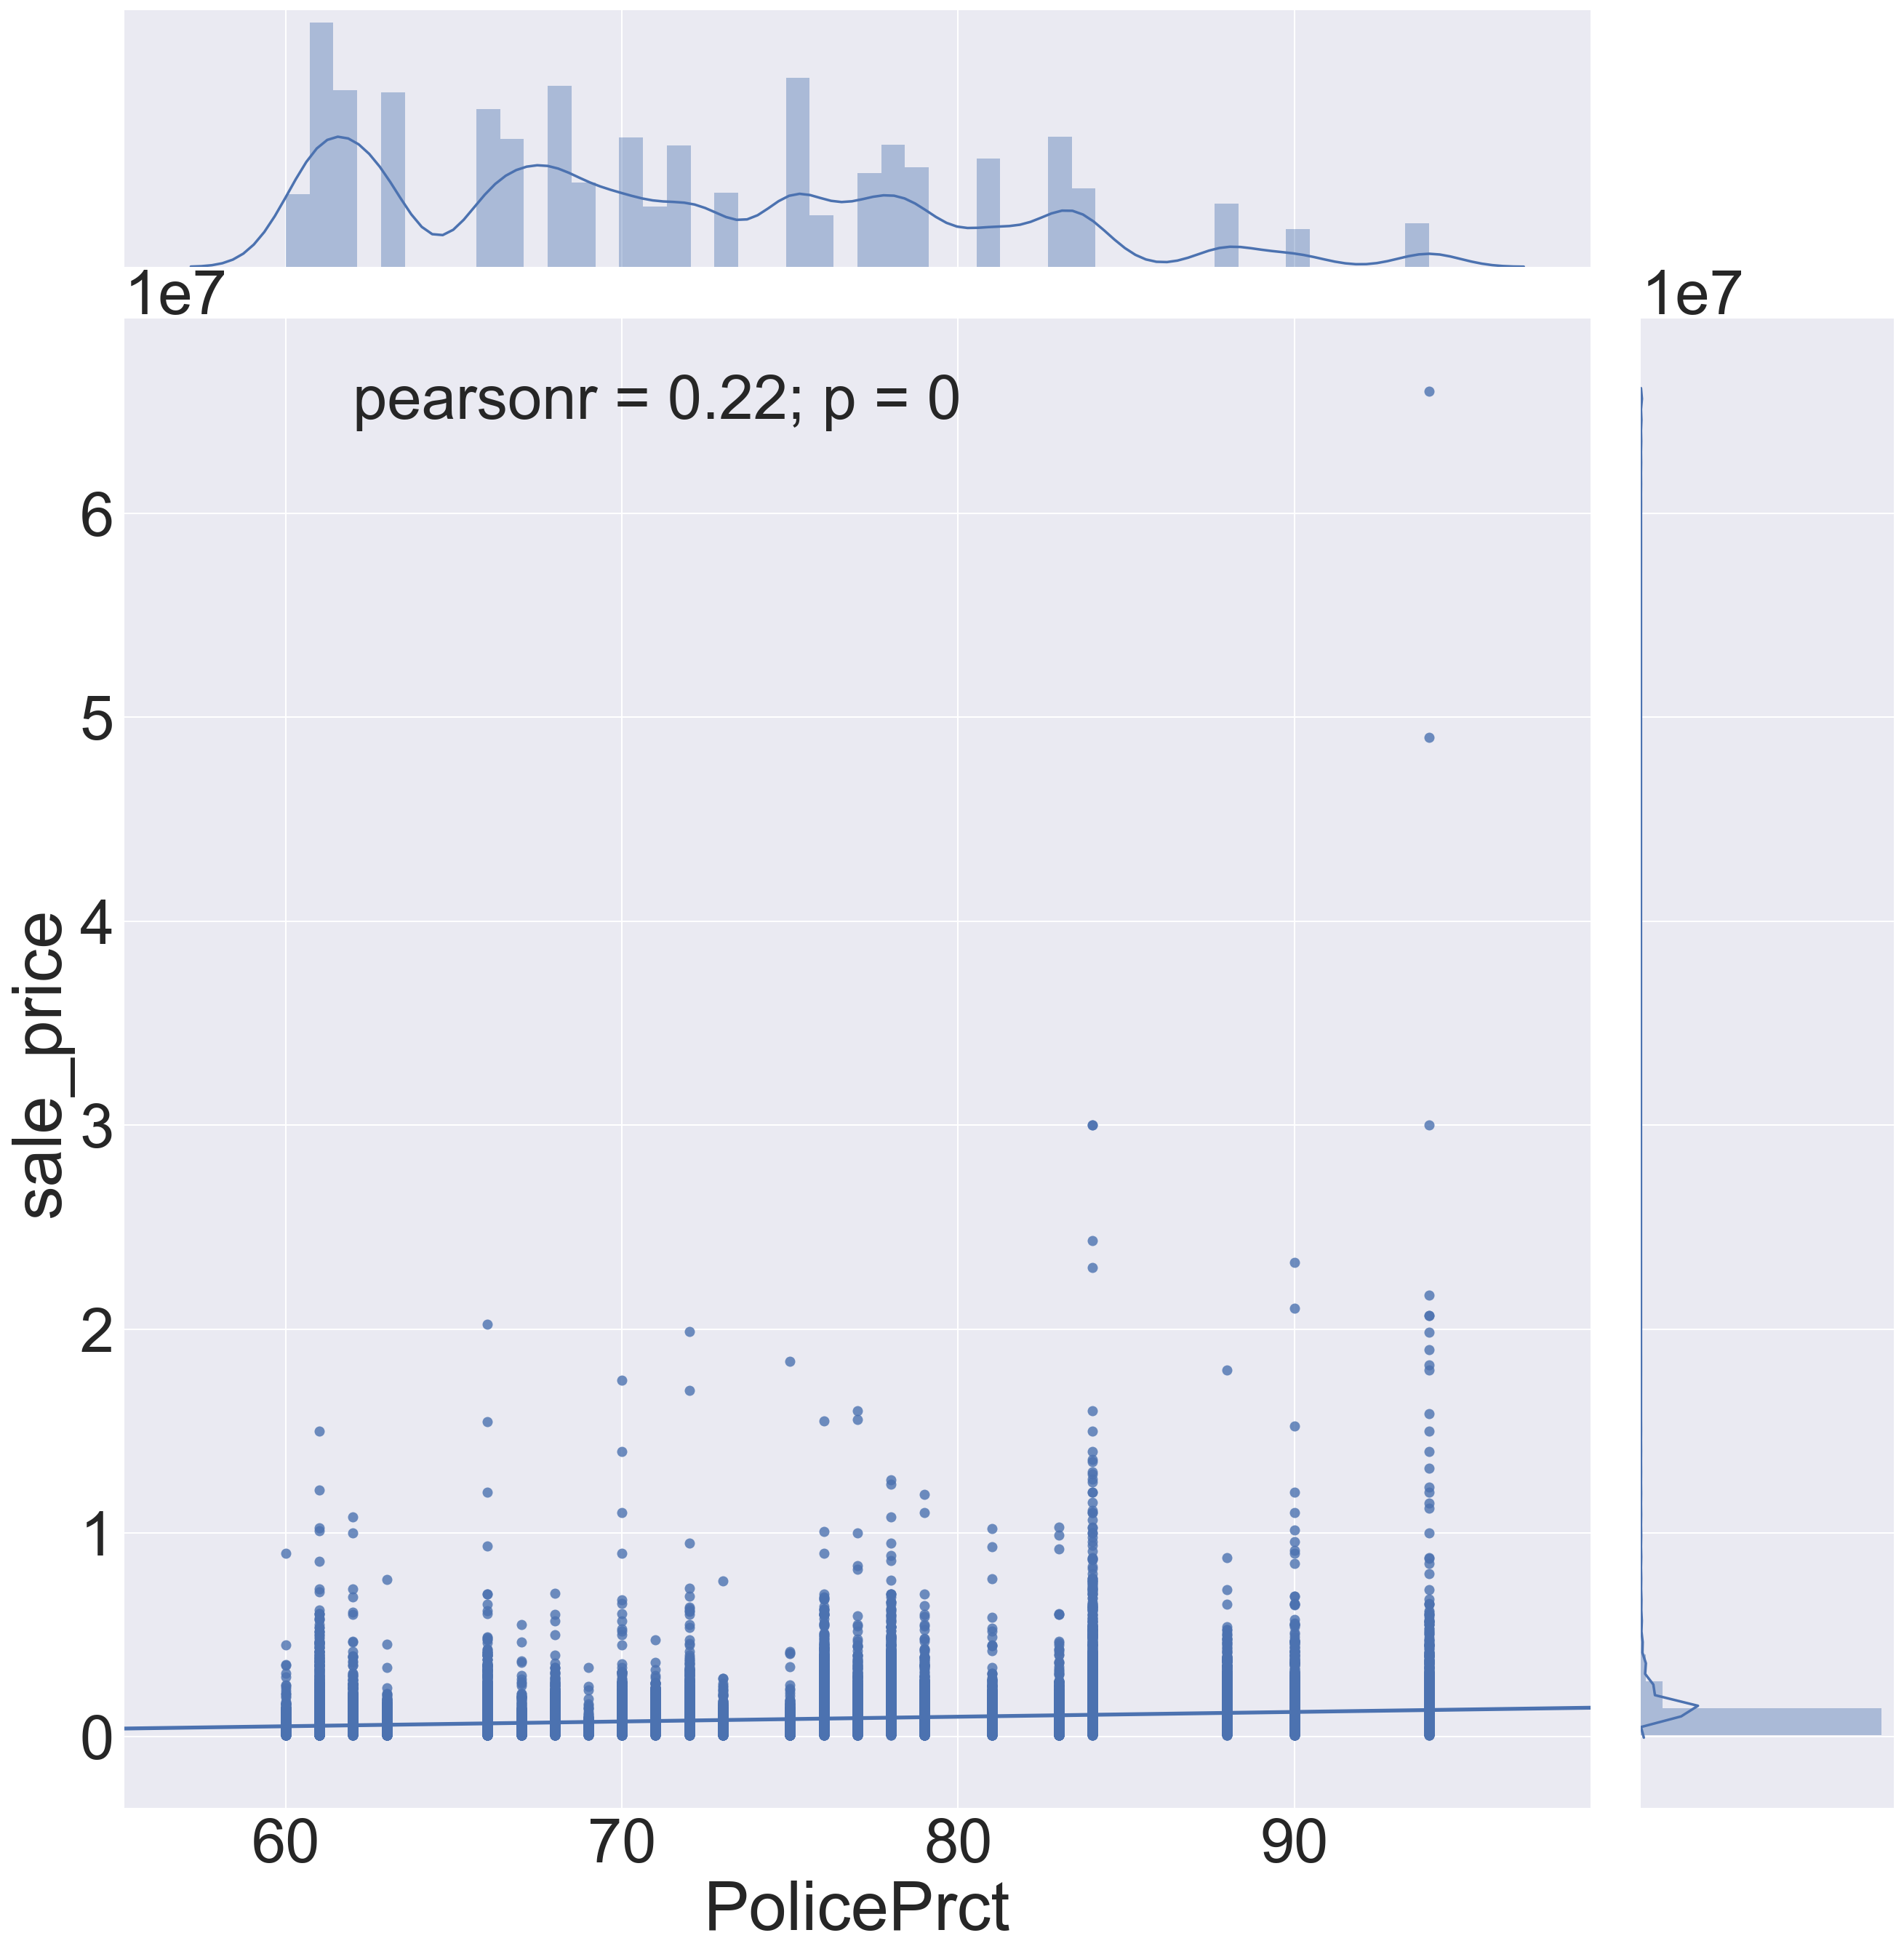

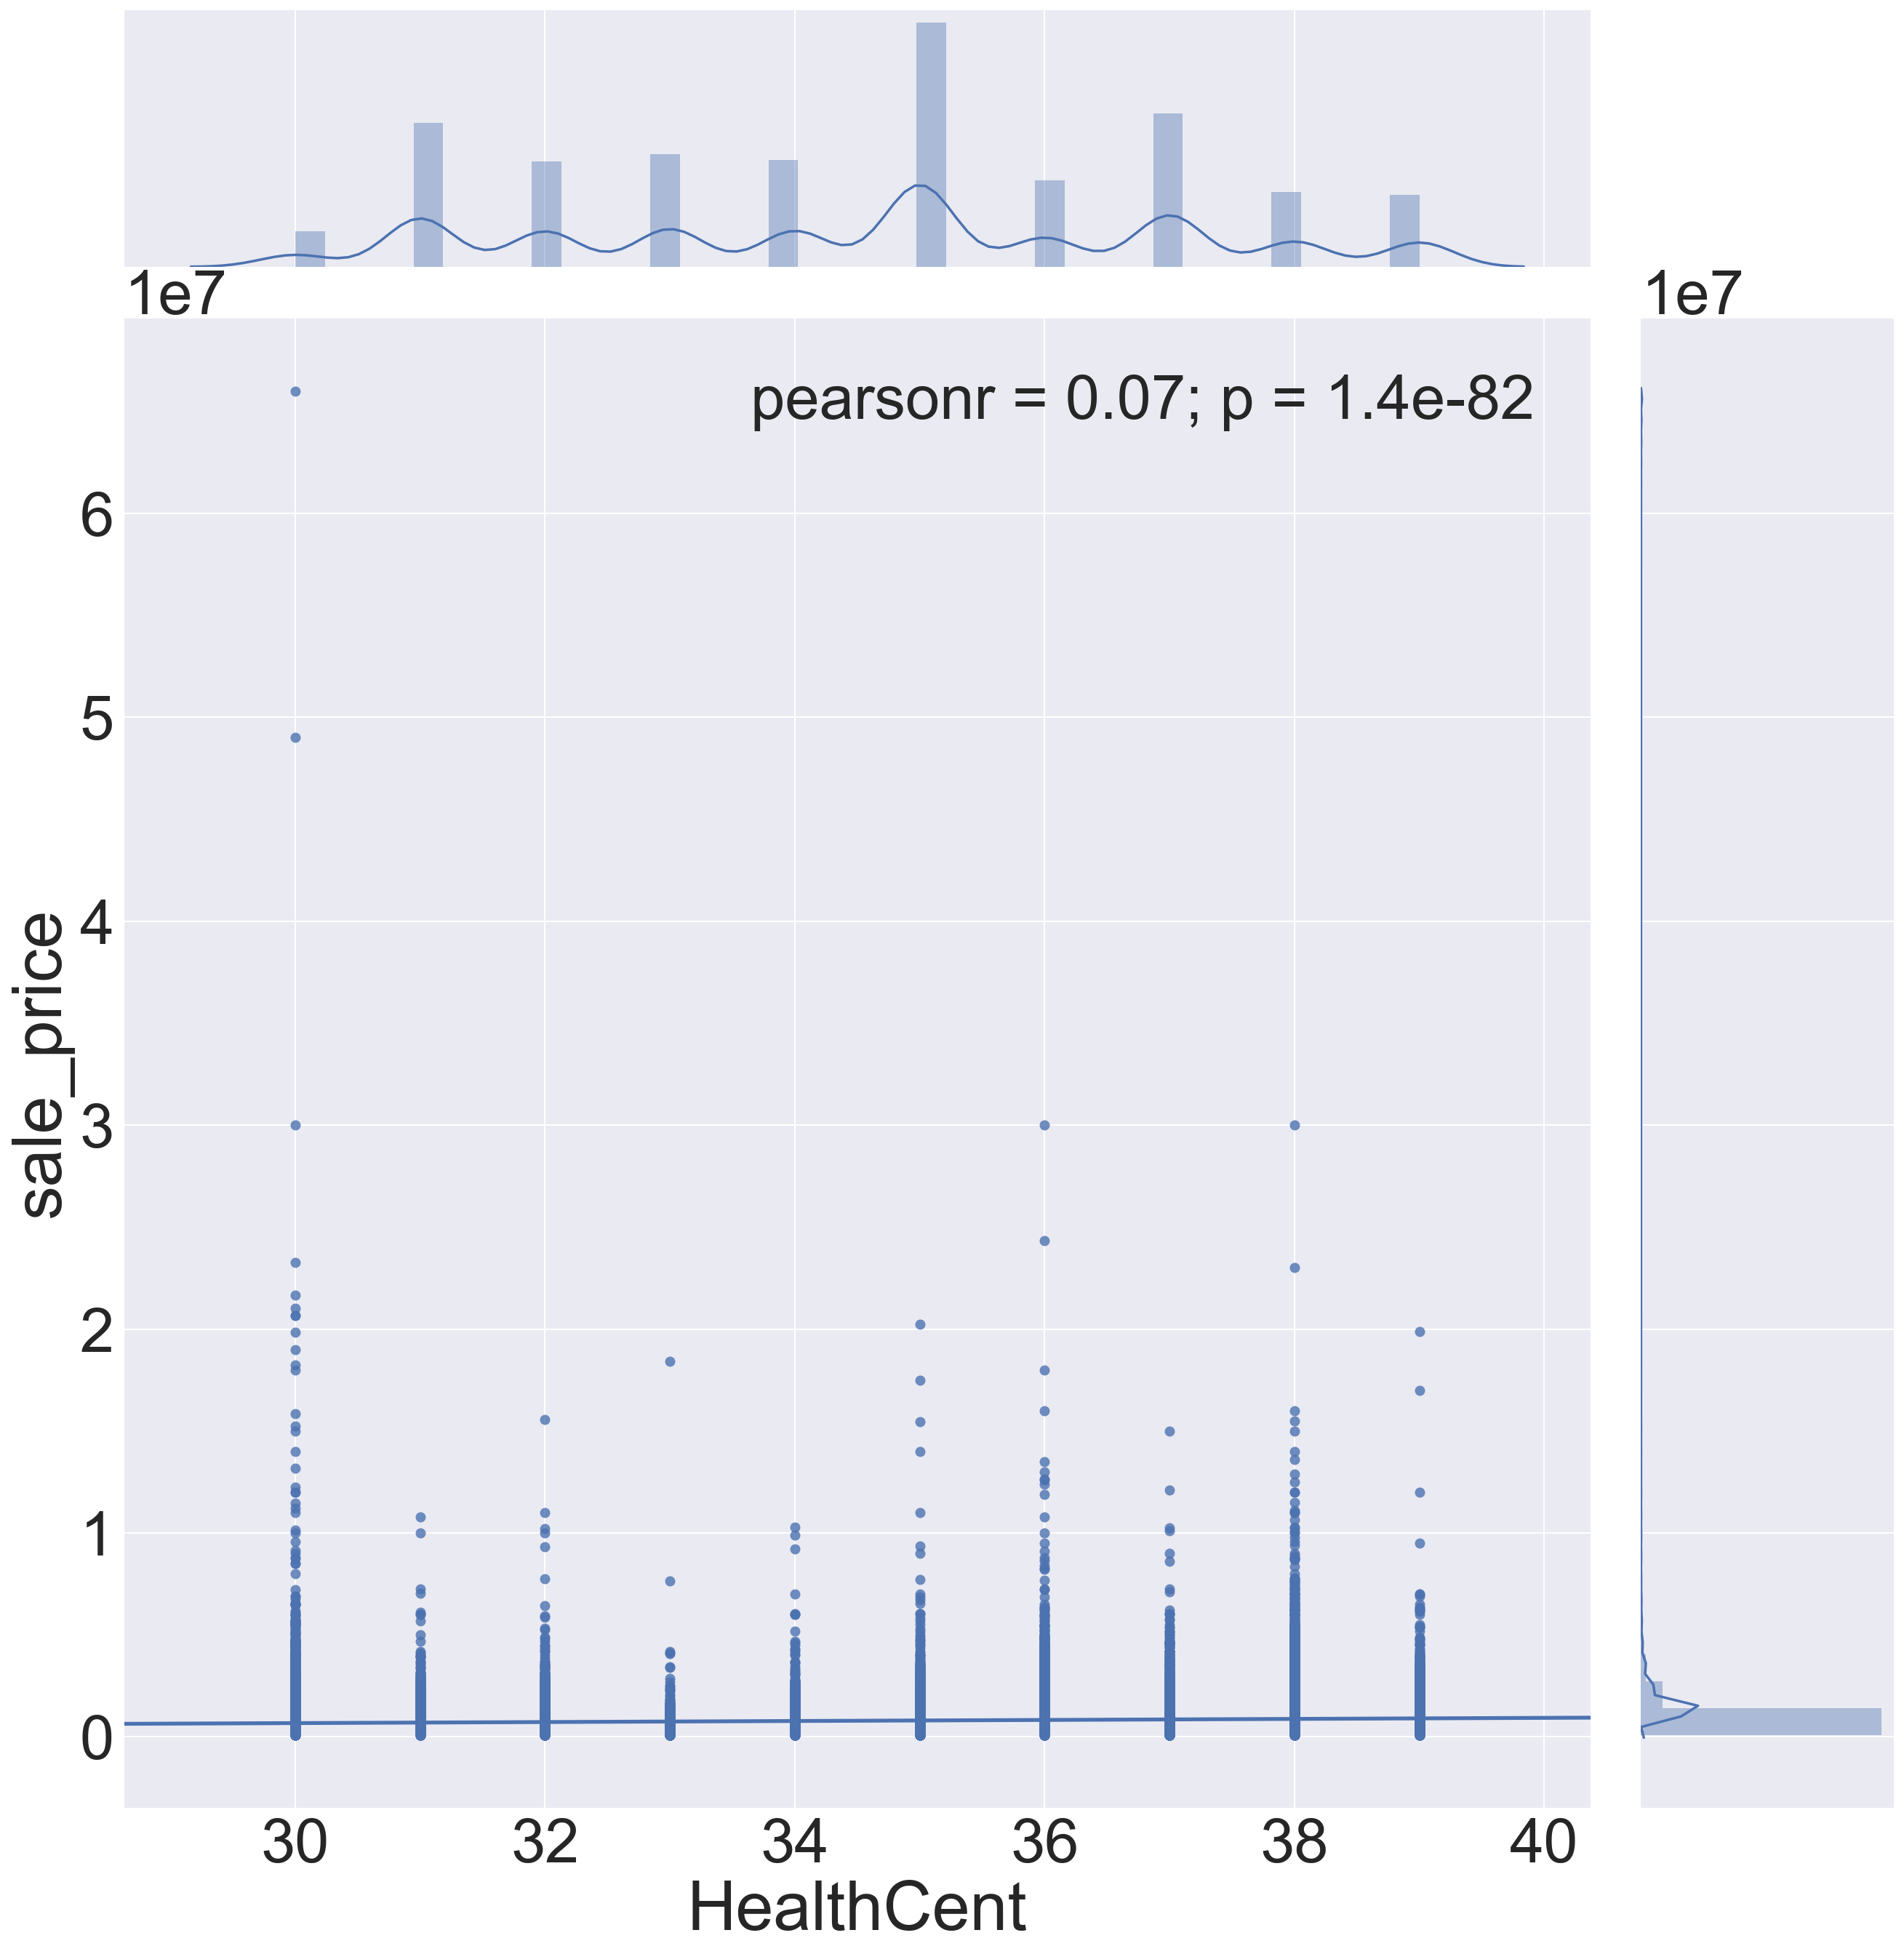

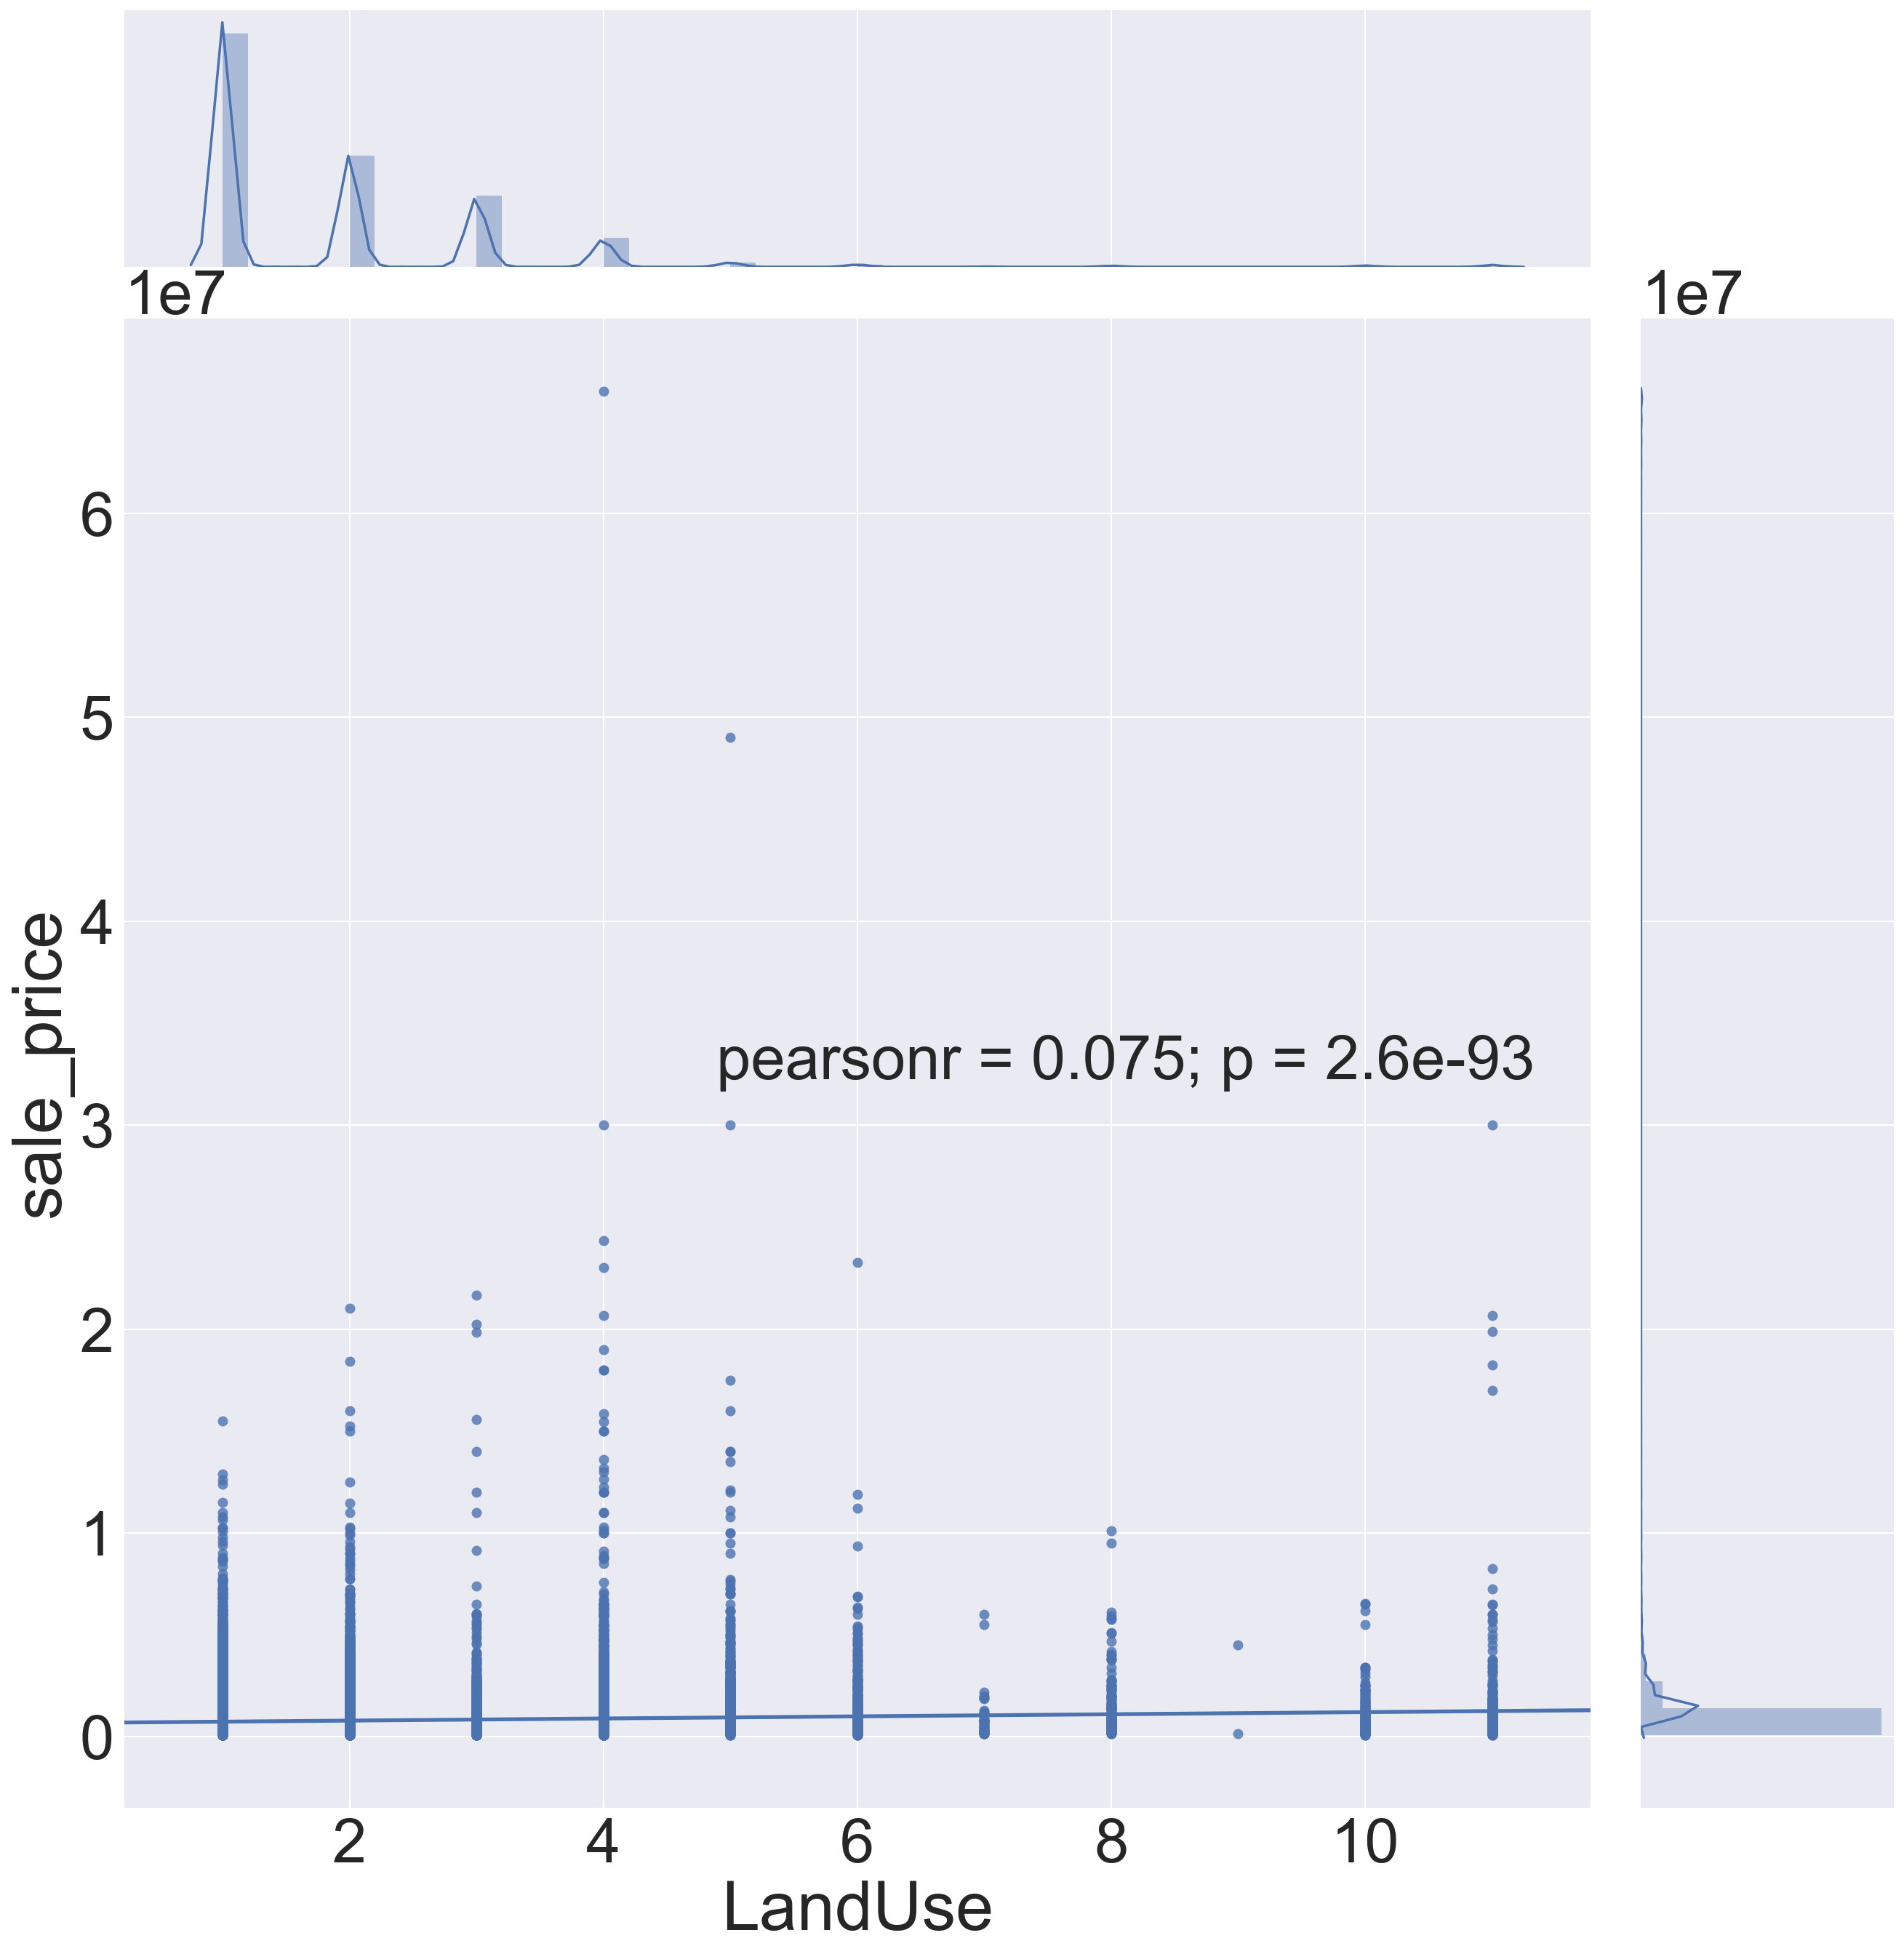

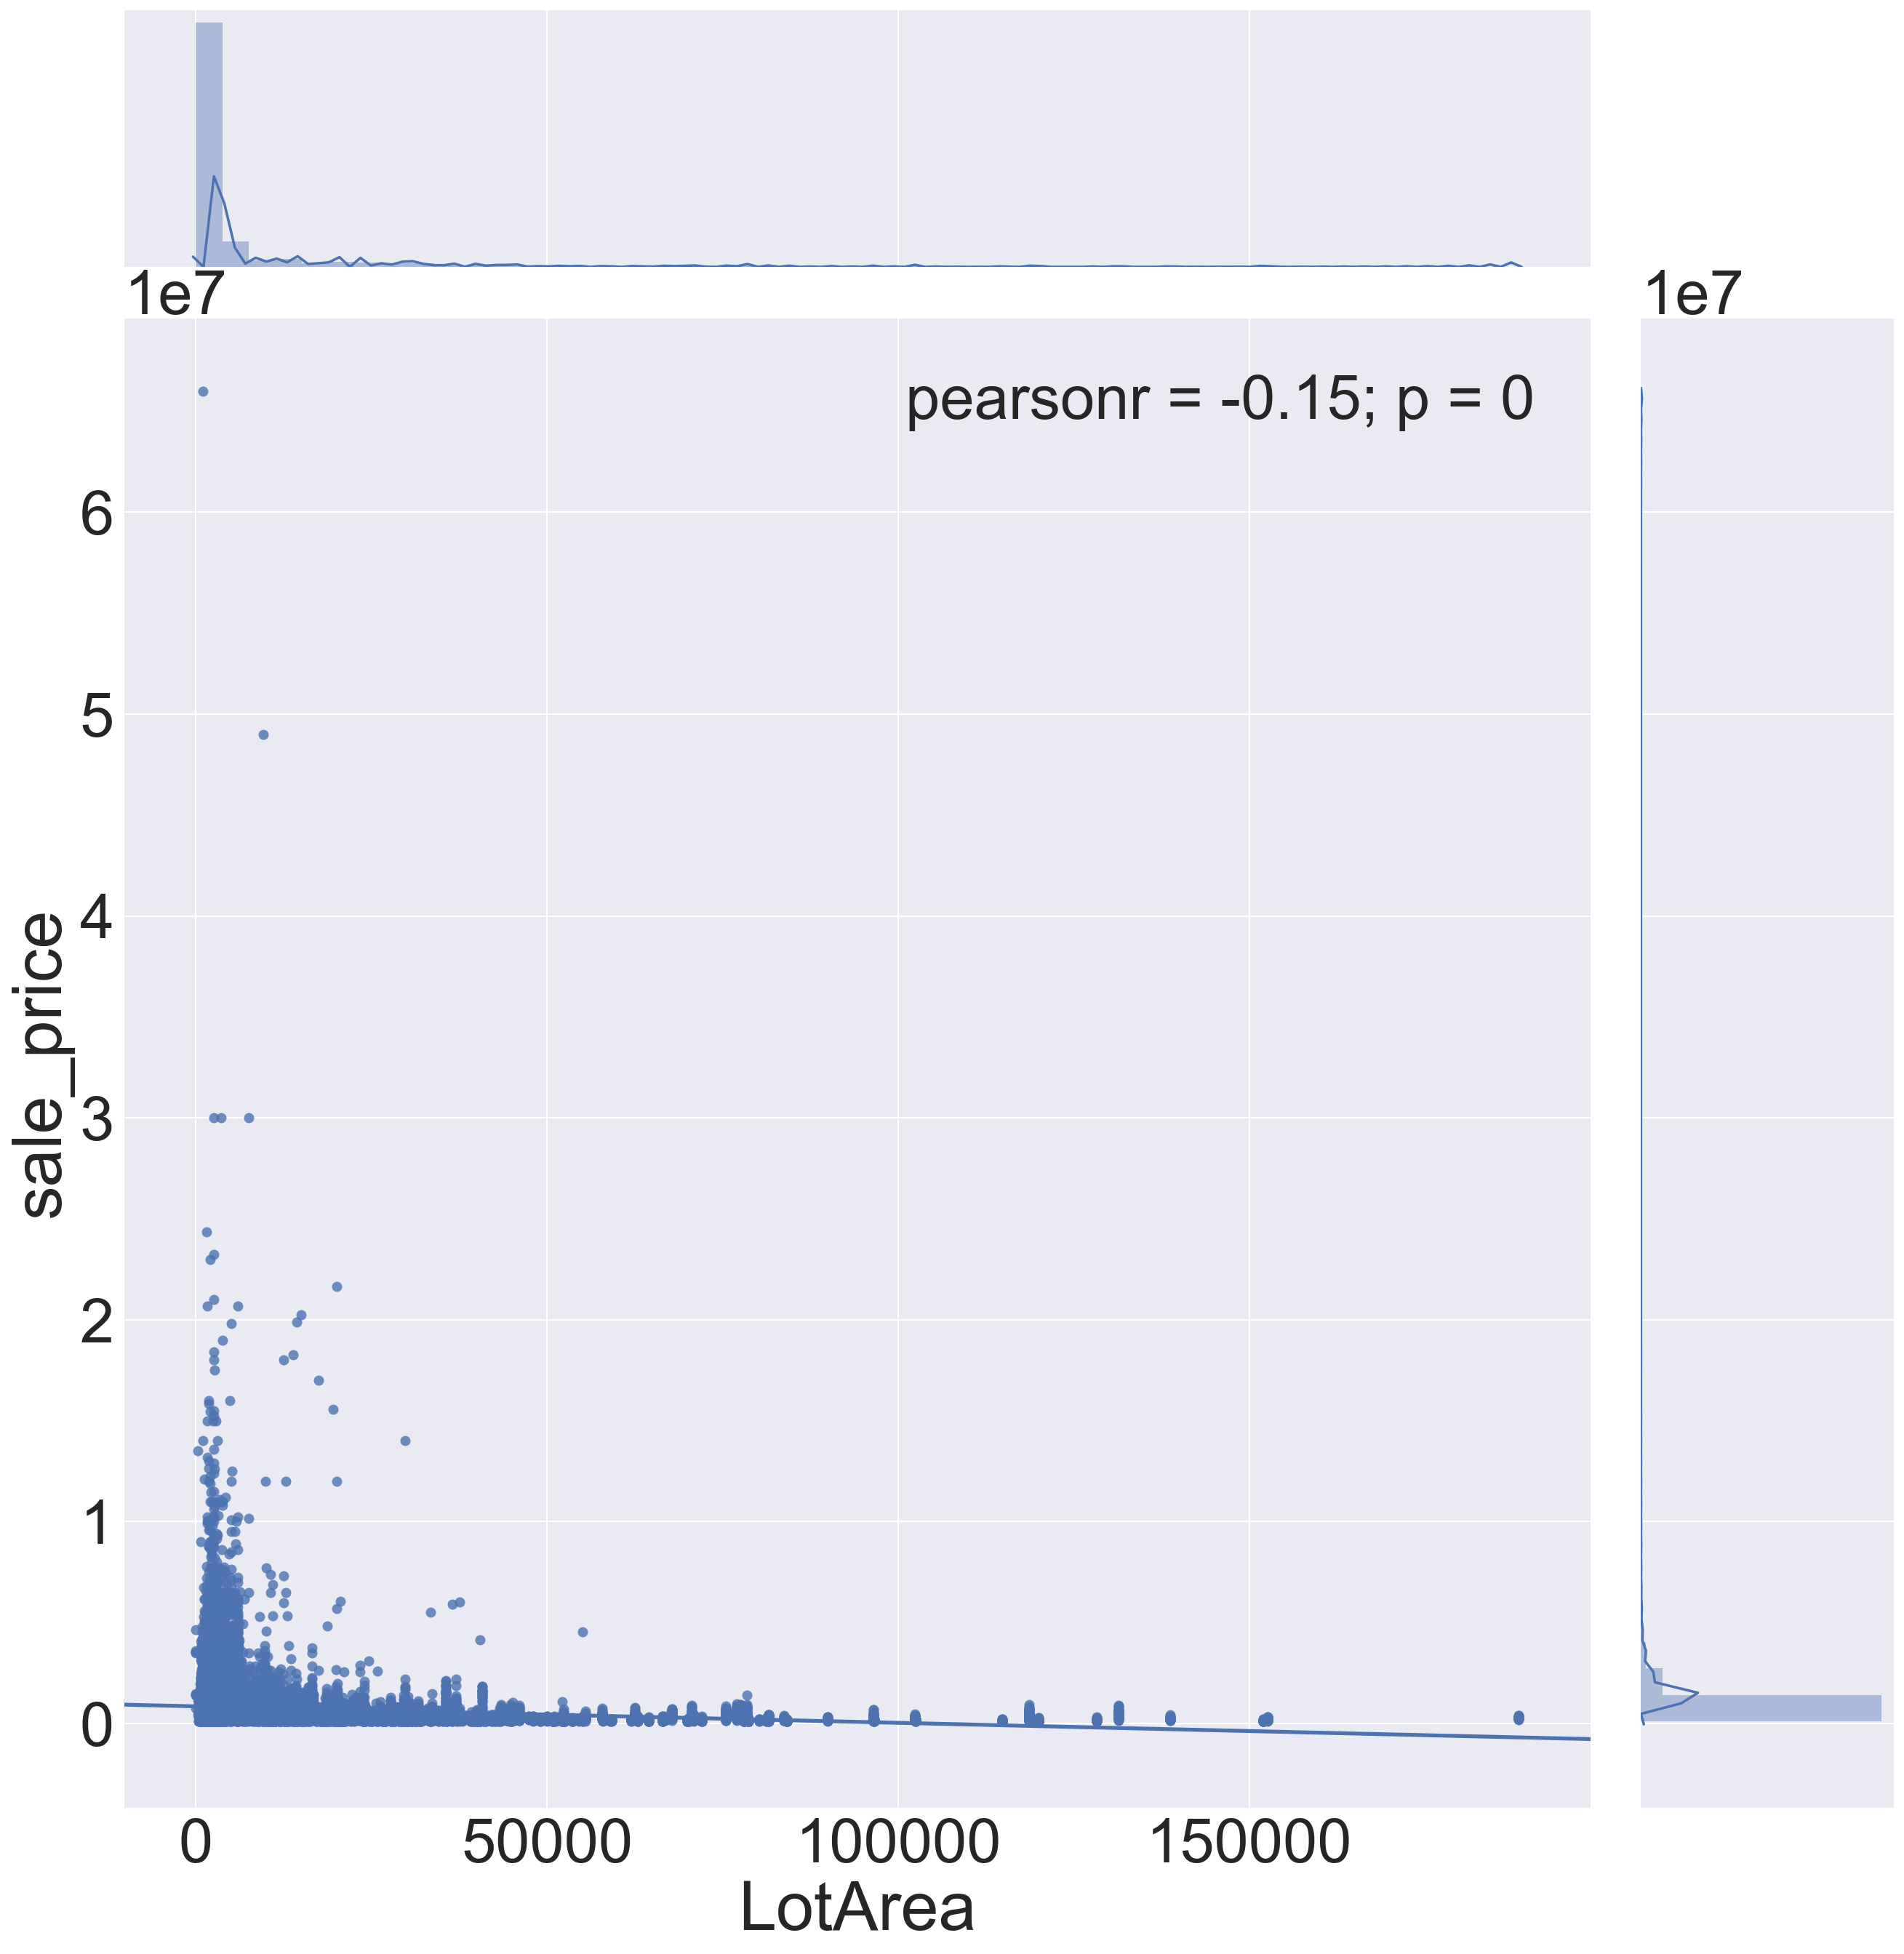

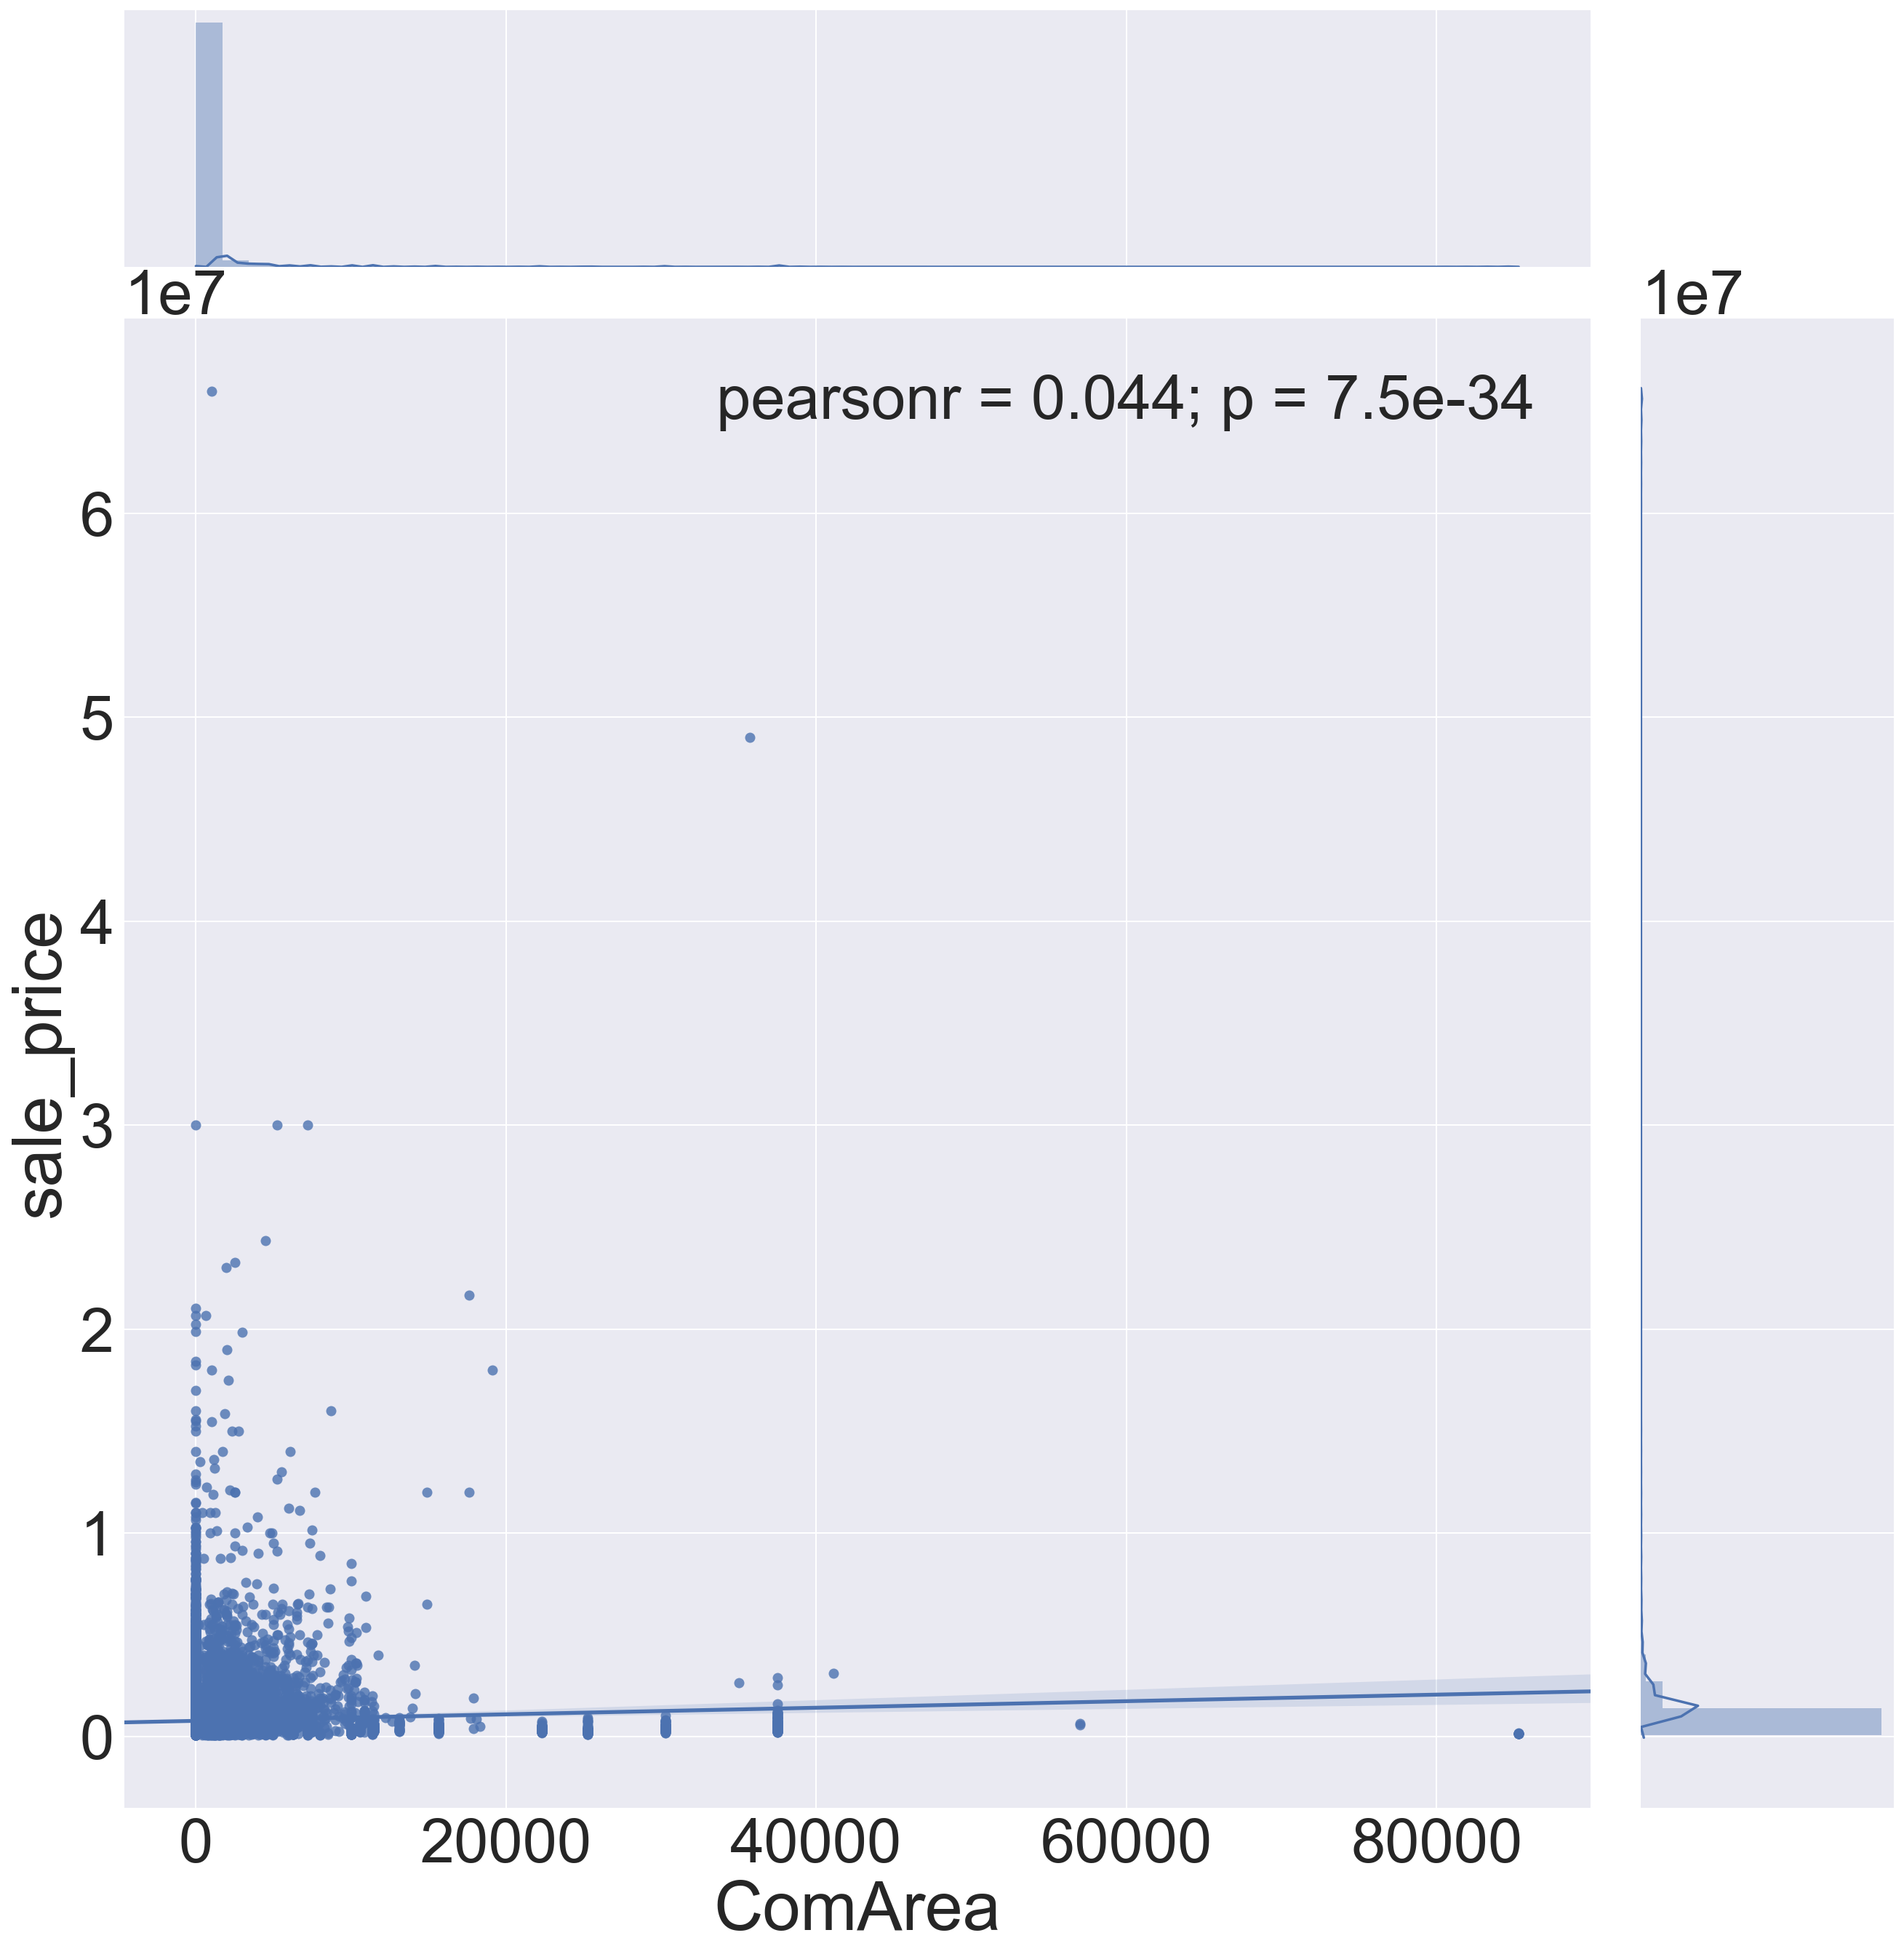

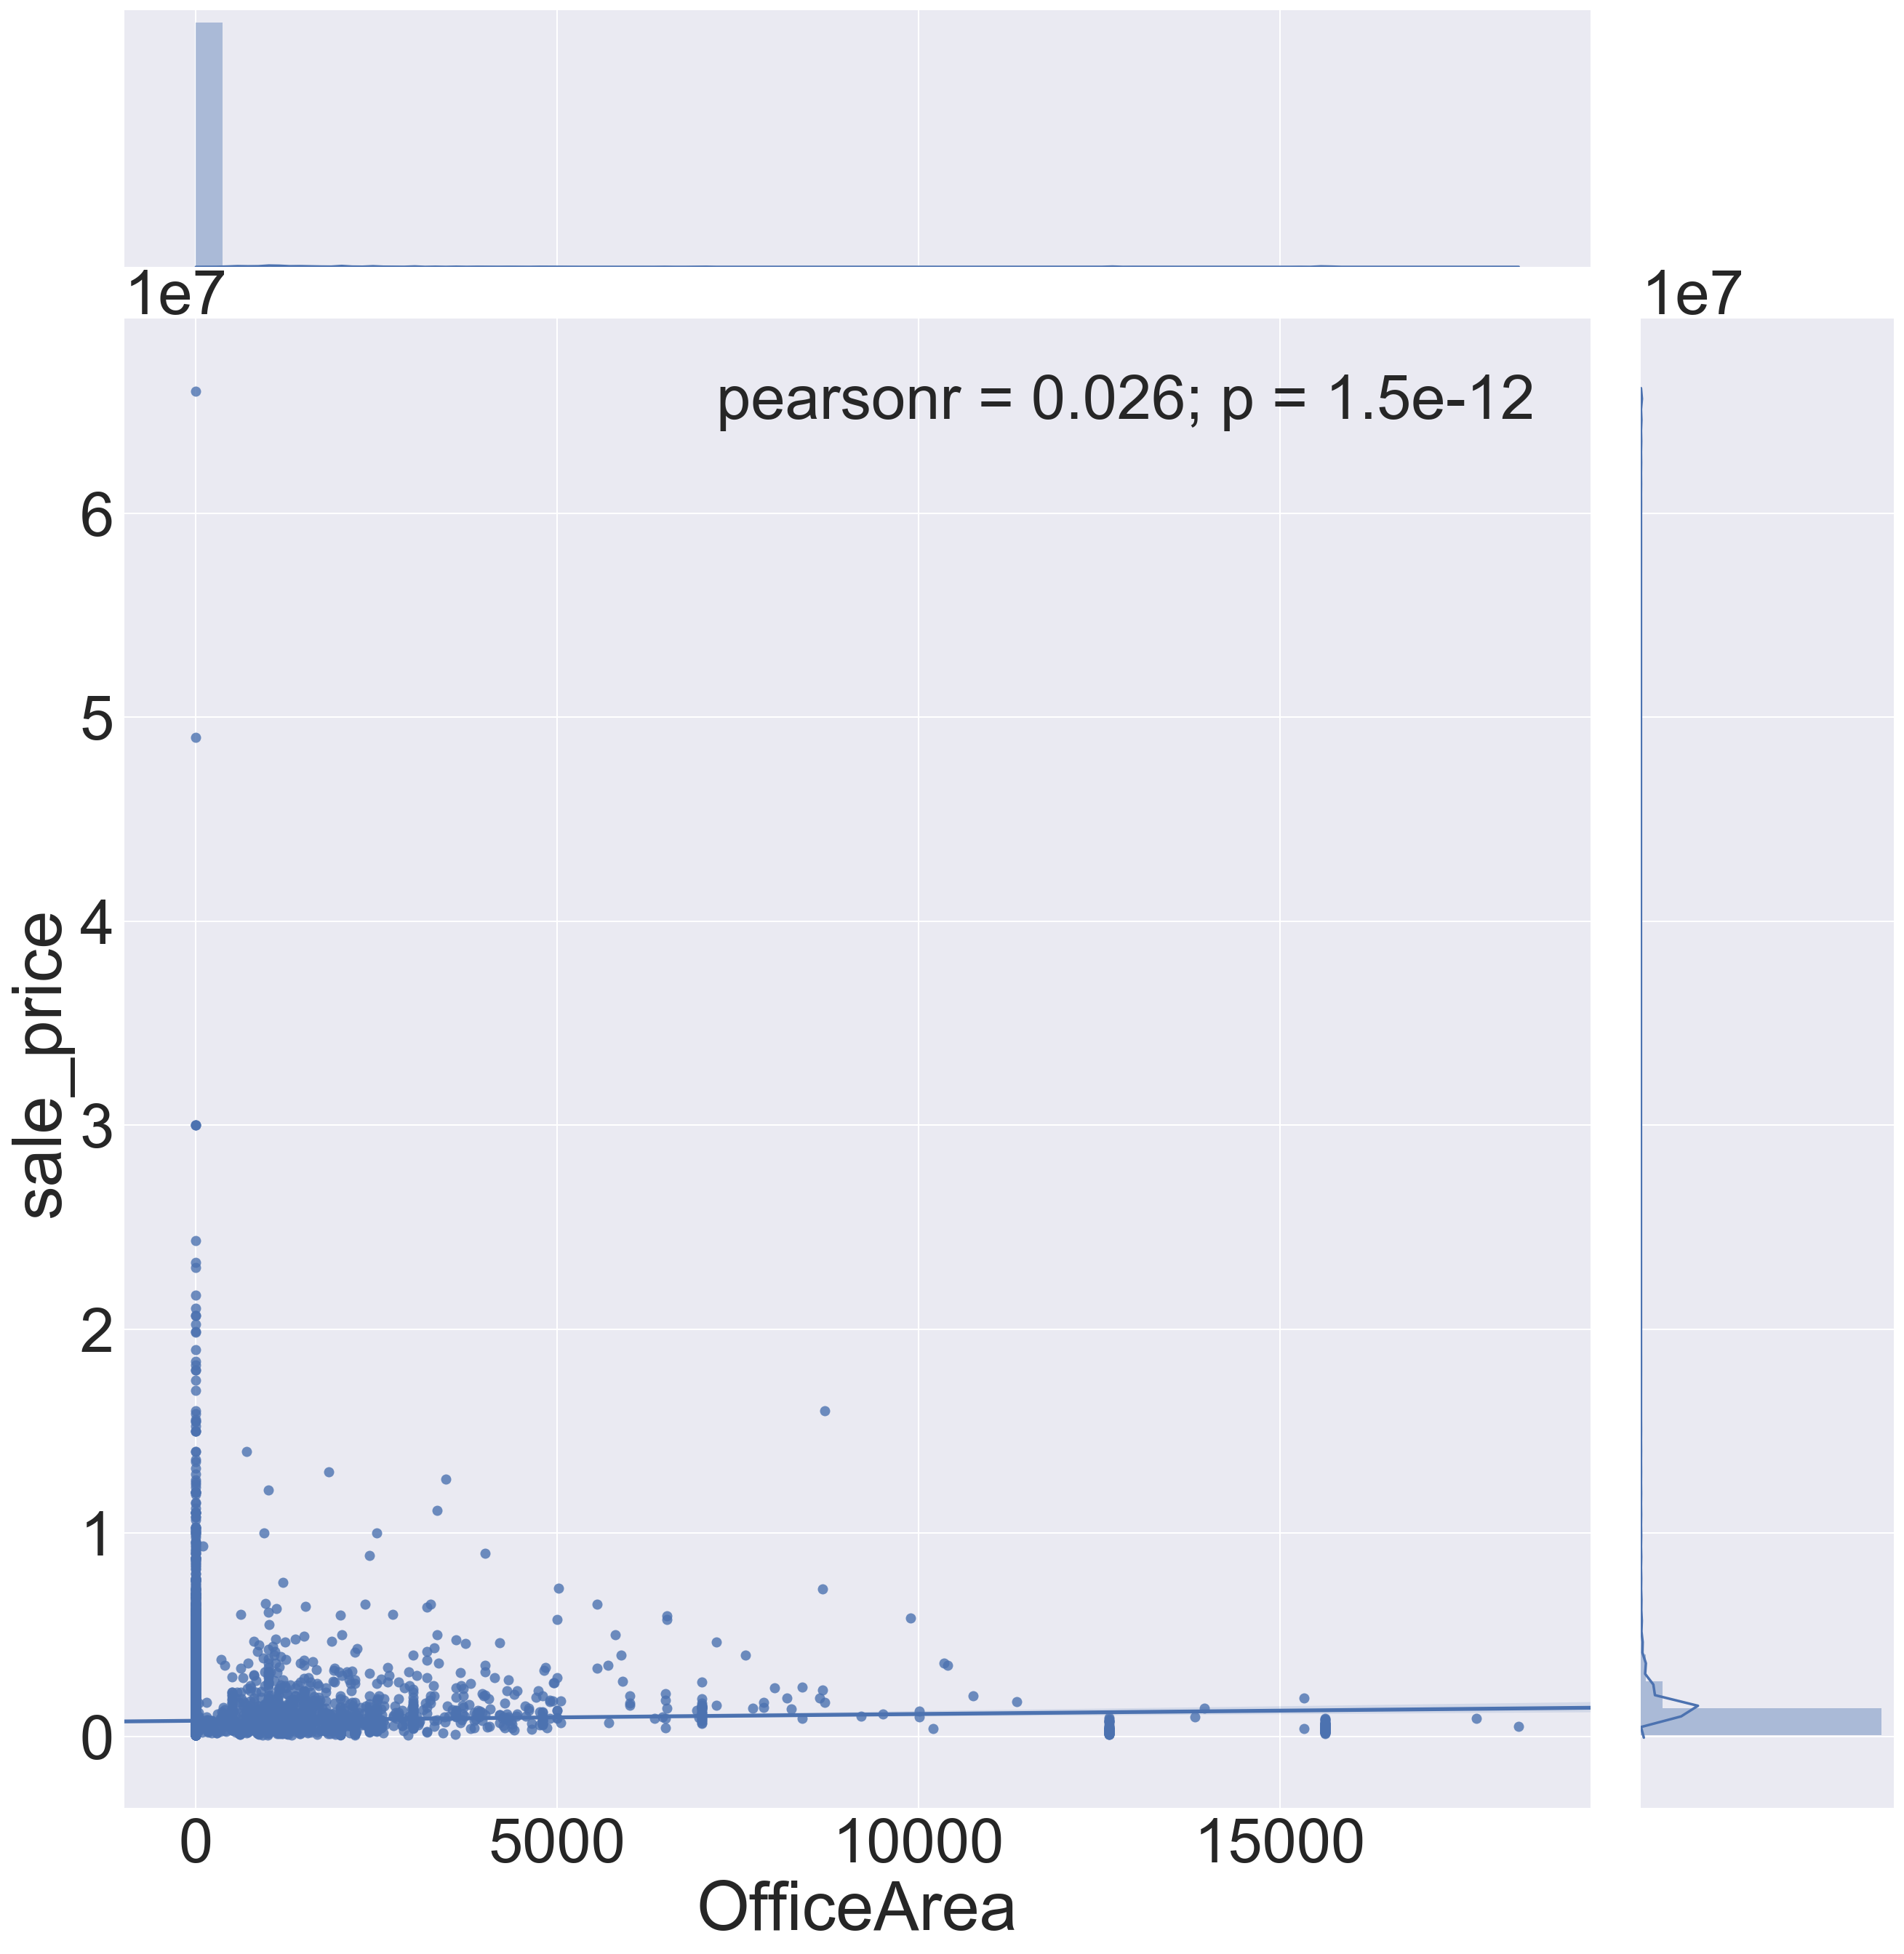

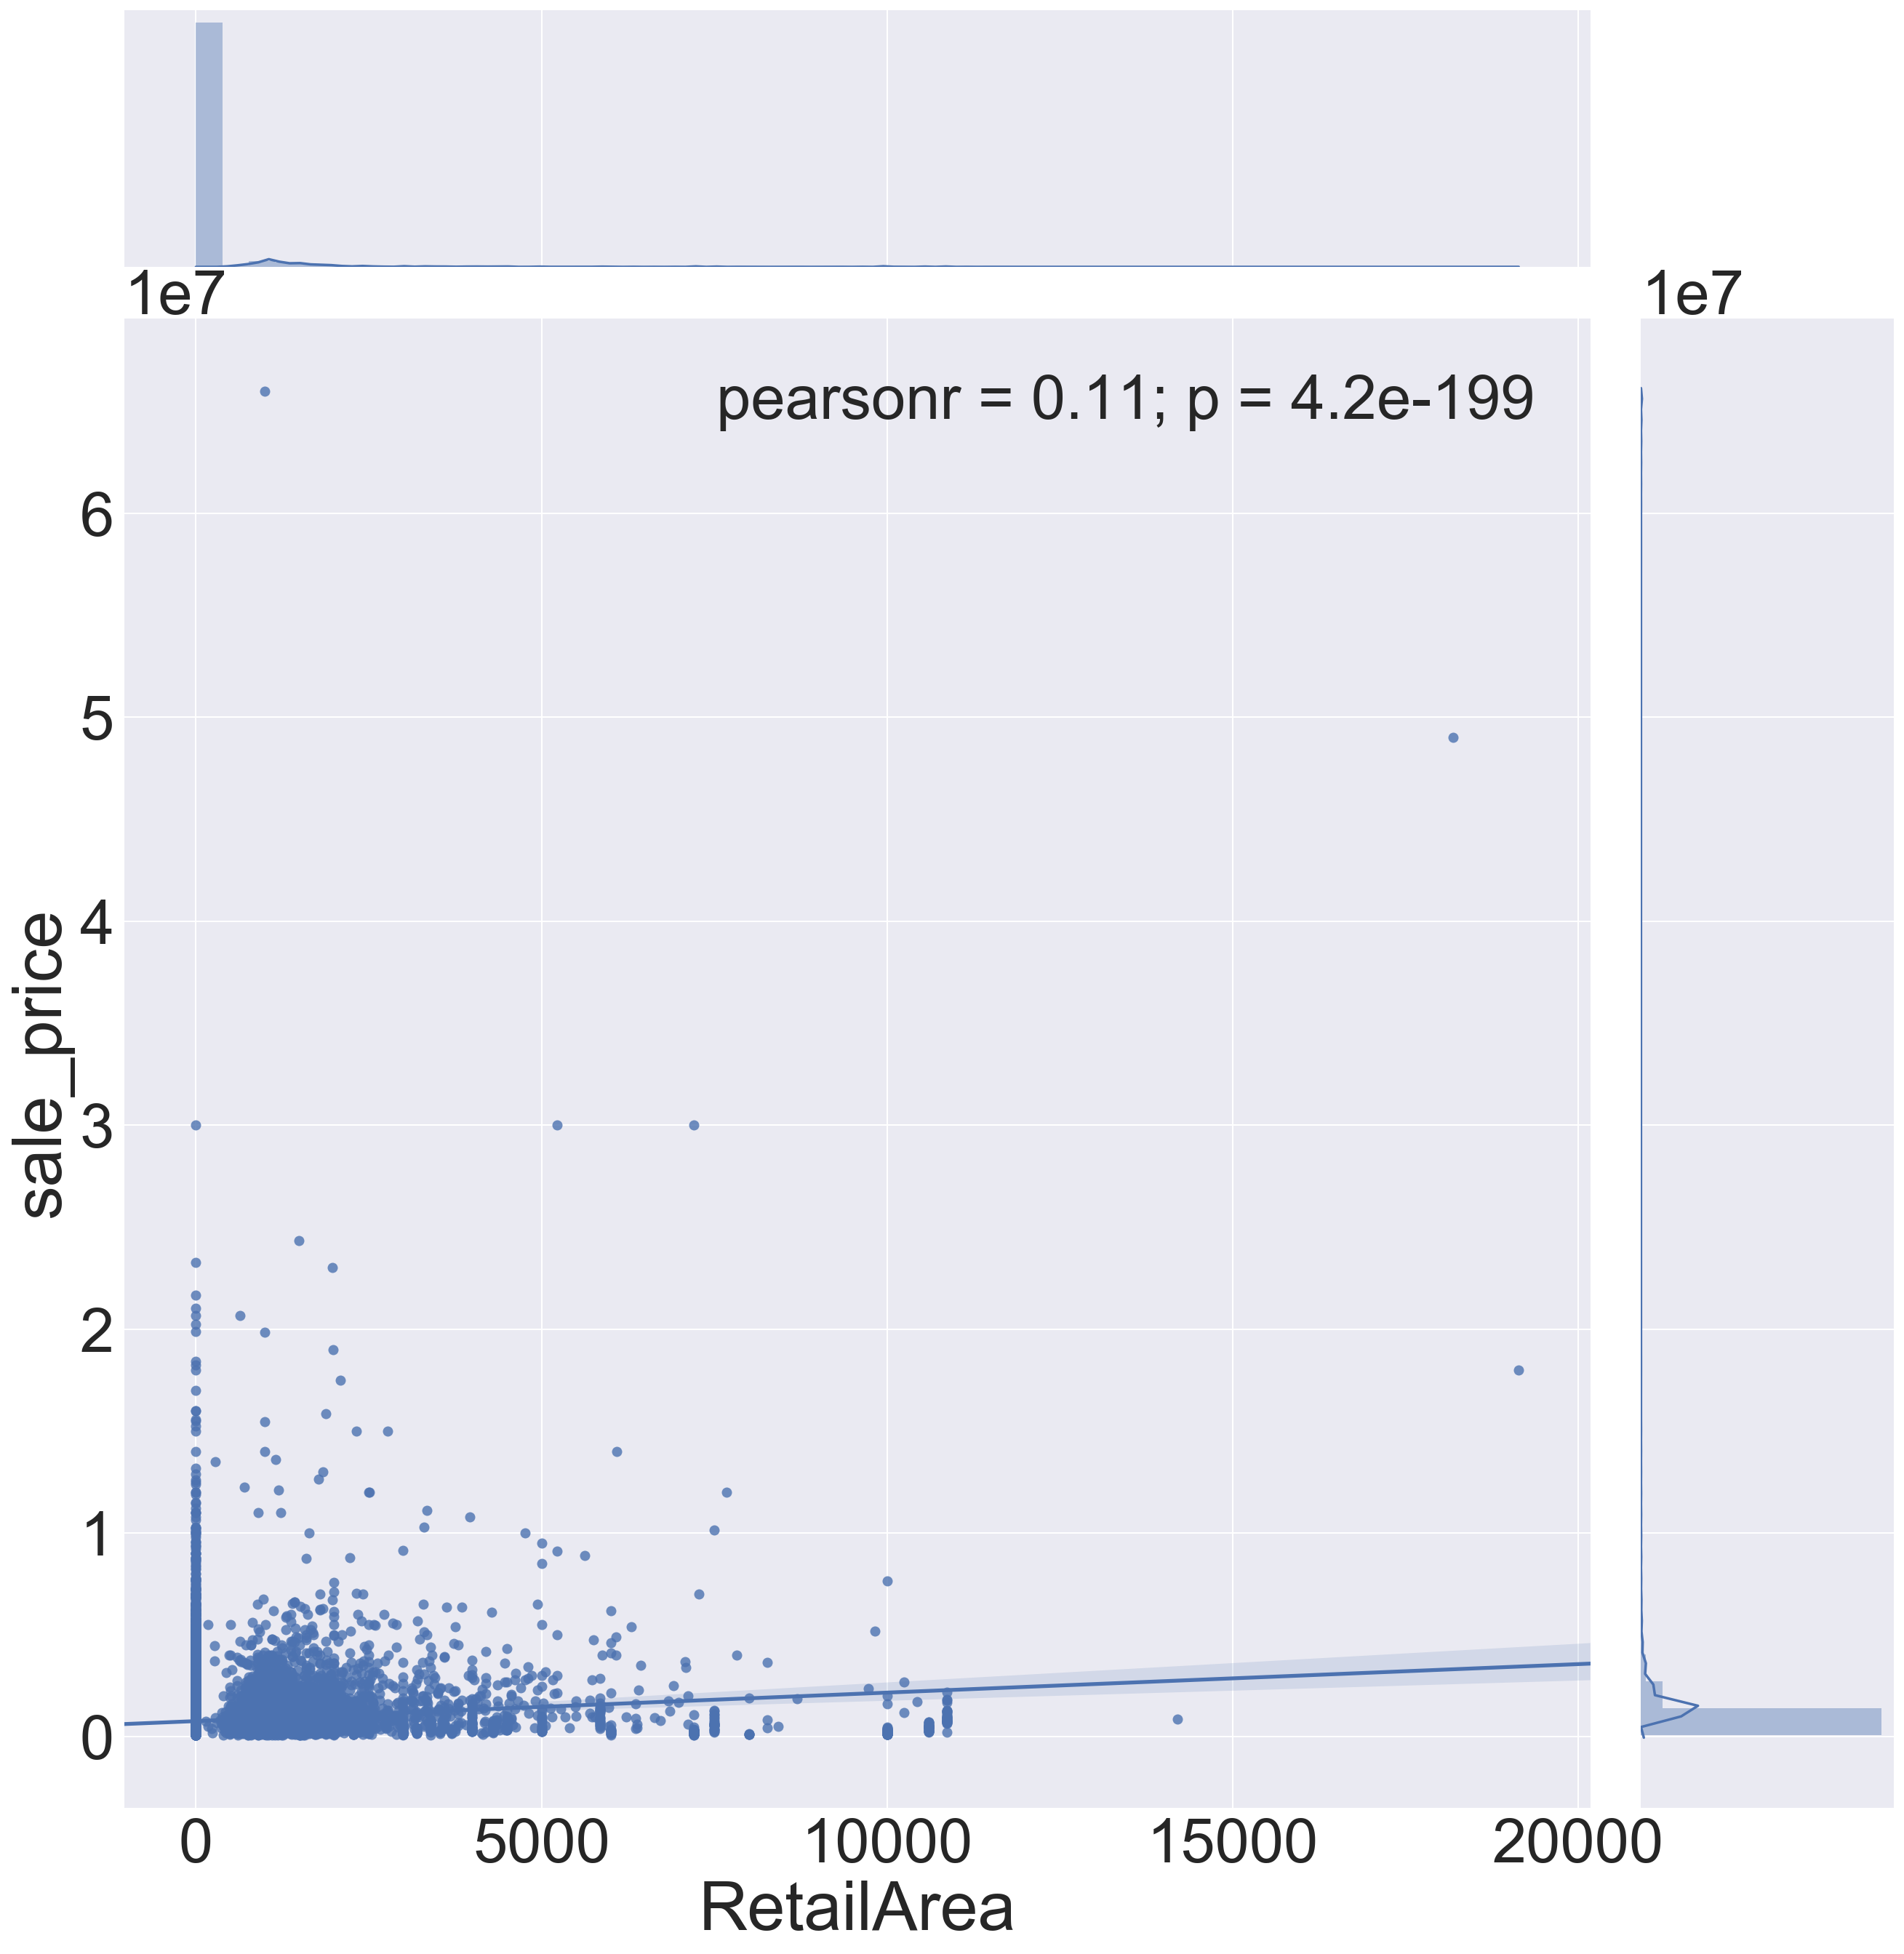

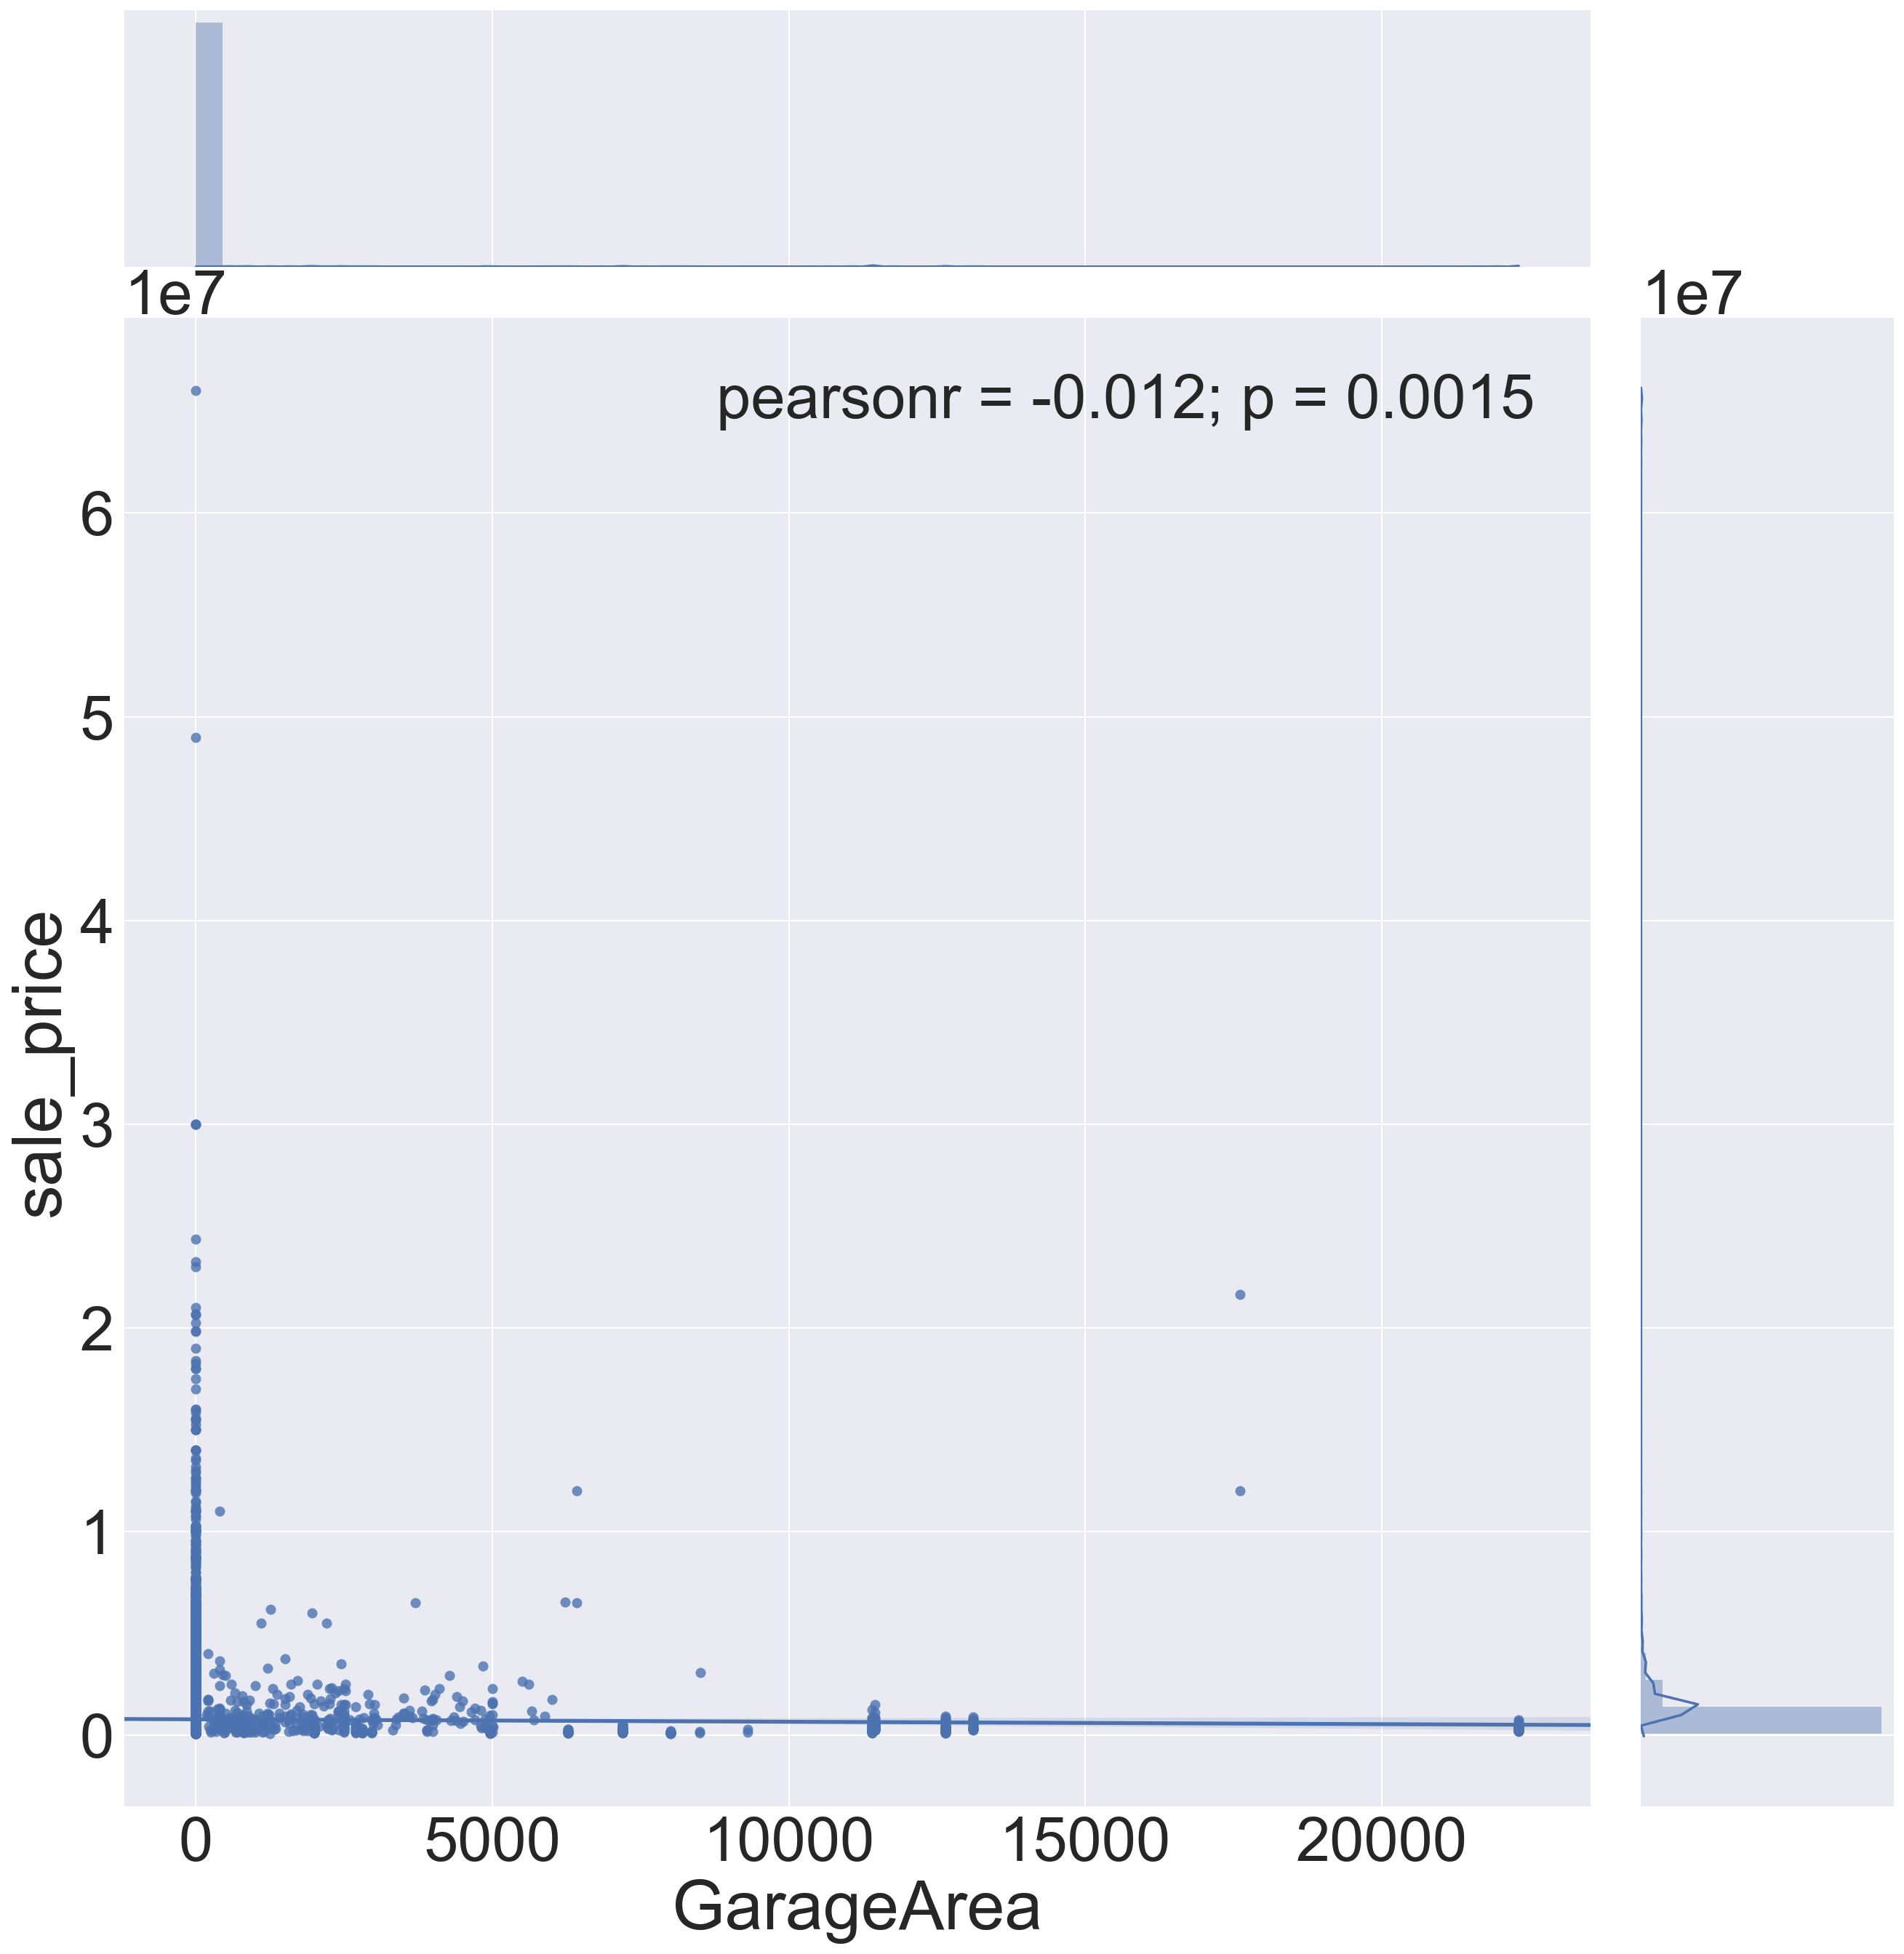

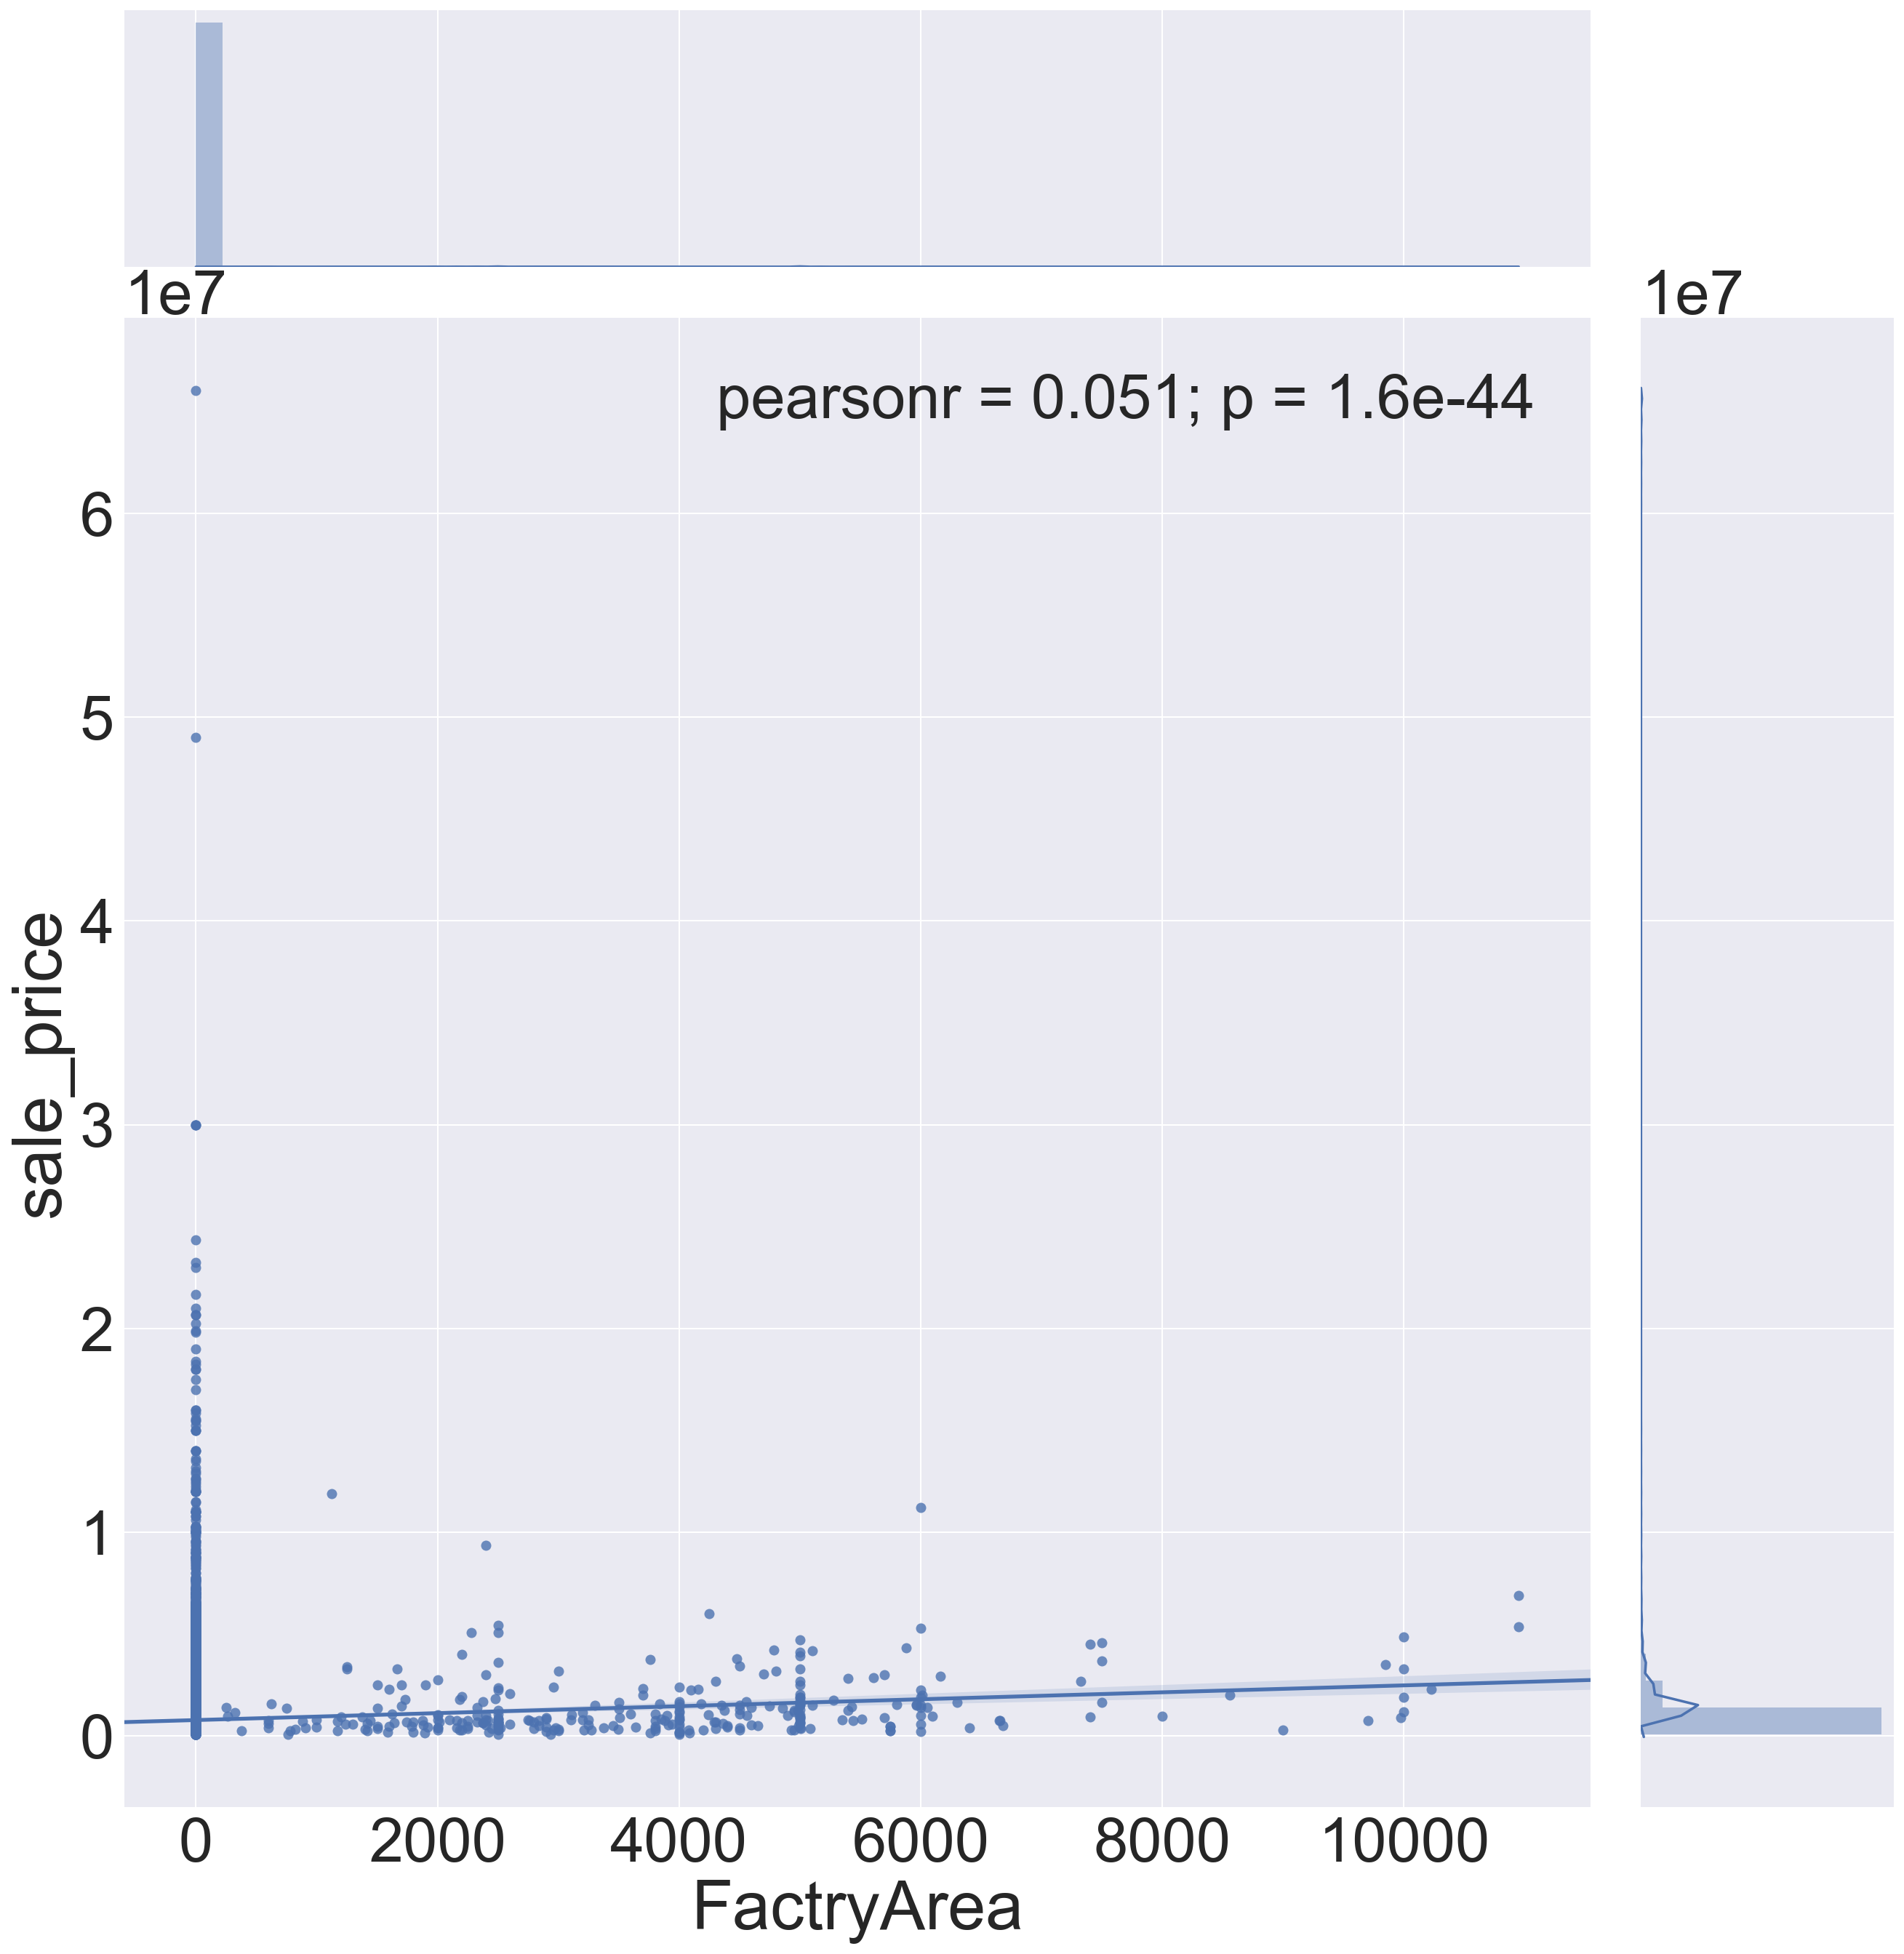

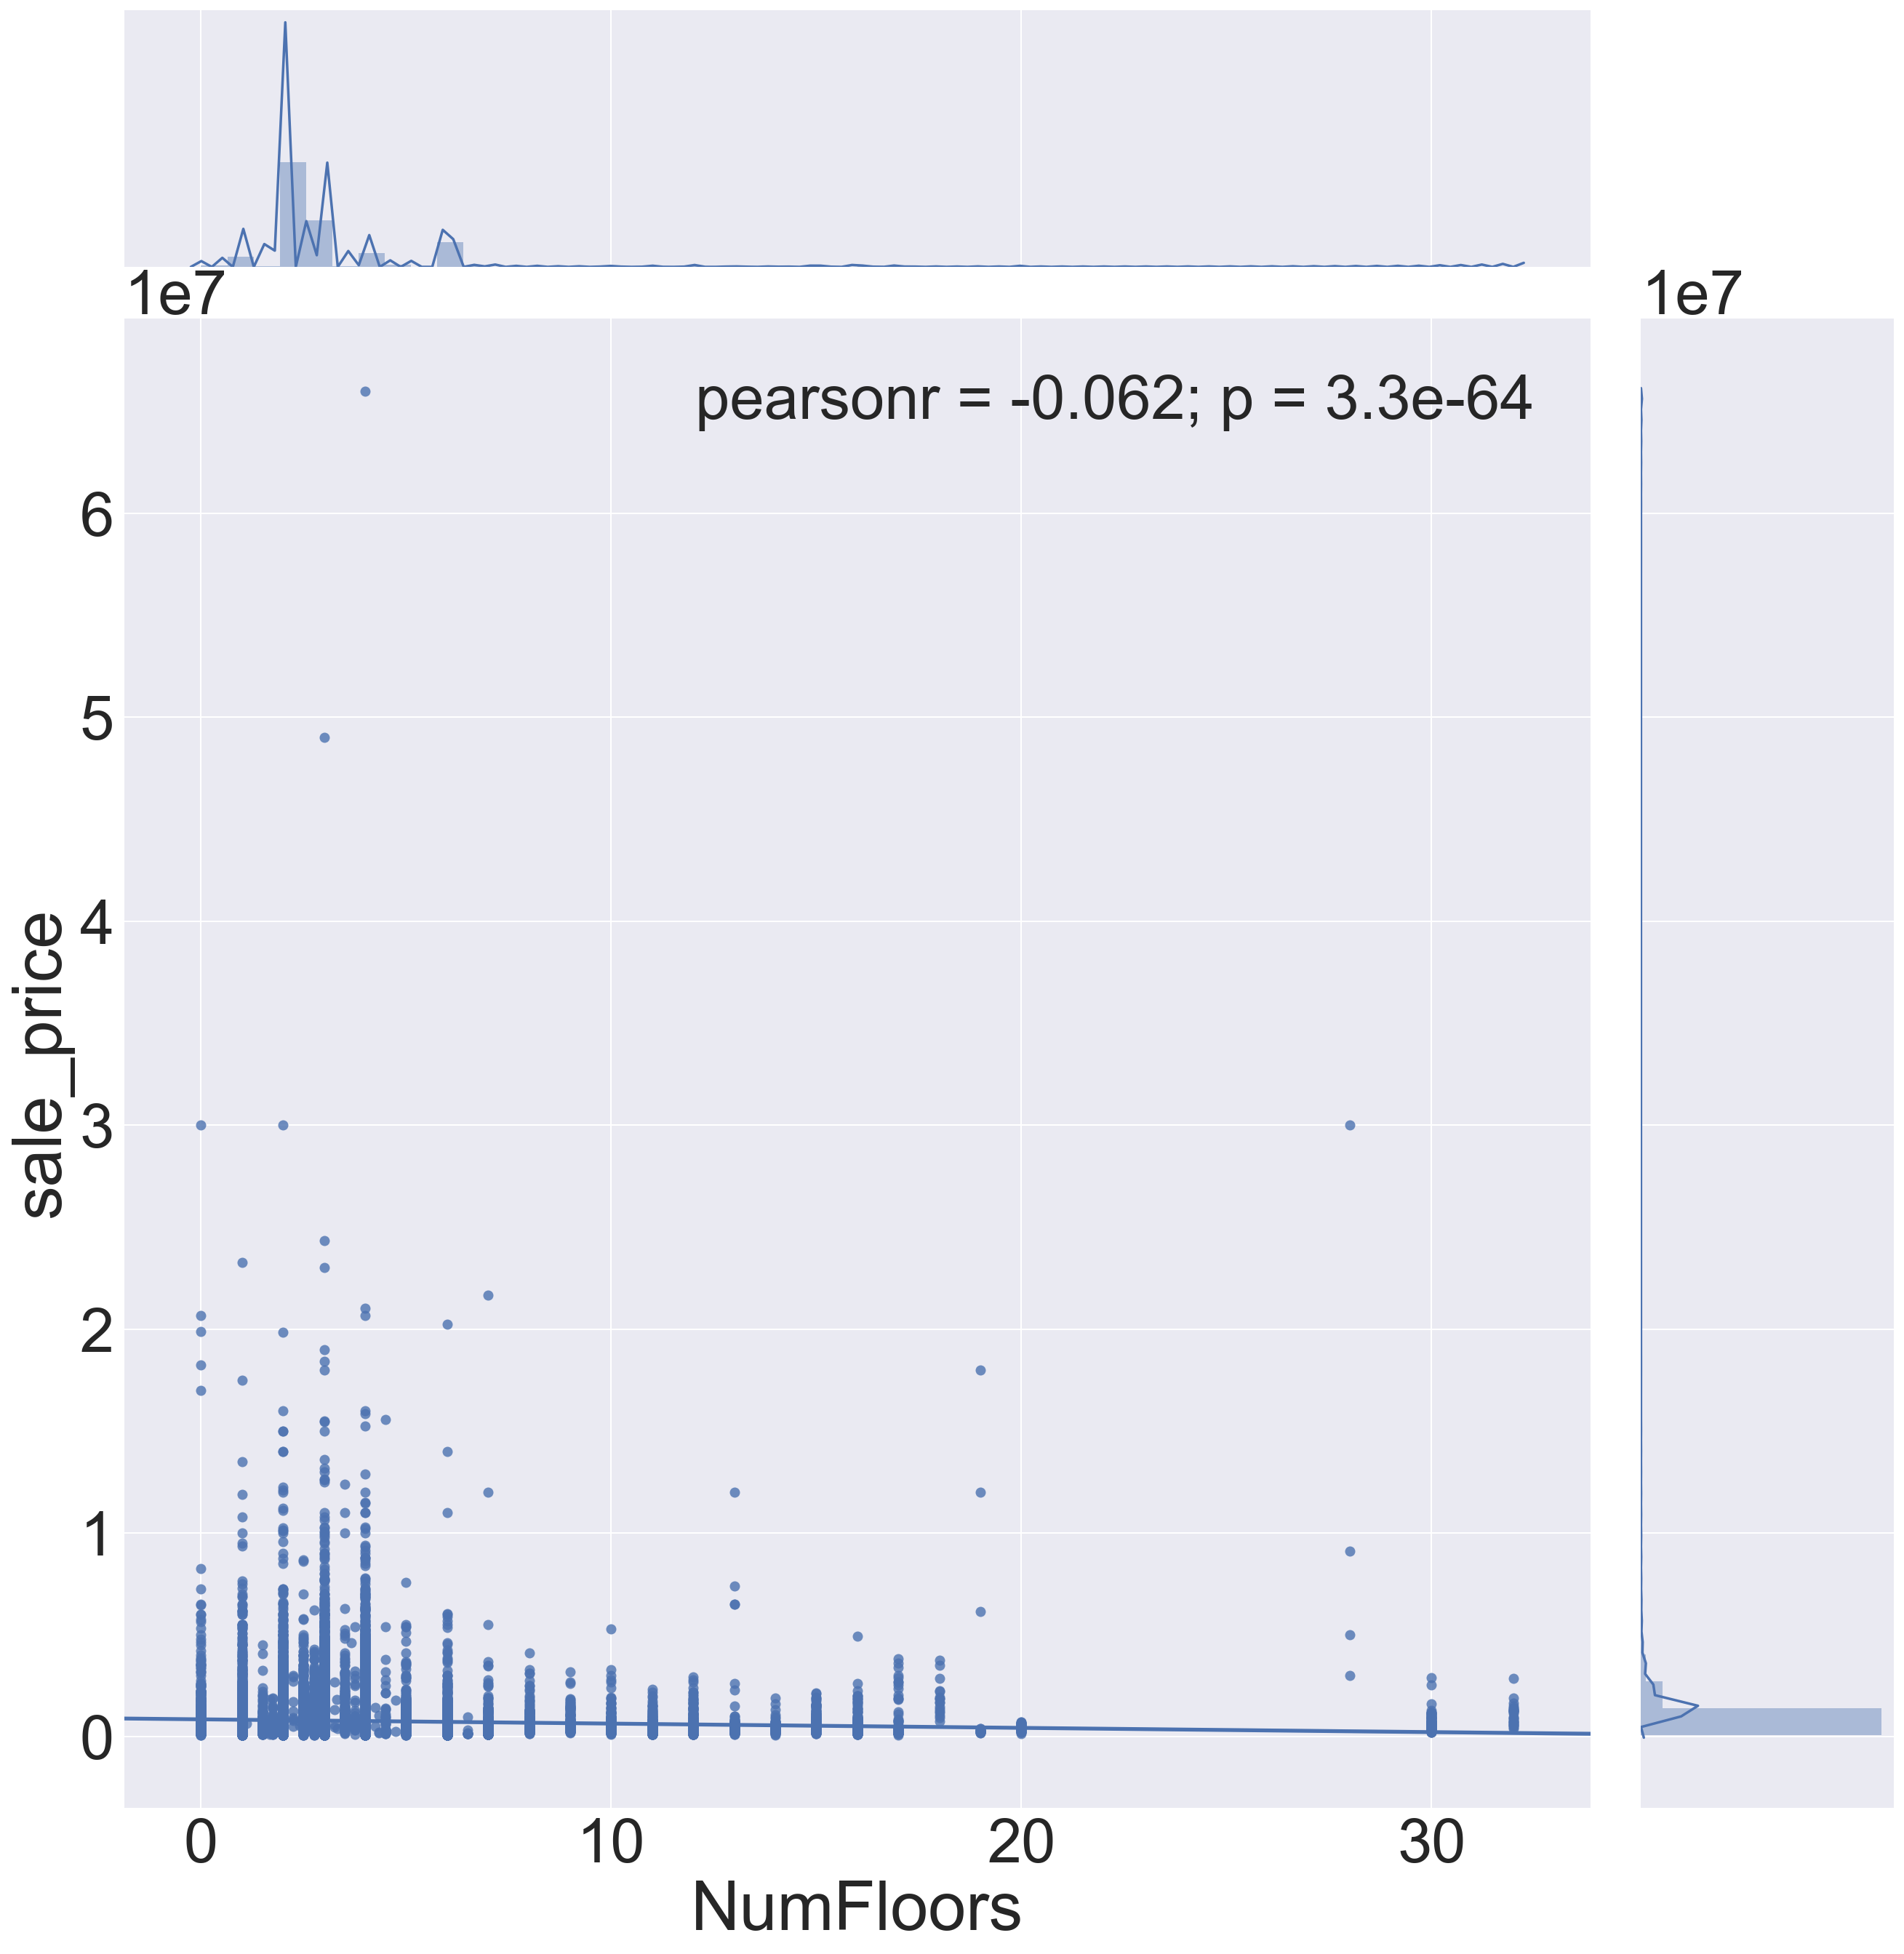

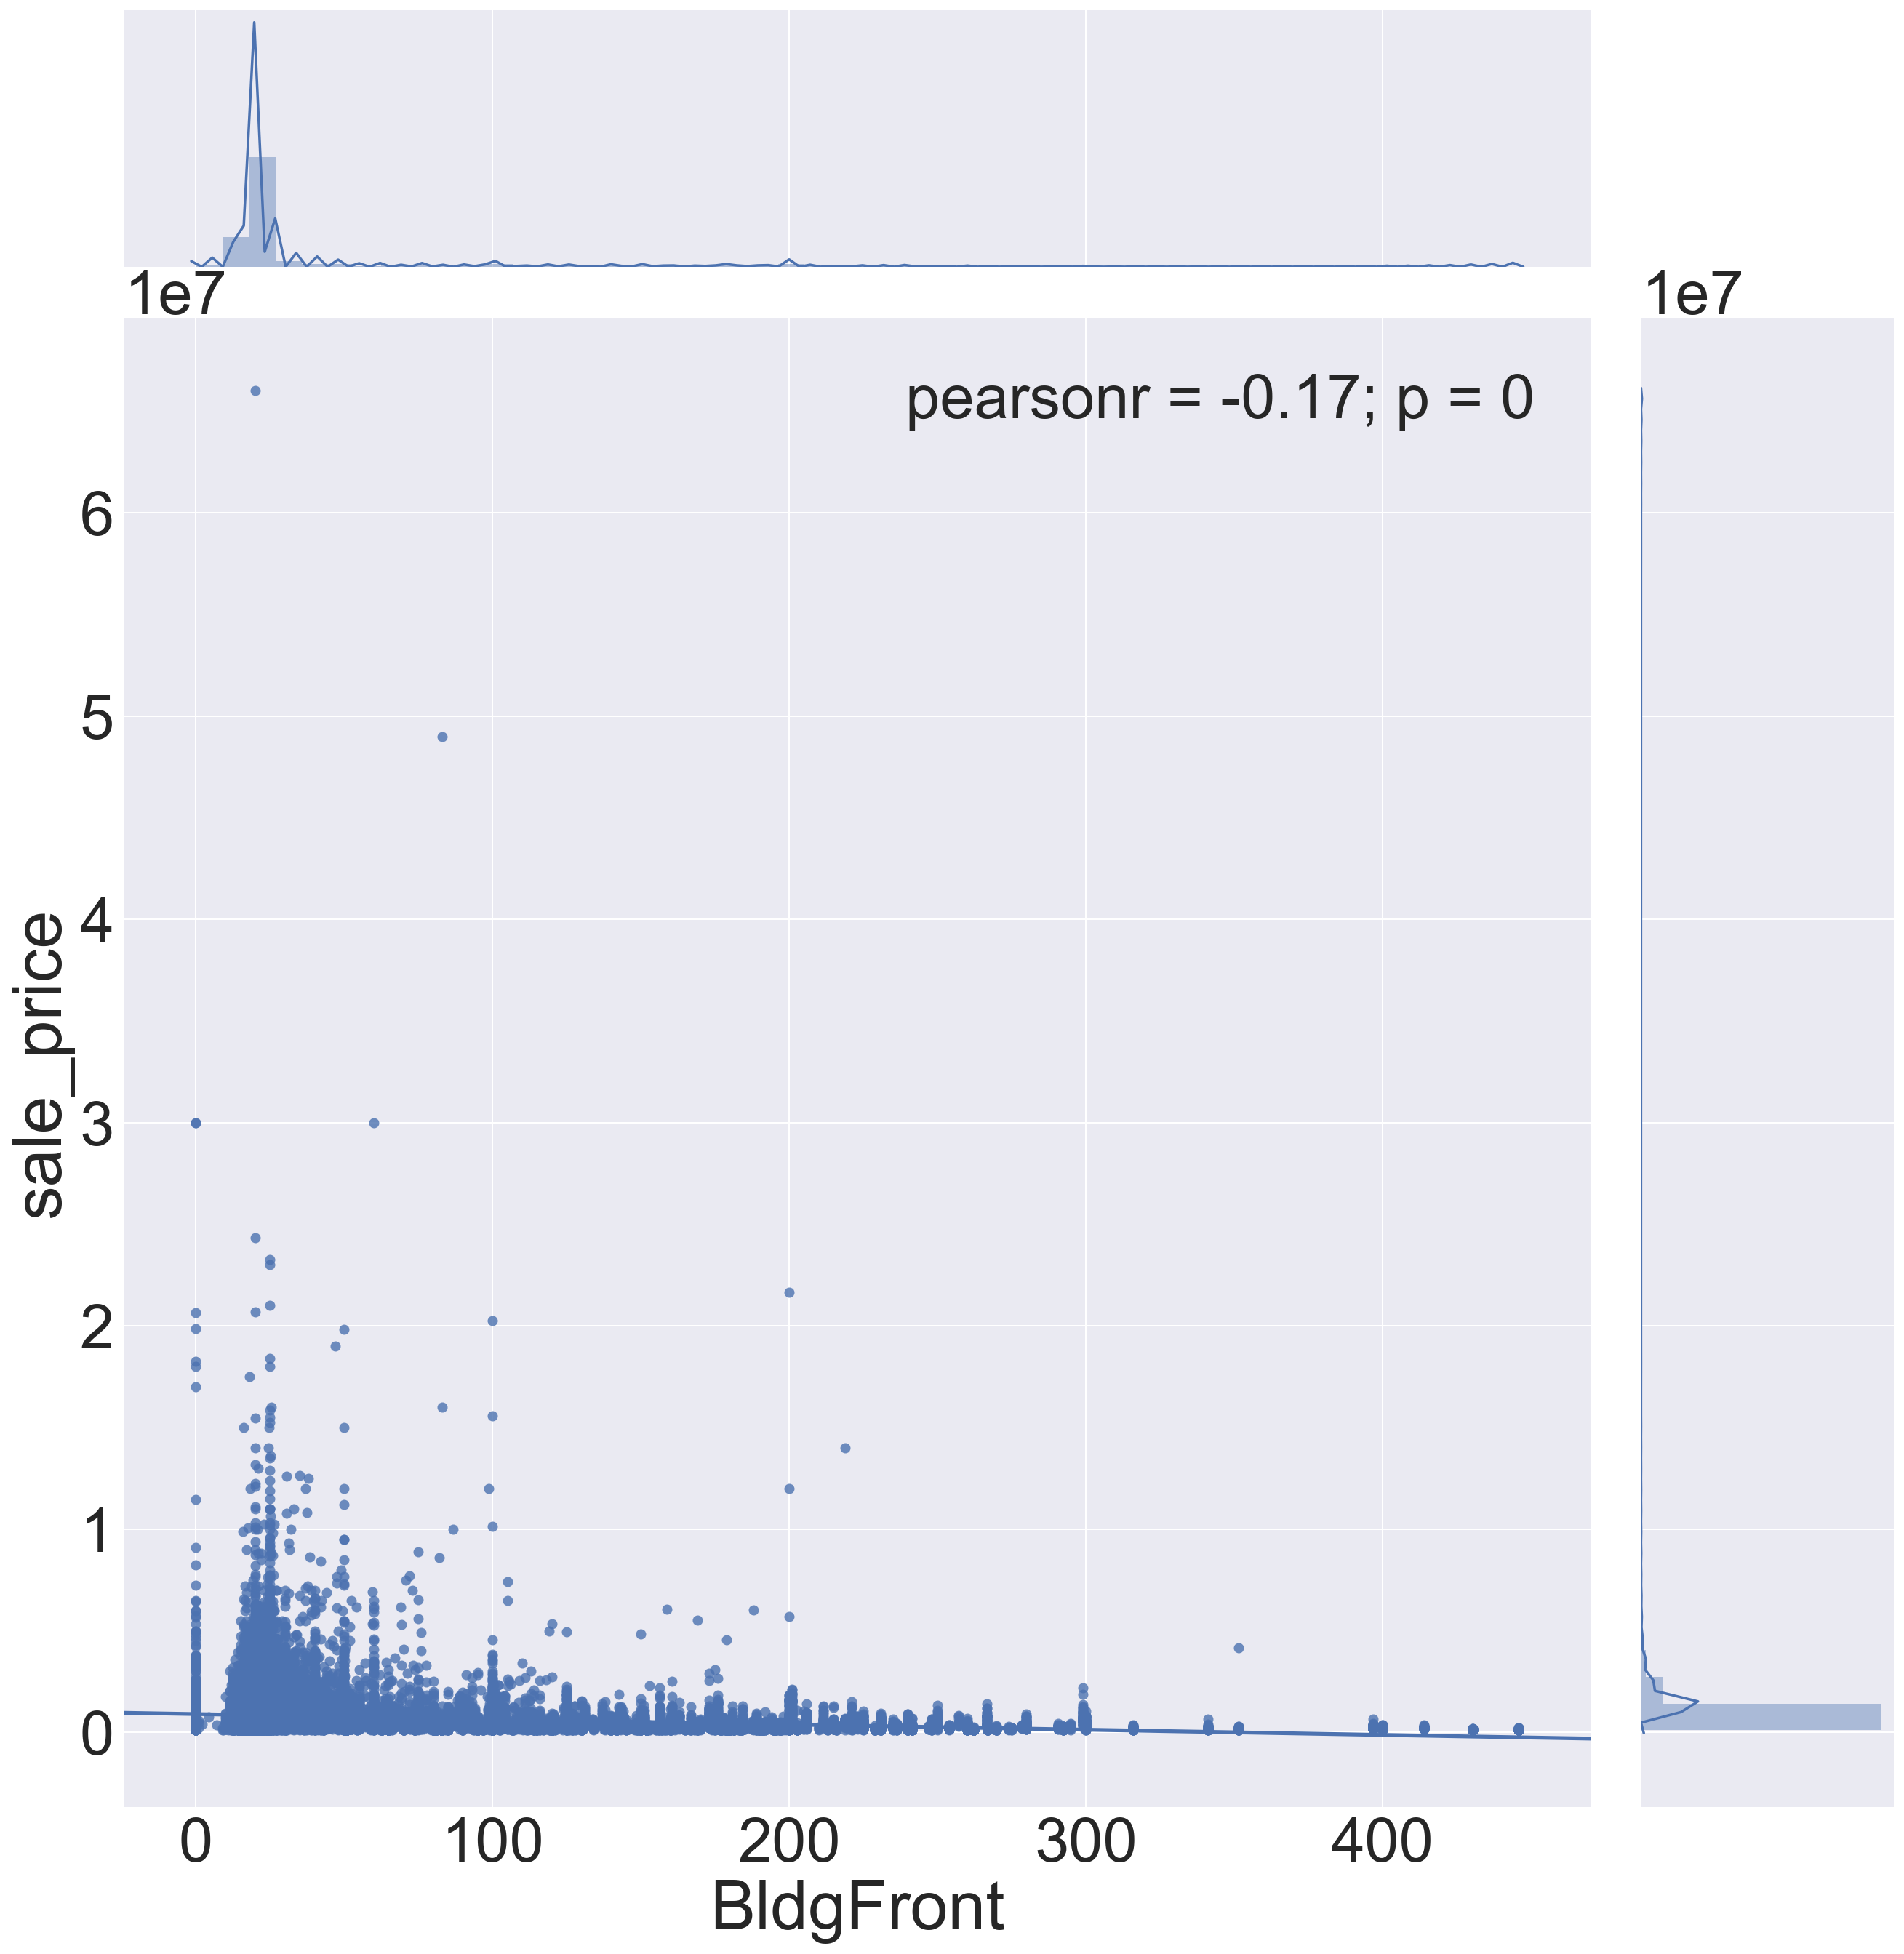

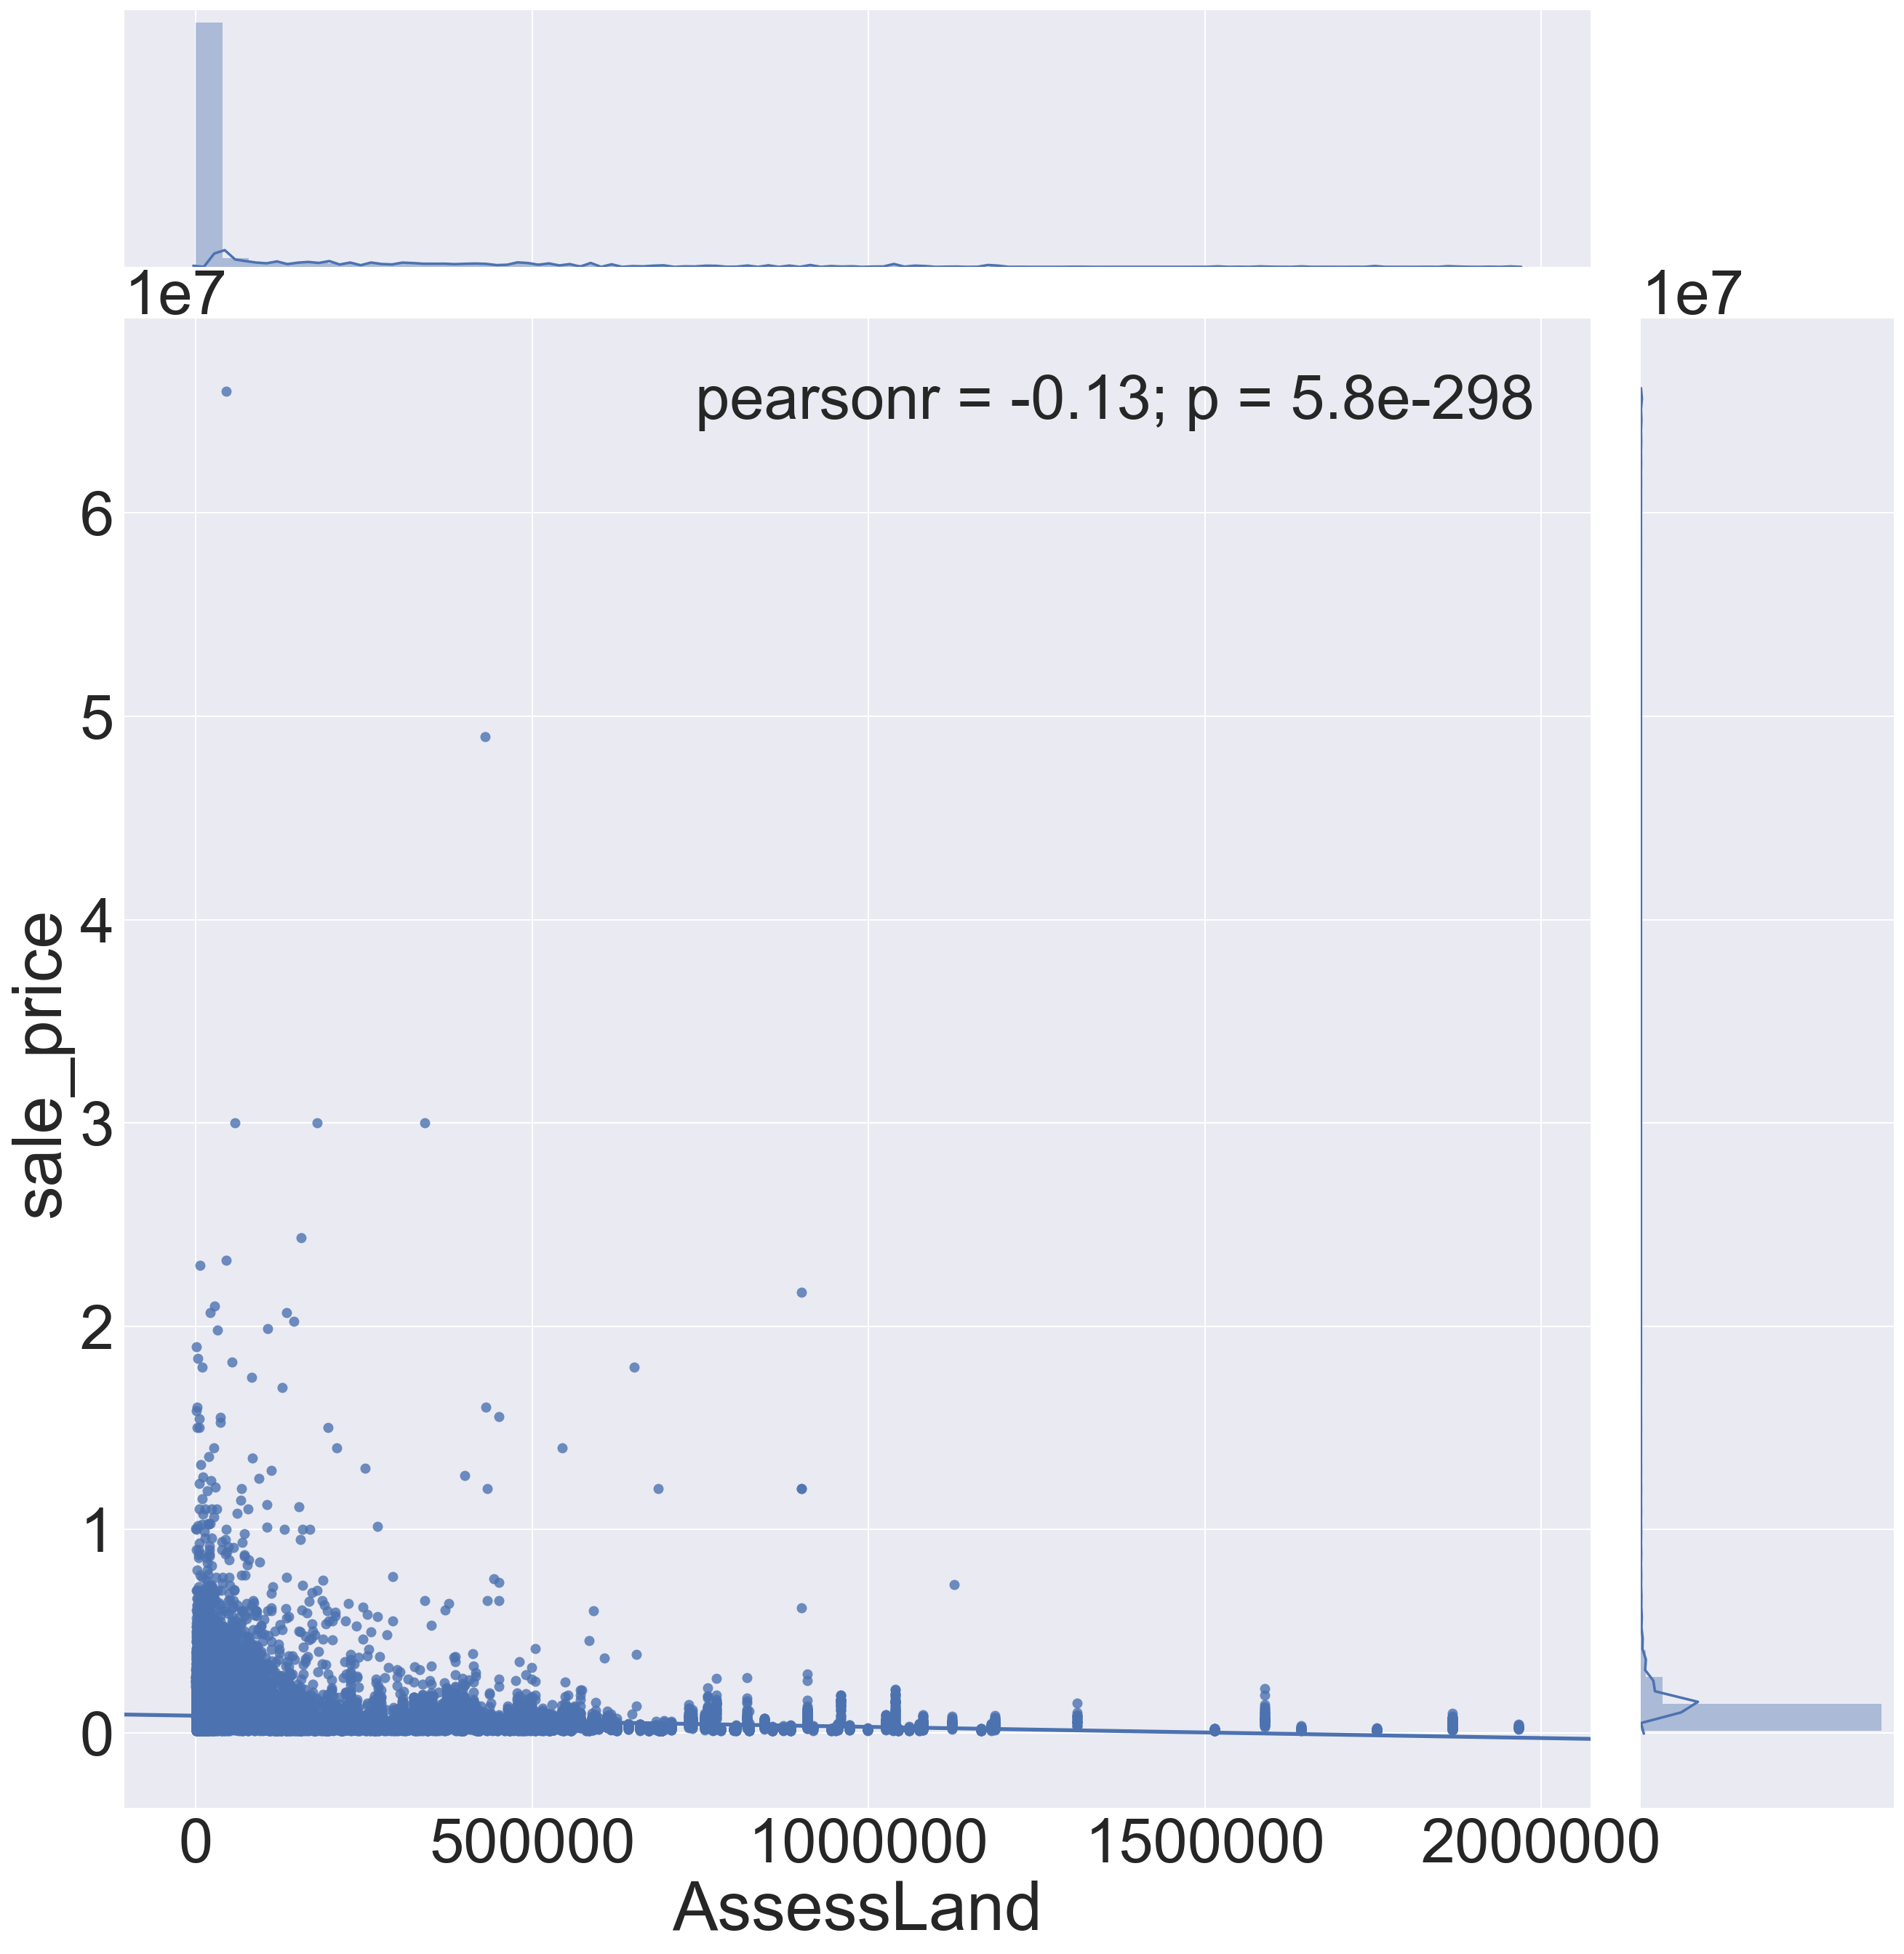

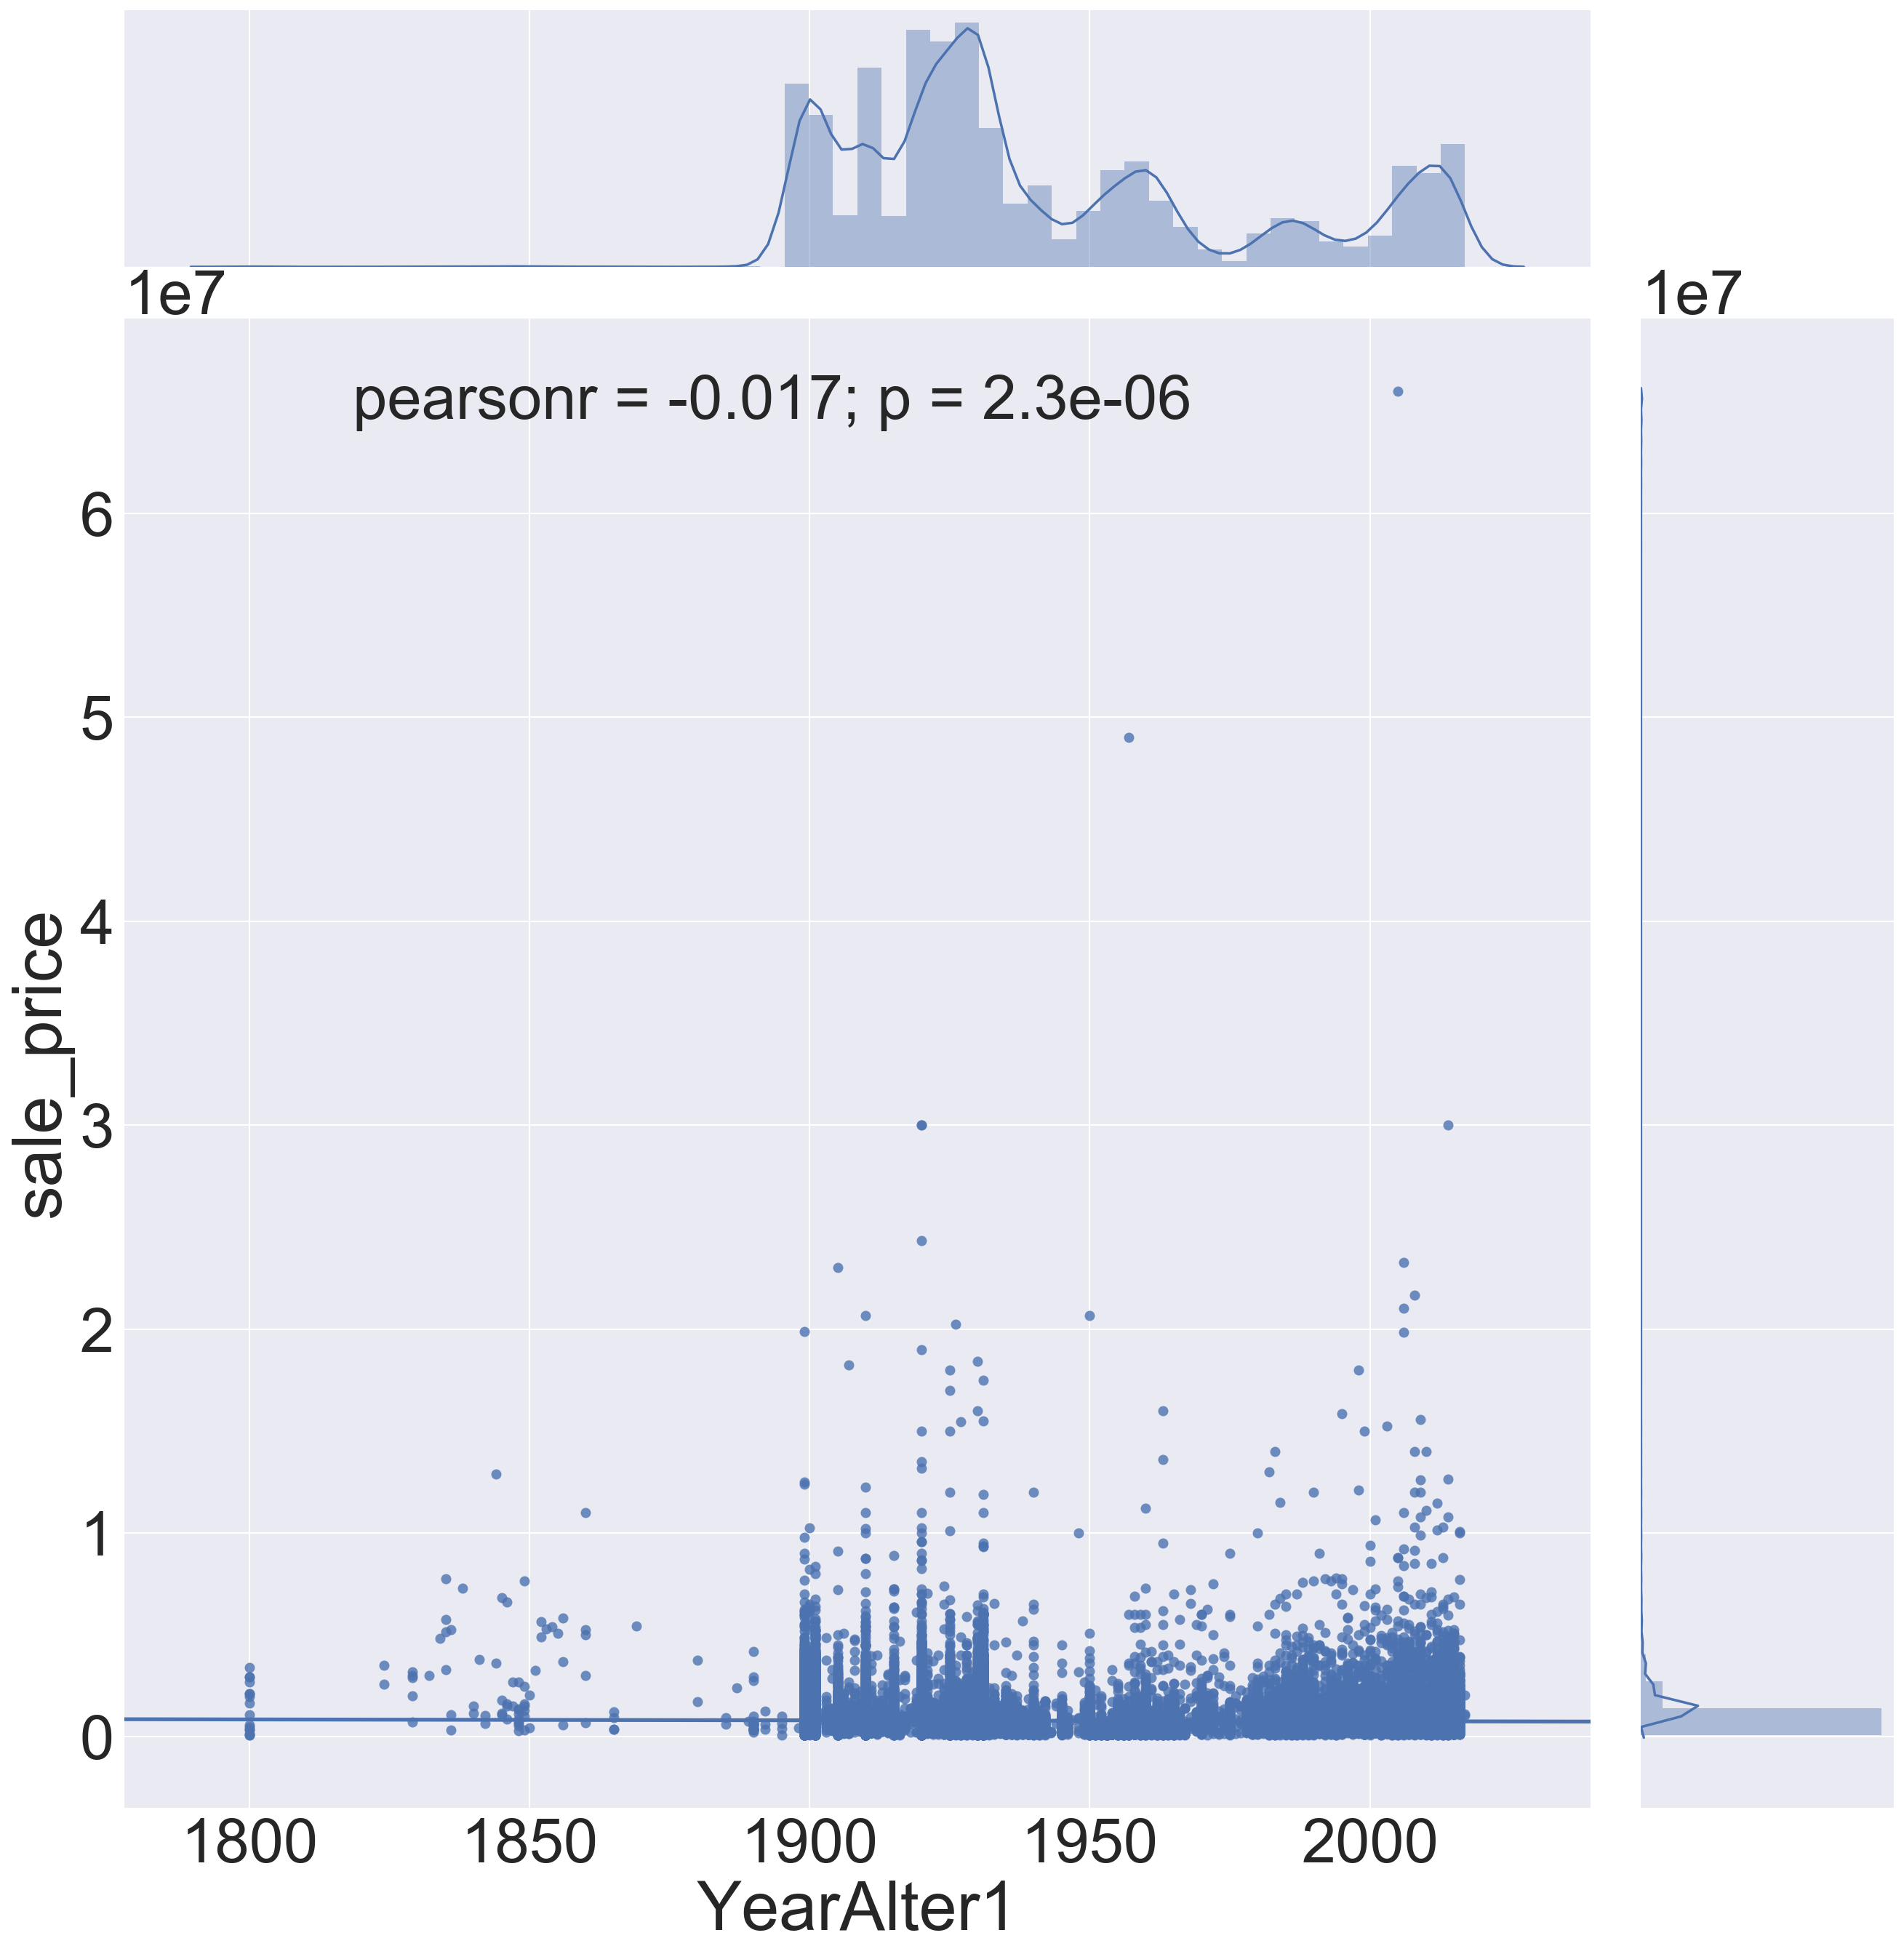

In [618]:
w = ['block', 'zip_code', 'residential_units', 'commercial_units', 
                                                  'total_units', 'land_sqft', 'gross_sqft', 'year_built', 'sale_price', 'year_of_sale',
                                                  'SchoolDist', 'PolicePrct', 'HealthCent', 'LandUse', 'LotArea', 'ComArea', 'OfficeArea', 
                                                    'RetailArea', 'GarageArea', 'FactryArea', 'NumFloors', 'BldgFront', 'AssessLand',
                                                      'YearAlter1']

for c in w:
    sns.jointplot(x=data[c], y=data['sale_price'], kind='reg', size=20)

In [619]:
# Here the Categorical Features are Label Encoded

for column in data.columns:
        if data[column].dtype == type(['object']):
            le = LabelEncoder()
            data[column] = le.fit_transform(data[column])
            

# Get Dummies for remaining categorical variables

data = pd.get_dummies(data, columns=['LandUse','zip_code'], drop_first=True)

In [620]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74683 entries, 33 to 99031
Data columns (total 73 columns):
building_class_category    74683 non-null int64
block                      74683 non-null int64
residential_units          74683 non-null int64
commercial_units           74683 non-null int64
total_units                74683 non-null int64
land_sqft                  74683 non-null float64
gross_sqft                 74683 non-null float64
year_built                 74683 non-null int64
sale_price                 74683 non-null float64
year_of_sale               74683 non-null int64
SchoolDist                 74683 non-null float64
PolicePrct                 74683 non-null float64
HealthCent                 74683 non-null float64
LotArea                    74683 non-null float64
ComArea                    74683 non-null float64
OfficeArea                 74683 non-null float64
RetailArea                 74683 non-null float64
GarageArea                 74683 non-null float64
Fact

In [626]:
data.shape

(74683, 73)

In [621]:
from sklearn.utils import shuffle

# Split Dataset into Train and Test Datasets

In [622]:
train_data = data[data.year_of_sale <= 2015]
test_data_1 = data[data.year_of_sale == 2016]
test_data_2 = data[data.year_of_sale == 2017]

print('2010 - 2015 data: ', train_data.head())
print('\n')
print('2016 data: ', test_data_1.head())
print('\n')
print('2017 data: ', test_data_2.head())

2010 - 2015 data:       building_class_category  block  residential_units  commercial_units  \
33                        15   2352                  3                 1   
57                        27   2334                  0                 4   
123                       17    146                  0                 2   
180                       19    149                  0                 1   
196                        1    180                  2                 1   

     total_units  land_sqft  gross_sqft  year_built  sale_price  year_of_sale  \
33             4     1000.0      4000.0        2005  66000000.0          2012   
57             4     3700.0      7475.0        1920  49000000.0          2013   
123            2     2598.0      6900.0        1920  30000000.0          2014   
180            1     1488.0      4464.0        1920  24350000.0          2015   
196            3     2000.0      4225.0        1905  23000000.0          2013   

          ...        zip_code_11232  

In [623]:
# The size of new data

print(train_data.shape)
print(test_data_1.shape)
print(test_data_2.shape)

(54470, 73)
(10245, 73)
(9968, 73)


In [624]:
# Here the new datasets are shuffled

train_data['log_price'] = np.log1p(train_data['sale_price'])
test_data_1['log_price'] = np.log1p(test_data_1['sale_price'])
test_data_2['log_price'] = np.log1p(test_data_2['sale_price'])

train_data = shuffle(train_data)
test_data_1 = shuffle(test_data_1)
test_data_2 = shuffle(test_data_2)


 mu = 719172.78 and sigma = 863745.53



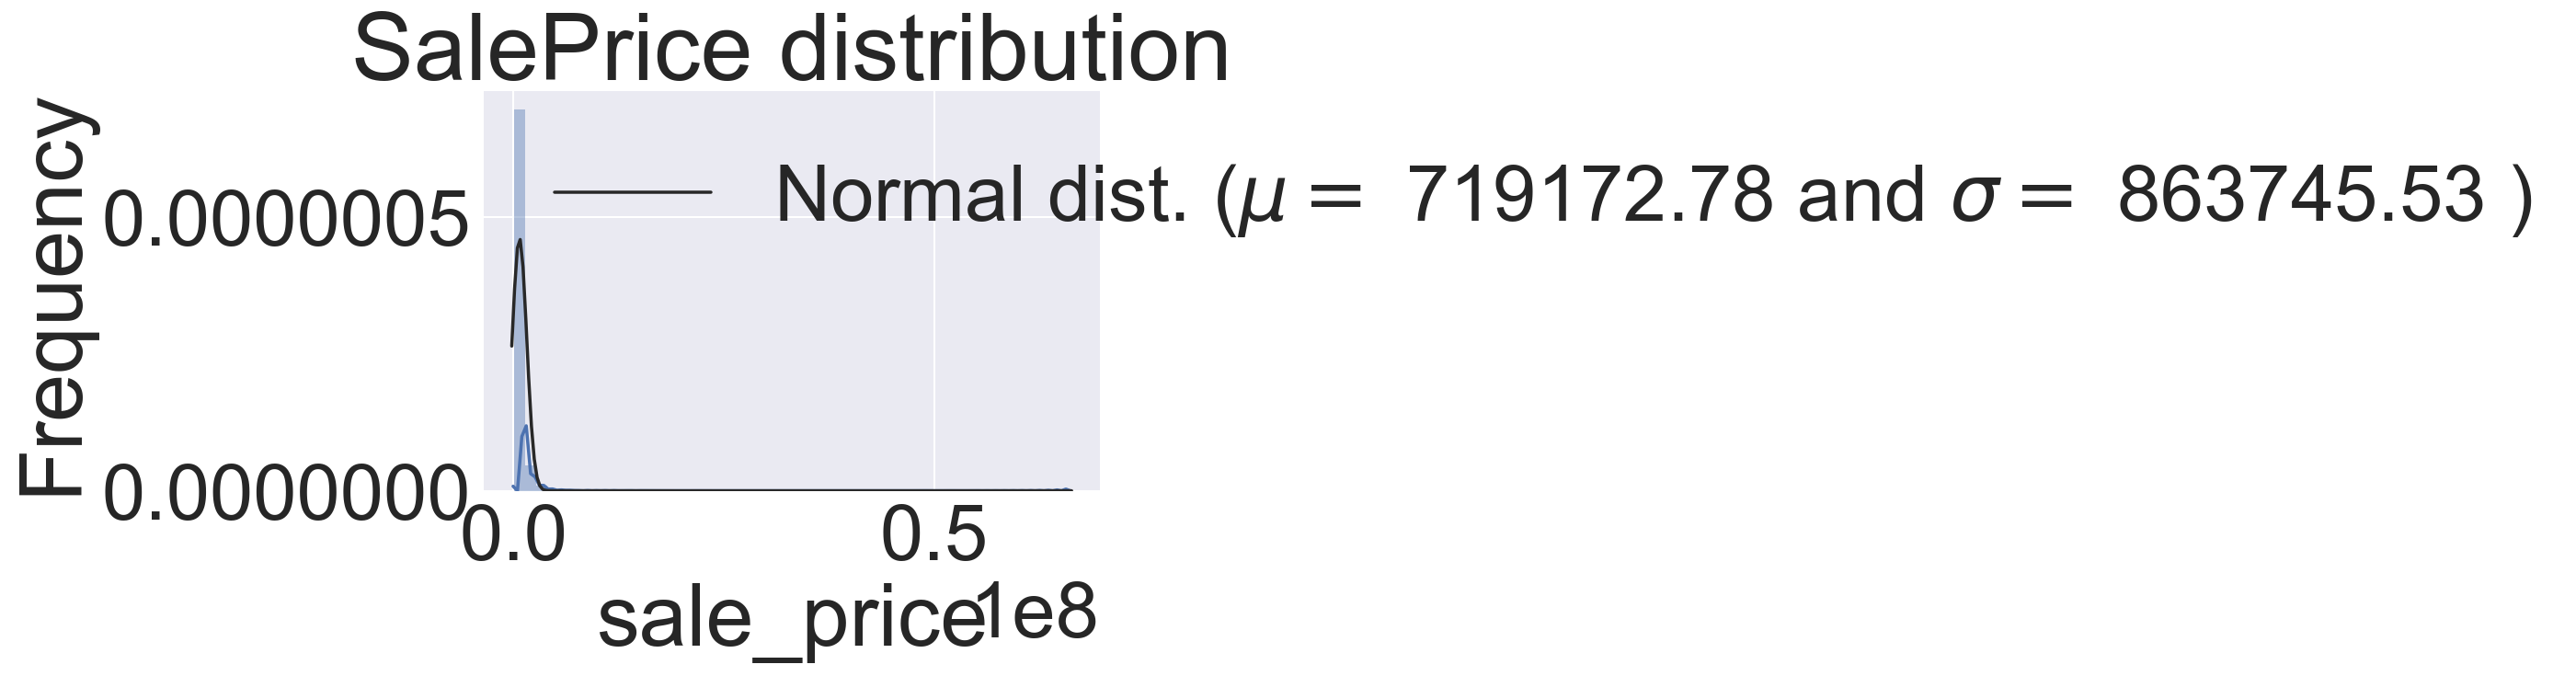

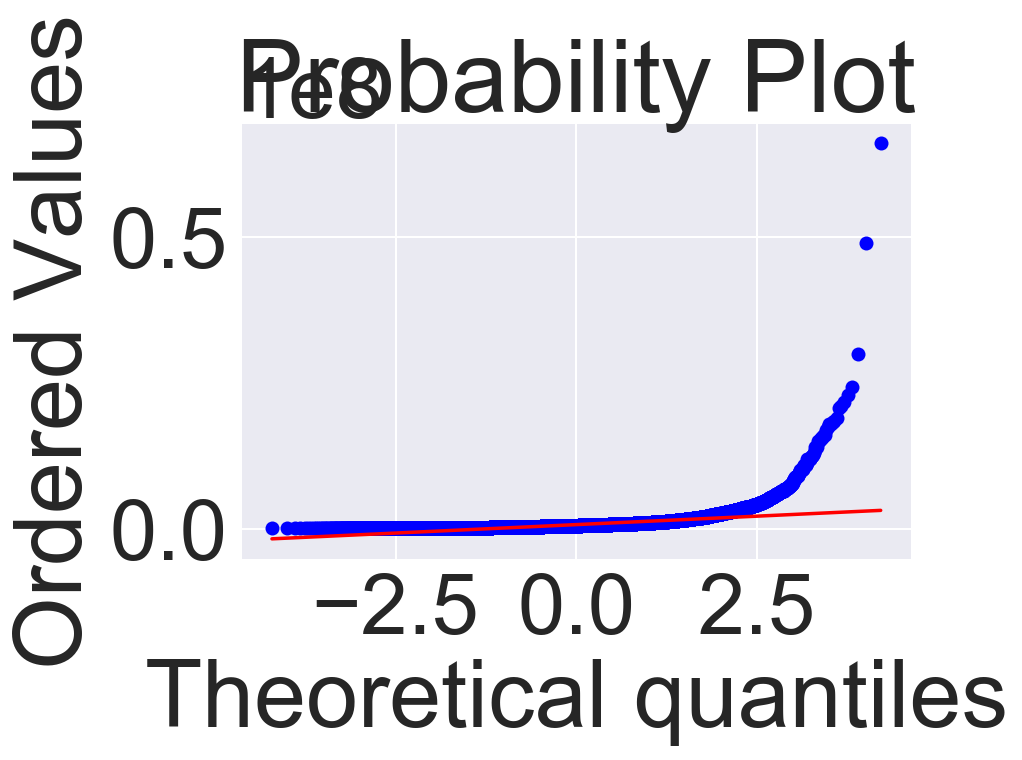

Skewness: 17.960652
Kurtosis: 894.103781


In [625]:
# Here we get a visualization of the TRAIN dataset


sns.distplot(train_data['sale_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_data['sale_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_data['sale_price'], plot=plt)
plt.show()

print("Skewness: %f" % train_data['sale_price'].skew())
print("Kurtosis: %f" % train_data['sale_price'].kurt())


# Split Train dataset into chunks

In [627]:
def index_marks(nrows, chunk_size):
    return range(1 * chunk_size, (nrows // chunk_size + 1) * chunk_size, chunk_size)

def split(dfm, chunk_size):
    indices = index_marks(dfm.shape[0], chunk_size)
    return np.split(dfm, indices)

data_chunks = split(train_data, 3000)
test_chunks = split(test_data_1, 3000)
print("The number of Training data chunks is: ", len(data_chunks))
#print(len(test_chunks))

The number of Training data chunks is:  19


# Model Evaluation and Prediction Function for entire dataset

In [628]:
def eval_model( model_ ):
  pred_df = pd.DataFrame( { "actual": test_y, "predicted" : model_.predict( test_x ) } )
  pred_df['resid'] = pred_df.actual - pred_df.predicted
  rmse = np.sqrt( metrics.mean_squared_error( pred_df.actual, pred_df.predicted ) )
  r2 = metrics.r2_score( pred_df.actual, pred_df.predicted )
  print( "RMSE: ", rmse, " : ", "R Squared: ", r2 )
  return pred_df, rmse, r2

# Linear Regression Model

In [629]:
#for i in data_chunks:
x = train_data.drop('sale_price', axis=1)
y = train_data.sale_price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=10)
    
lr = LinearRegression()
lr_model = lr.fit(x_train, y_train)
y_pred = lr_model.predict(x_train)
lr_r2 = r2_score(y_train, y_pred)
test_score = lr_model.score(x_test, y_test)
print('Training_Score: ', lr_r2, '\n', 'Test Score: ', test_score)

Training_Score:  0.5421977916416518 
 Test Score:  0.5988713102279056


In [630]:
# Cross Validation Score using the Linear Regression Model

cr_val_score = np.mean(cross_val_score(lr_model, x_train, y_train, n_jobs=1, cv=5))
print(cr_val_score)

0.5697810693526983


#### Predicting for 2016 House Prices

In [631]:
test_x = test_data_1.drop('sale_price', axis=1)
test_y = test_data_1.sale_price

In [632]:
# Prediction for 2016 House Prices using the Linear Model

twenty_sixteen_pred_score = lr_model.score(test_x, test_y)

print('Prediction Score for 2016: ', twenty_sixteen_pred_score)
pred_df, rmse, r2 = eval_model( lr_model )

Prediction Score for 2016:  0.61417989979709
RMSE:  643952.3236326602  :  R Squared:  0.61417989979709


In [633]:
# View Few House Predictions
pred_df.head()

actual     predicted          resid
19498  1150000.0  1.389841e+06 -239841.068763
30768   865000.0  1.117929e+06 -252928.834091
6125   2267500.0  2.161680e+06  105819.736723
28091   907500.0  1.110817e+06 -203317.307042
61321   500000.0  7.244013e+05 -224401.301319

#### Predicting for 2017 House Prices

In [634]:
test_x = test_data_2.drop('sale_price', axis=1)
test_y = test_data_2.sale_price

In [635]:
# Prediction for 2016 House Prices using the Linear Model

twenty_seventeen_pred_score = lr_model.score(test_x, test_y)

print('Prediction Score for 2017: ', twenty_seventeen_pred_score)
pred_df, rmse, r2 = eval_model( lr_model )

Prediction Score for 2017:  0.7036888892757602
RMSE:  512062.8689558907  :  R Squared:  0.7036888892757602


In [636]:
# View Few House Predictions
pred_df.head()

actual     predicted         resid
95578   160000.0 -4.030520e+05  5.630520e+05
3725   3100000.0  2.098152e+06  1.001848e+06
44813   669500.0  9.541273e+05 -2.846273e+05
15839  1300000.0  1.313471e+06 -1.347110e+04
53811   575000.0  7.455153e+05 -1.705153e+05

# Lasso Model

In [637]:
from sklearn.cross_validation import ShuffleSplit

In [638]:
def perf_metr(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """

    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)

    # Return the score
    return score

In [639]:
def fit_model_1(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """

    cv_sets = ShuffleSplit(X.shape[0], n_iter=10, test_size = 0.25, random_state = 0)

    lasso = Lasso(random_state=1)
                     
    params = dict(alpha=[0.01*x for x in range(1, 5)])
    
    scoring_fnc = make_scorer(perf_metr)

    grid = GridSearchCV(lasso, params, cv=cv_sets, scoring=scoring_fnc, refit=True)

    grid = grid.fit(X, y)

    return grid.best_estimator_

In [640]:
train_scores = list()
validation_scores = list()

for d, i in zip(data_chunks, range(len(data_chunks))):
    x = d.drop('sale_price', axis=1)
    y = d.sale_price.astype('int64')
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=10)
    
    reg = fit_model_1(x_train, y_train)
    train_score = reg.score(x_train, y_train)
    test_score = reg.score(x_test, y_test)
    train_scores.append(train_score)
    validation_scores.append(test_score)
    print("Training and Test Scores for the {0} batch".format(i+1))
    print('Training_Score: ', train_score, '\n', 'Test Score: ', test_score)
    print('\n')






Training and Test Scores for the 1 batch
Training_Score:  0.5944410807512327 
 Test Score:  0.6422829125175236


Training and Test Scores for the 2 batch
Training_Score:  0.7528729447073206 
 Test Score:  0.6791489607670043


Training and Test Scores for the 3 batch
Training_Score:  0.7421853383083842 
 Test Score:  0.7500861627562248


Training and Test Scores for the 4 batch
Training_Score:  0.2950775413451111 
 Test Score:  0.43461130757799704


Training and Test Scores for the 5 batch
Training_Score:  0.5859193215430369 
 Test Score:  0.6300823195861546


Training and Test Scores for the 6 batch
Training_Score:  0.624046606042546 
 Test Score:  0.36443664083667326


Training and Test Scores for the 7 batch
Training_Score:  0.6784926593132644 
 Test Score:  0.4468755633408197


Training and Test Scores for the 8 batch
Training_Score:  0.7326546525589183 
 Test Score:  0.6459018779591007


Training and Test Scores for the 9 batch
Training_Score:  0.6099401166121416 
 Test Score:  0.7

Mean of Training Scores: 
 0.6624784002435363
Mean of Validation Scores: 
 0.5529832815401888


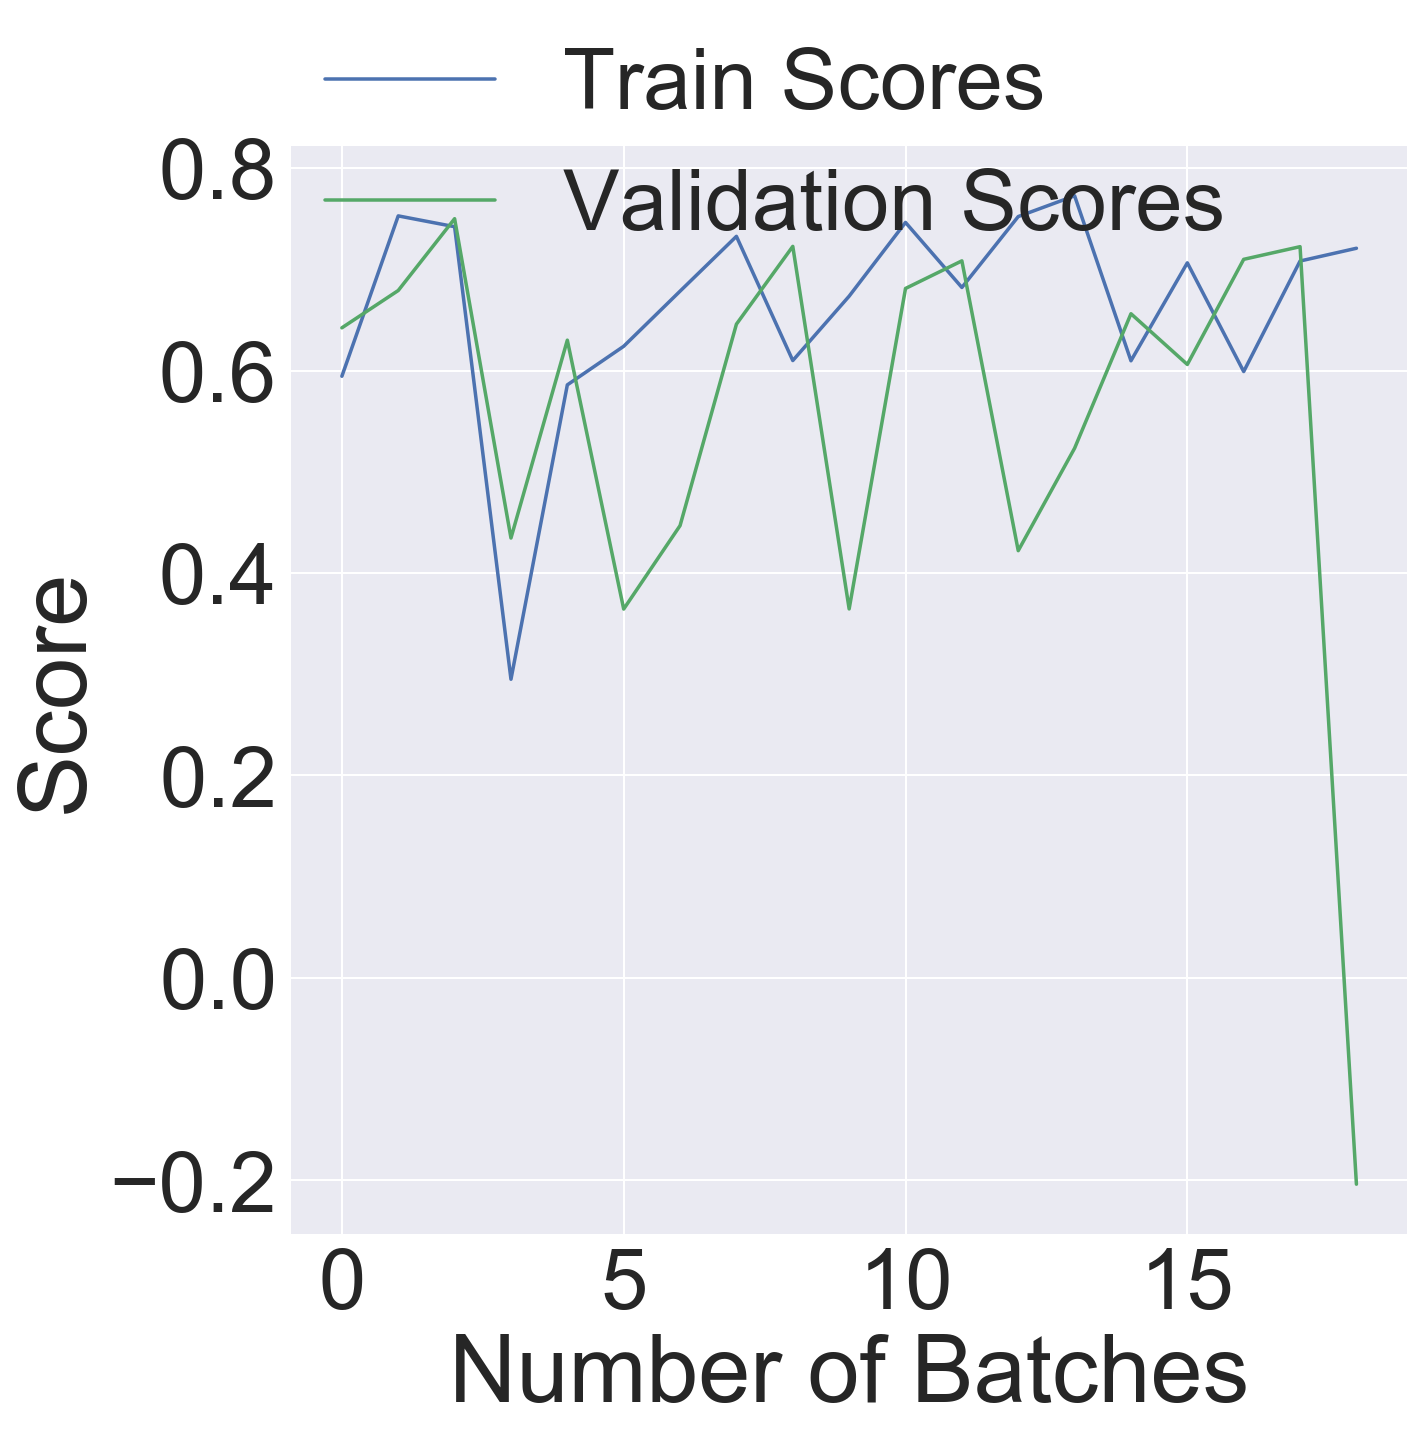

In [641]:
mean_training_score = sum(train_scores)/len(train_scores) 
print('Mean of Training Scores: \n', mean_training_score)
mean_val_score = sum(validation_scores)/len(validation_scores)
print('Mean of Validation Scores: \n', mean_val_score)

plt.figure(figsize=(10, 10))
plt.plot(train_scores, label="Train Scores")
plt.plot(validation_scores, label="Validation Scores")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=1,
           ncol=1, mode="expand", borderaxespad=0.)
plt.xlabel("Number of Batches")
plt.ylabel("Score")
plt.show()

In [642]:
#### Predicting for 2016 House Prices

test_x = test_data_1.drop('sale_price', axis=1)
test_y = test_data_1.sale_price

# Prediction for 2016 House Prices using the Linear Model

twenty_sixteen_pred_score = reg.score(test_x, test_y)

print('Prediction Score for 2016: ', twenty_sixteen_pred_score)
pred_df, rmse, r2 = eval_model( reg )

# View Few House Predictions
print(pred_df.head())

#### Predicting for 2017 House Prices

test_x = test_data_2.drop('sale_price', axis=1)
test_y = test_data_2.sale_price

# Prediction for 2016 House Prices using the Linear Model

twenty_seventeen_pred_score = reg.score(test_x, test_y)

print('Prediction Score for 2017: ', twenty_seventeen_pred_score)
pred_df, rmse, r2 = eval_model( reg )

# View Few House Predictions
print(pred_df.head())

Prediction Score for 2016:  0.521822040877314
RMSE:  716895.8510280685  :  R Squared:  0.521822040877314
          actual     predicted          resid
19498  1150000.0  1.572227e+06 -422226.561631
30768   865000.0  1.242155e+06 -377155.278233
6125   2267500.0  2.289512e+06  -22012.125482
28091   907500.0  8.016134e+05  105886.596786
61321   500000.0  6.354623e+05 -135462.311177
Prediction Score for 2017:  0.5912495618706681
RMSE:  601420.7840628305  :  R Squared:  0.5912495618706681
          actual     predicted          resid
95578   160000.0 -3.494618e+05  509461.773319
3725   3100000.0  2.381883e+06  718117.188338
44813   669500.0  1.011897e+06 -342397.440488
15839  1300000.0  1.266839e+06   33160.924279
53811   575000.0  6.388406e+05  -63840.587217


# Ridge Model

In [645]:
def fit_model_2(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """

    cv_sets = ShuffleSplit(X.shape[0], n_iter = 20, test_size = 0.25, random_state = 0)
    
    ridge_m = Ridge()
    params = {'alpha':[0.003, 0.005, 0.03, 0.05, 0.1, 0.01, 0.1, 1, 5]}
                     
    #params = dict(alpha=[0.0001*x for x in range(1, 5)])
    
    scoring_fnc = make_scorer(perf_metr)

    grid = GridSearchCV(ridge_m, params, cv=cv_sets, scoring=scoring_fnc)

    grid = grid.fit(X, y)

    return grid.best_estimator_

In [646]:
train_scores = list()
validation_scores = list()

for d, i in zip(data_chunks, range(len(data_chunks))):
    x = d.drop('sale_price', axis=1)
    y = d.sale_price
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=10)
    
    reg_1 = fit_model_2(x_train, y_train)
    train_score = reg_1.score(x_train, y_train)
    test_score = reg_1.score(x_test, y_test)
    train_scores.append(train_score)
    validation_scores.append(test_score)
    print("Training and Test Scores for the {0} batch".format(i+1))
    print('Training_Score: ', train_score, '\n', 'Test Score: ', test_score)
    print('\n')

Training and Test Scores for the 1 batch
Training_Score:  0.590065063310554 
 Test Score:  0.6632525176113696


Training and Test Scores for the 2 batch
Training_Score:  0.7524126055167397 
 Test Score:  0.6747574576247726


Training and Test Scores for the 3 batch
Training_Score:  0.740594109881941 
 Test Score:  0.7481571990108256


Training and Test Scores for the 4 batch
Training_Score:  0.2938272446490209 
 Test Score:  0.46199142899161794


Training and Test Scores for the 5 batch
Training_Score:  0.5768768778052042 
 Test Score:  0.5918779617704244


Training and Test Scores for the 6 batch
Training_Score:  0.5932865036160296 
 Test Score:  0.28982909895921205


Training and Test Scores for the 7 batch
Training_Score:  0.6749771720740496 
 Test Score:  0.44734685223775894


Training and Test Scores for the 8 batch
Training_Score:  0.7300838158368421 
 Test Score:  0.6559904177190269


Training and Test Scores for the 9 batch
Training_Score:  0.6083999921210438 
 Test Score:  0.7

Mean of Training Scores: 
 0.6568090339824003
Mean of Validation Scores: 
 0.5621877733298866


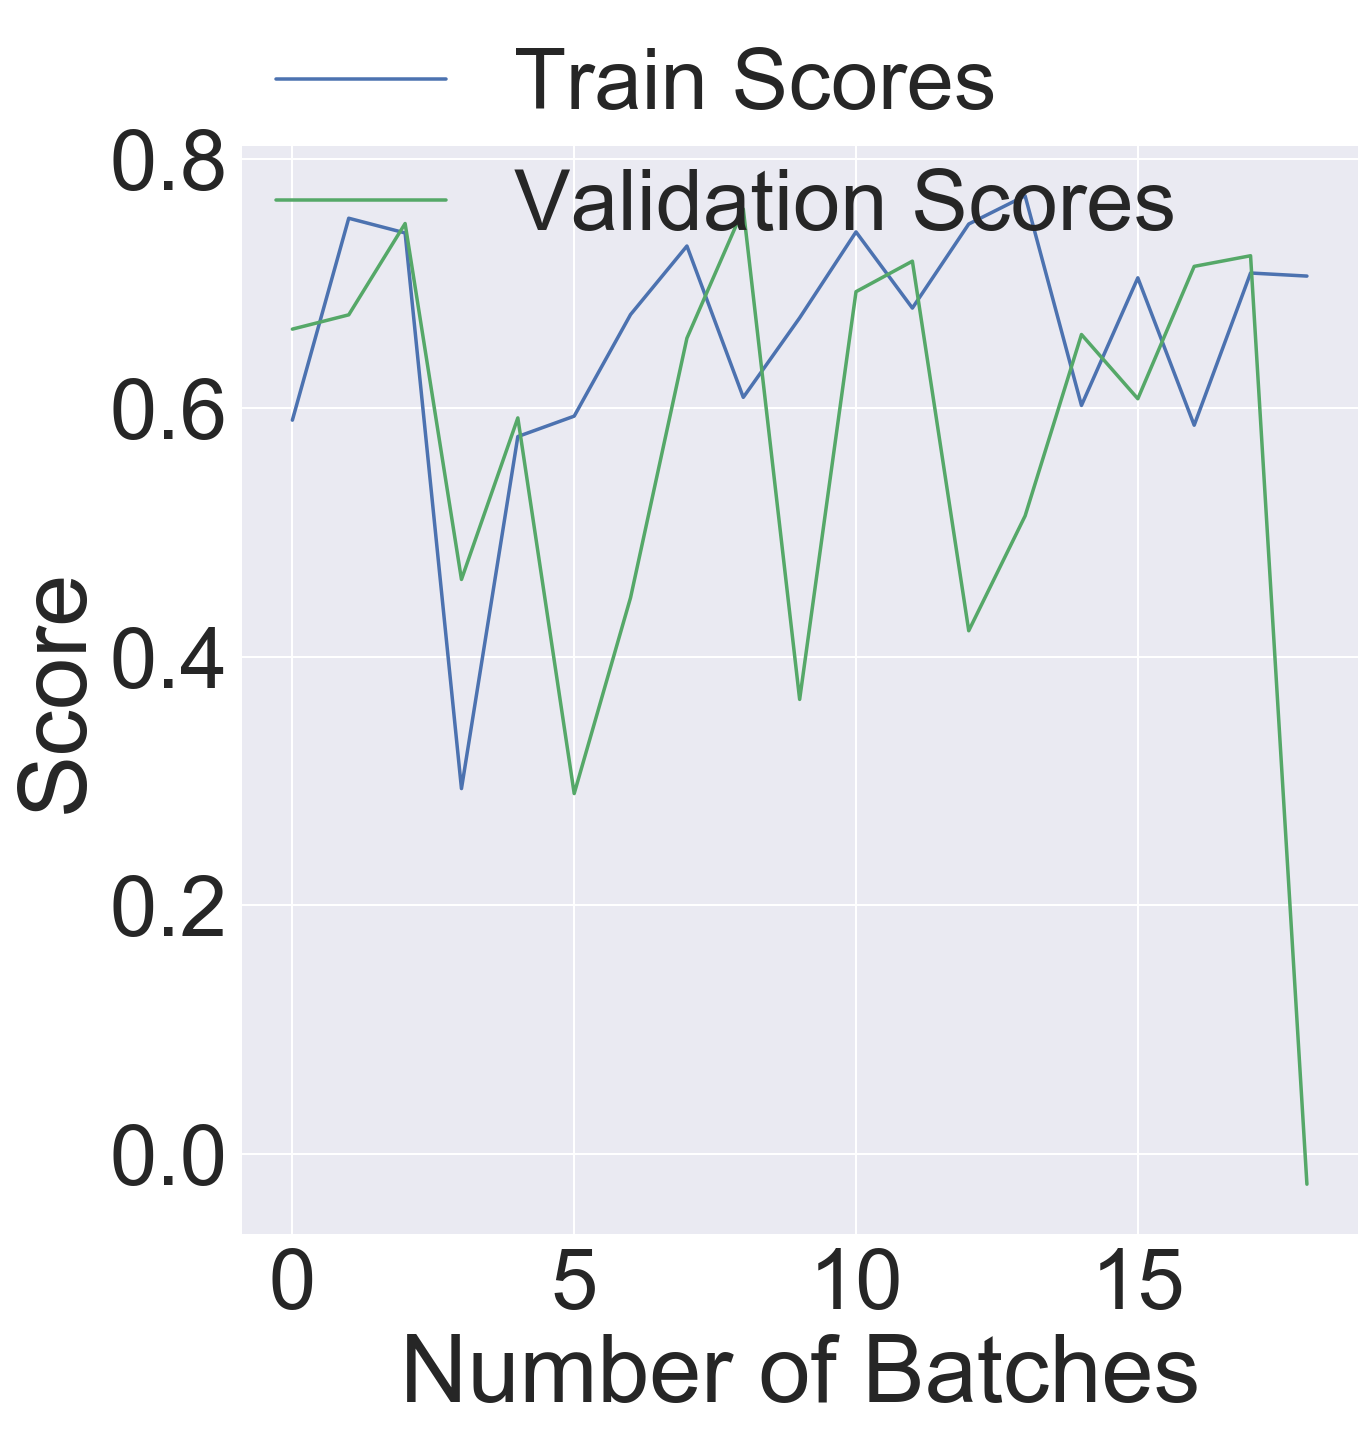

In [647]:
mean_training_score = sum(train_scores)/len(train_scores) 
print('Mean of Training Scores: \n', mean_training_score)
mean_val_score = sum(validation_scores)/len(validation_scores)
print('Mean of Validation Scores: \n', mean_val_score)

plt.figure(figsize=(10, 10))
plt.plot(train_scores, label="Train Scores")
plt.plot(validation_scores, label="Validation Scores")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=1,
           ncol=1, mode="expand", borderaxespad=0.)
plt.xlabel("Number of Batches")
plt.ylabel("Score")
plt.show()

In [649]:
#### Predicting for 2016 House Prices

test_x = test_data_1.drop('sale_price', axis=1)
test_y = test_data_1.sale_price

# Prediction for 2016 House Prices using the Linear Model

twenty_sixteen_pred_score = reg_1.score(test_x, test_y)

print('Prediction Score for 2016: ', twenty_sixteen_pred_score)
pred_df, rmse, r2 = eval_model( reg_1 )

# View Few House Predictions
print(pred_df.head())

#### Predicting for 2017 House Prices

test_x = test_data_2.drop('sale_price', axis=1)
test_y = test_data_2.sale_price

# Prediction for 2016 House Prices using the Linear Model

twenty_seventeen_pred_score = reg_1.score(test_x, test_y)

print('Prediction Score for 2017: ', twenty_seventeen_pred_score)
pred_df, rmse, r2 = eval_model( reg_1 )

# View Few House Predictions
print(pred_df.head())

Prediction Score for 2016:  0.552337276225044
RMSE:  693644.1953576008  :  R Squared:  0.552337276225044
          actual     predicted          resid
19498  1150000.0  1.688323e+06 -538322.646408
30768   865000.0  1.198697e+06 -333697.280482
6125   2267500.0  2.242216e+06   25283.978723
28091   907500.0  9.507932e+05  -43293.175459
61321   500000.0  7.026703e+05 -202670.291913
Prediction Score for 2017:  0.6327893066744282
RMSE:  570042.1595233405  :  R Squared:  0.6327893066744282
          actual     predicted          resid
95578   160000.0 -5.122210e+05  672221.044967
3725   3100000.0  2.217411e+06  882589.393658
44813   669500.0  9.988335e+05 -329333.466599
15839  1300000.0  1.366883e+06  -66882.625547
53811   575000.0  6.518771e+05  -76877.123728



# Random Forest

In [650]:
def fit_model_3(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """

    cv_sets = ShuffleSplit(X.shape[0], n_iter = 20, test_size = 0.25, random_state = 0)

    random_forest = RandomForestRegressor(n_estimators=10)
                     
    params = dict(max_depth=[0.001*x for x in range(1, 20)])
    
    scoring_fnc = make_scorer(perf_metr)

    grid = GridSearchCV(random_forest, params, cv=cv_sets, scoring=scoring_fnc)

    grid = grid.fit(X, y)

    return grid.best_estimator_

In [651]:
train_scores = list()
validation_scores = list()

for d, i in zip(data_chunks, range(len(data_chunks))):
    x = d.drop('sale_price', axis=1)
    y = d.sale_price.astype('int64')
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=10)
    
    reg_2 = fit_model_3(x_train, y_train)
    train_score = reg_2.score(x_train, y_train)
    test_score = reg_2.score(x_test, y_test)
    train_scores.append(train_score)
    validation_scores.append(test_score)
    print("Training and Test Scores for the {0} batch".format(i+1))
    print('Training_Score: ', train_score, '\n', 'Test Score: ', test_score)
    print('\n')

Training and Test Scores for the 1 batch
Training_Score:  -1.9720433590775244e-05 
 Test Score:  -0.010118560497965667


Training and Test Scores for the 2 batch
Training_Score:  -1.731343432798127e-05 
 Test Score:  -0.003459073322922057


Training and Test Scores for the 3 batch
Training_Score:  -4.912453451133558e-06 
 Test Score:  -1.8236583994468702e-05


Training and Test Scores for the 4 batch
Training_Score:  -6.314431340026516e-07 
 Test Score:  -0.0016907013676699112


Training and Test Scores for the 5 batch
Training_Score:  -2.504026287319938e-05 
 Test Score:  -8.995996545779761e-05


Training and Test Scores for the 6 batch
Training_Score:  -1.0379880330146918e-05 
 Test Score:  -0.006726735404408046


Training and Test Scores for the 7 batch
Training_Score:  -4.073499604295705e-07 
 Test Score:  -0.0013022956516182127


Training and Test Scores for the 8 batch
Training_Score:  -2.5169491587151427e-05 
 Test Score:  -1.1328237468966053e-05


Training and Test Scores for t

Mean of Training Scores: 
 -4.1003376654551095e-05
Mean of Validation Scores: 
 -0.005612519023938656


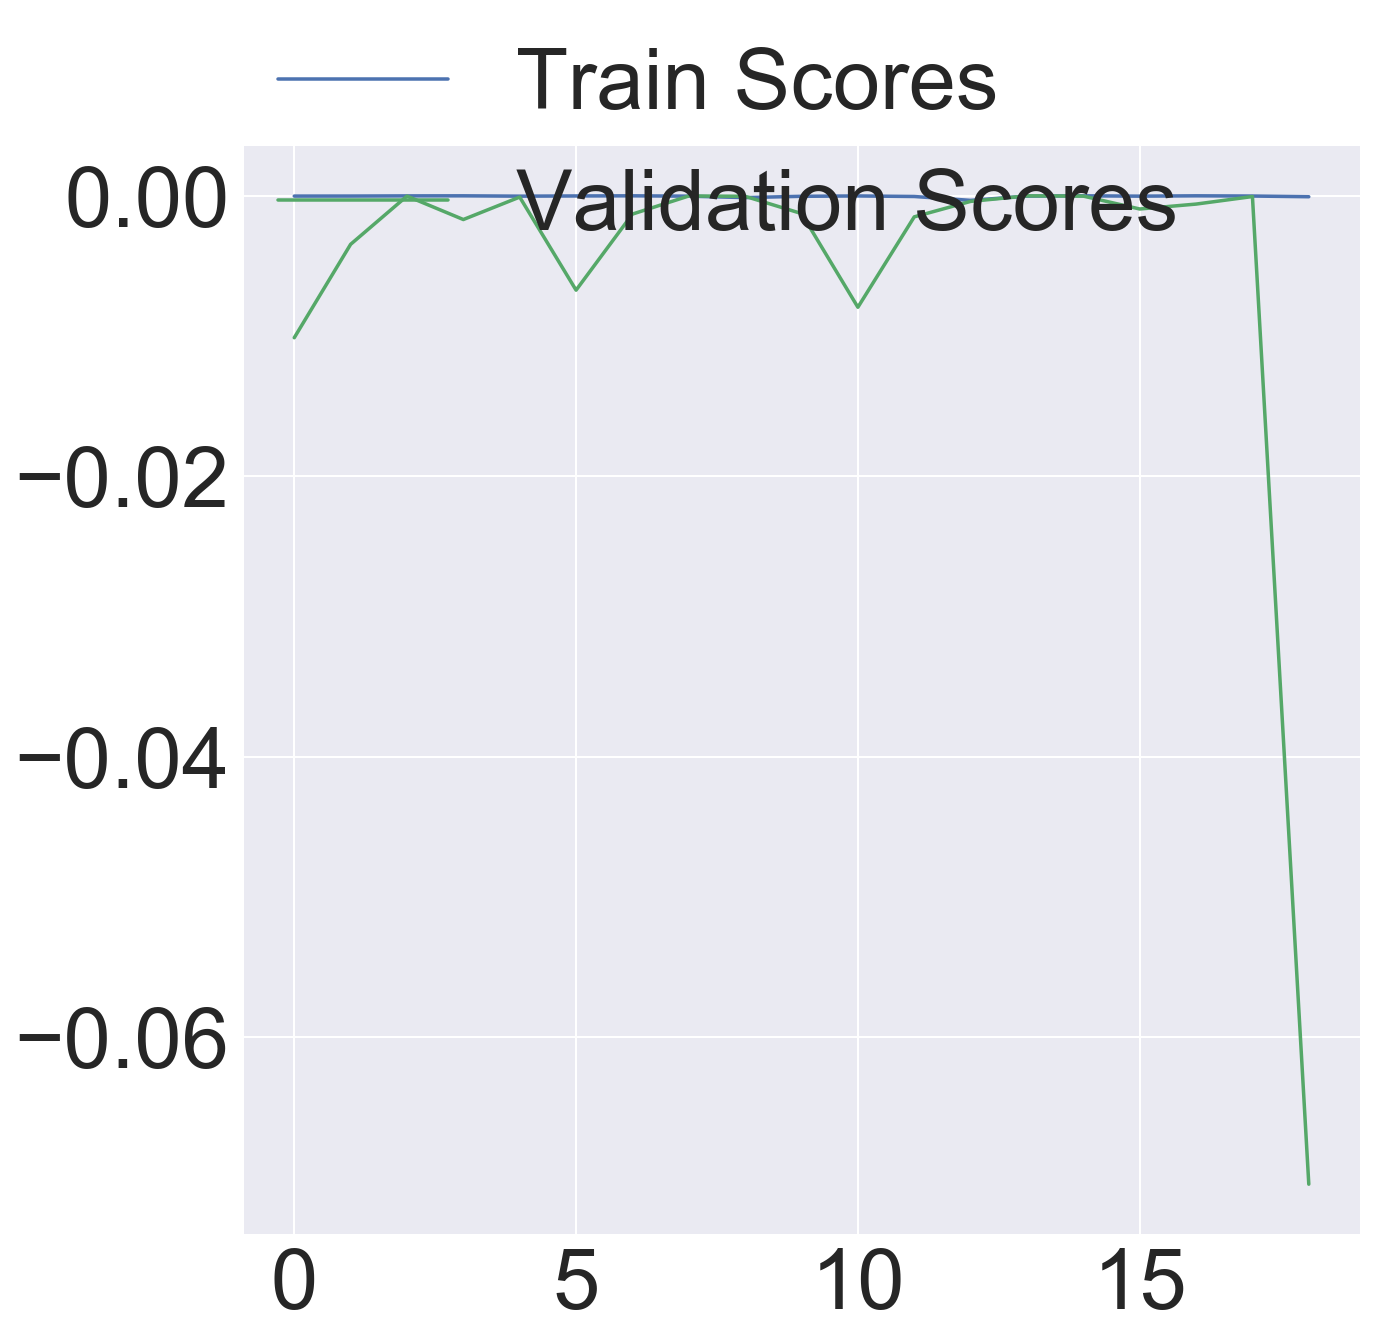

In [652]:
mean_training_score = sum(train_scores)/len(train_scores) 
print('Mean of Training Scores: \n', mean_training_score)
mean_val_score = sum(validation_scores)/len(validation_scores)
print('Mean of Validation Scores: \n', mean_val_score)

plt.figure(figsize=(10, 10))
plt.plot(train_scores, label="Train Scores")
plt.plot(validation_scores, label="Validation Scores")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=1,
           ncol=1, mode="expand", borderaxespad=0.)
plt.show()

In [653]:
#### Predicting for 2016 House Prices

test_x = test_data_1.drop('sale_price', axis=1)
test_y = test_data_1.sale_price

# Prediction for 2016 House Prices using the Linear Model

twenty_sixteen_pred_score = reg_2.score(test_x, test_y)

print('Prediction Score for 2016: ', twenty_sixteen_pred_score)
pred_df, rmse, r2 = eval_model( reg_2 )

# View Few House Predictions
print(pred_df.head())

#### Predicting for 2017 House Prices

test_x = test_data_2.drop('sale_price', axis=1)
test_y = test_data_2.sale_price

# Prediction for 2016 House Prices using the Linear Model

twenty_seventeen_pred_score = reg_2.score(test_x, test_y)

print('Prediction Score for 2017: ', twenty_seventeen_pred_score)
pred_df, rmse, r2 = eval_model( reg_2 )

# View Few House Predictions
print(pred_df.head())

Prediction Score for 2016:  -0.052597519110278775
RMSE:  1063634.6109391449  :  R Squared:  -0.05259751911027877
          actual      predicted         resid
19498  1150000.0  721895.638352  4.281044e+05
30768   865000.0  721895.638352  1.431044e+05
6125   2267500.0  721895.638352  1.545604e+06
28091   907500.0  721895.638352  1.856044e+05
61321   500000.0  721895.638352 -2.218956e+05
Prediction Score for 2017:  -0.08825382427690864
RMSE:  981328.513515393  :  R Squared:  -0.08825382427690864
          actual      predicted         resid
95578   160000.0  721895.638352 -5.618956e+05
3725   3100000.0  721895.638352  2.378104e+06
44813   669500.0  721895.638352 -5.239564e+04
15839  1300000.0  721895.638352  5.781044e+05
53811   575000.0  721895.638352 -1.468956e+05


# XGBoost Model

In [654]:
 model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)

In [660]:
train_scores = list()
validation_scores = list()


for d, i in zip(data_chunks, range(len(data_chunks))):
    x = d.drop('sale_price', axis=1)
    y = d.sale_price
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=10)
    
    reg_3 = model_xgb.fit(x_train, y_train)
    train_score = reg_3.score(x_train, y_train)
    test_score = reg_3.score(x_test, y_test)
    test_score = reg_3.score(x_test, y_test)
    train_scores.append(train_score)
    validation_scores.append(test_score)
    print("Training and Test Scores for the {0} batch".format(i+1))
    print('Training_Score: ', train_score, '\n', 'Test Score: ', test_score)
    print('\n')

Training and Test Scores for the 1 batch
Training_Score:  0.9999928767068278 
 Test Score:  0.9057705607129778


Training and Test Scores for the 2 batch
Training_Score:  0.9999945570686194 
 Test Score:  0.9331857049103157


Training and Test Scores for the 3 batch
Training_Score:  0.9999952449166007 
 Test Score:  0.9666168034895467


Training and Test Scores for the 4 batch
Training_Score:  0.999987370785312 
 Test Score:  0.48863713588208413


Training and Test Scores for the 5 batch
Training_Score:  0.9999861675468571 
 Test Score:  0.8485702231147307


Training and Test Scores for the 6 batch
Training_Score:  0.999988723292428 
 Test Score:  0.8550115463225455


Training and Test Scores for the 7 batch
Training_Score:  0.9999912643491754 
 Test Score:  0.7640040728600012


Training and Test Scores for the 8 batch
Training_Score:  0.9999922992957685 
 Test Score:  0.938242804145207


Training and Test Scores for the 9 batch
Training_Score:  0.9999933180755468 
 Test Score:  0.9446

Mean of Training Scores: 
 0.999992285960976
Mean of Validation Scores: 
 0.8027403867504997


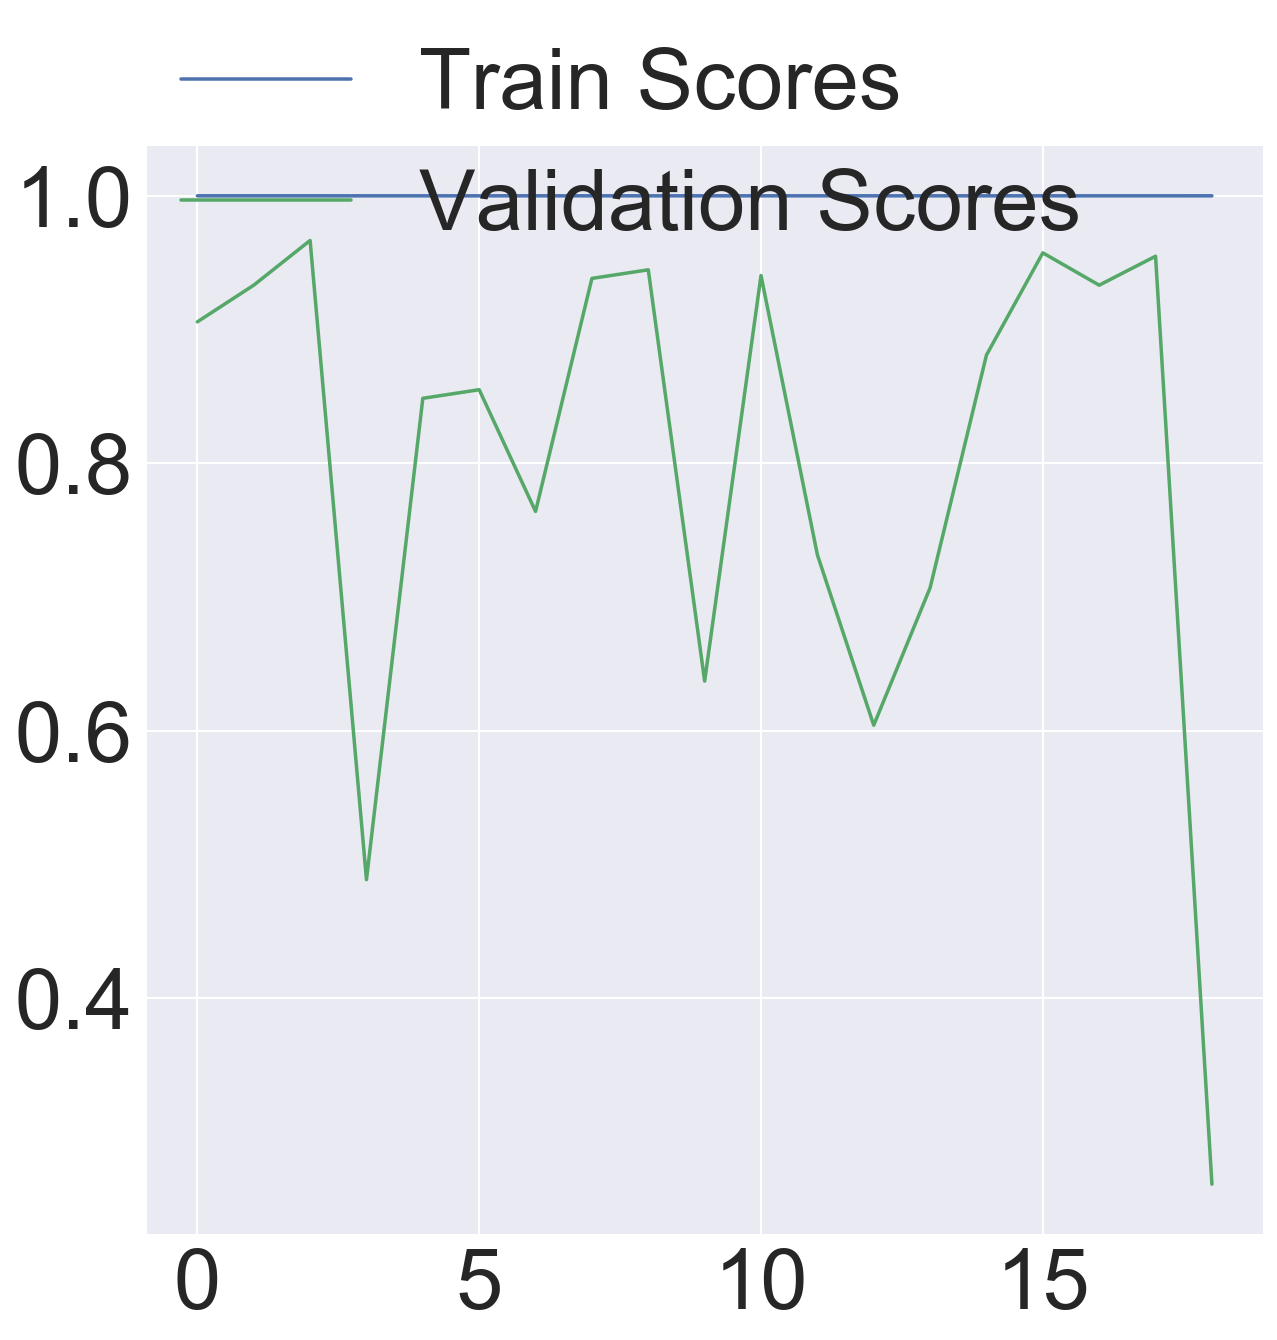

In [661]:
mean_training_score = sum(train_scores)/len(train_scores) 
print('Mean of Training Scores: \n', mean_training_score)
mean_val_score = sum(validation_scores)/len(validation_scores)
print('Mean of Validation Scores: \n', mean_val_score)

plt.figure(figsize=(10, 10))
plt.plot(train_scores, label="Train Scores")
plt.plot(validation_scores, label="Validation Scores")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=1,
           ncol=1, mode="expand", borderaxespad=0.)

In [662]:
#### Predicting for 2016 House Prices

test_x = test_data_1.drop('sale_price', axis=1)
test_y = test_data_1.sale_price

# Prediction for 2016 House Prices using the Linear Model

twenty_sixteen_pred_score = model_xgb.score(test_x, test_y)

print('Prediction Score for 2016: ', twenty_sixteen_pred_score)
pred_df, rmse, r2 = eval_model( model_xgb )

# View Few House Predictions
print(pred_df.head())

#### Predicting for 2017 House Prices

test_x = test_data_2.drop('sale_price', axis=1)
test_y = test_data_2.sale_price

# Prediction for 2016 House Prices using the Linear Model

twenty_seventeen_pred_score = model_xgb.score(test_x, test_y)

print('Prediction Score for 2017: ', twenty_seventeen_pred_score)
pred_df, rmse, r2 = eval_model( model_xgb )

# View Few House Predictions
print(pred_df.head())

Prediction Score for 2016:  0.6615150139862127
RMSE:  603157.8642776461  :  R Squared:  0.6615150139862127
          actual     predicted         resid
19498  1150000.0  4.598919e+05  690108.09375
30768   865000.0  7.542403e+05  110759.68750
6125   2267500.0  2.307700e+06  -40200.00000
28091   907500.0  6.914034e+05  216096.62500
61321   500000.0  4.227586e+05   77241.43750
Prediction Score for 2017:  0.7641208520547871
RMSE:  456871.526081644  :  R Squared:  0.7641208520547871
          actual     predicted        resid
95578   160000.0  4.973941e+05 -337394.0625
3725   3100000.0  3.036534e+06   63466.5000
44813   669500.0  6.354009e+05   34099.0625
15839  1300000.0  1.056576e+06  243424.1250
53811   575000.0  8.541932e+05 -279193.1875


# GBoost Model

In [663]:
 GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [664]:
train_scores = list()
validation_scores = list()


for d, i in zip(data_chunks, range(len(data_chunks))):
    x = d.drop('sale_price', axis=1)
    y = d.sale_price
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=10)
    
    reg_4 = GBoost.fit(x_train, y_train)
    train_score = reg_4.score(x_train, y_train)
    test_score = reg_4.score(x_test, y_test)
    test_score = reg_4.score(x_test, y_test)
    train_scores.append(train_score)
    validation_scores.append(test_score)
    print("Training and Test Scores for the {0} batch".format(i+1))
    print('Training_Score: ', train_score, '\n', 'Test Score: ', test_score)
    print('\n')

Training and Test Scores for the 1 batch
Training_Score:  0.7484551434796636 
 Test Score:  0.9903984780881157


Training and Test Scores for the 2 batch
Training_Score:  0.9396426318895419 
 Test Score:  0.8778793018512113


Training and Test Scores for the 3 batch
Training_Score:  0.9437011407155262 
 Test Score:  0.958617031906753


Training and Test Scores for the 4 batch
Training_Score:  0.3173297560110221 
 Test Score:  0.929383777823013


Training and Test Scores for the 5 batch
Training_Score:  0.7282498403635396 
 Test Score:  0.6960507718774525


Training and Test Scores for the 6 batch
Training_Score:  0.4677926627167337 
 Test Score:  0.9122589893076938


Training and Test Scores for the 7 batch
Training_Score:  0.8839881795933842 
 Test Score:  0.602354162601283


Training and Test Scores for the 8 batch
Training_Score:  0.8907949604132633 
 Test Score:  0.8774751997851049


Training and Test Scores for the 9 batch
Training_Score:  0.7900923647208347 
 Test Score:  0.98477

Mean of Training Scores: 
 0.8038915002960882
Mean of Validation Scores: 
 0.8467578723953405


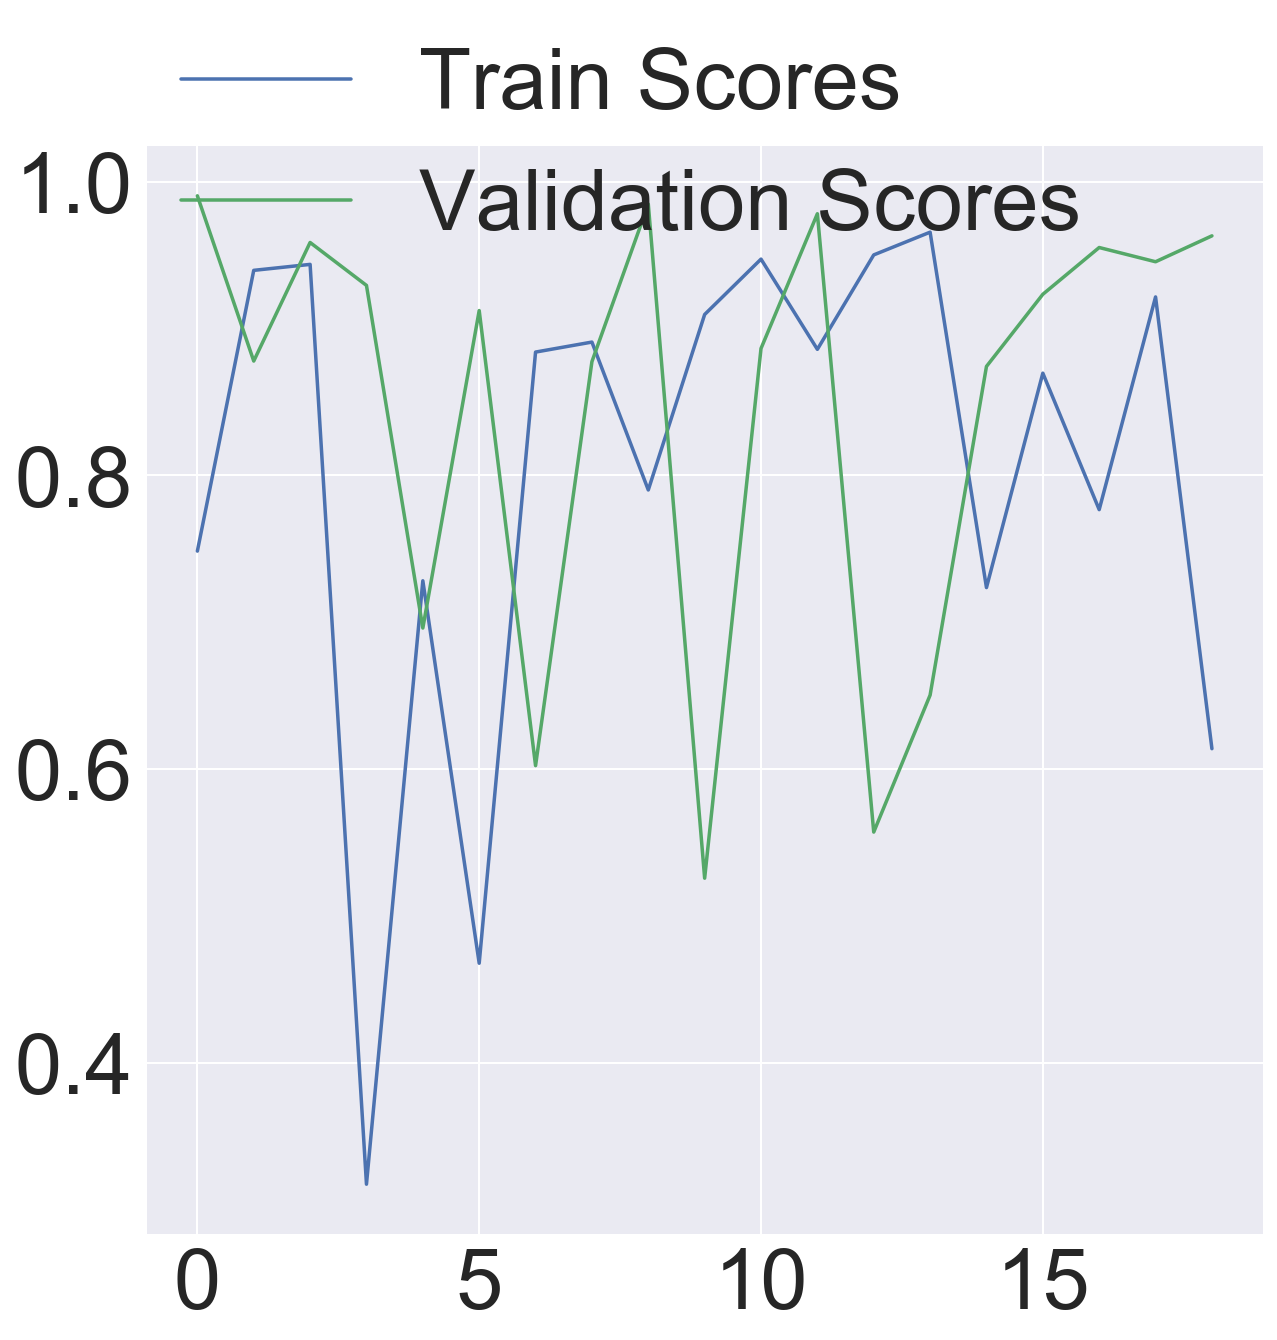

In [665]:
mean_training_score = sum(train_scores)/len(train_scores) 
print('Mean of Training Scores: \n', mean_training_score)
mean_val_score = sum(validation_scores)/len(validation_scores)
print('Mean of Validation Scores: \n', mean_val_score)

plt.figure(figsize=(10, 10))
plt.plot(train_scores, label="Train Scores")
plt.plot(validation_scores, label="Validation Scores")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=1,
           ncol=1, mode="expand", borderaxespad=0.)
plt.show()

In [666]:
#### Predicting for 2016 House Prices

test_x = test_data_1.drop('sale_price', axis=1)
test_y = test_data_1.sale_price

# Prediction for 2016 House Prices using the Linear Model

twenty_sixteen_pred_score = GBoost.score(test_x, test_y)

print('Prediction Score for 2016: ', twenty_sixteen_pred_score)
pred_df, rmse, r2 = eval_model( GBoost )

# View Few House Predictions
print(pred_df.head())

#### Predicting for 2017 House Prices

test_x = test_data_2.drop('sale_price', axis=1)
test_y = test_data_2.sale_price

# Prediction for 2016 House Prices using the Linear Model

twenty_seventeen_pred_score = GBoost.score(test_x, test_y)

print('Prediction Score for 2017: ', twenty_seventeen_pred_score)
pred_df, rmse, r2 = eval_model( GBoost )

# View Few House Predictions
print(pred_df.head())

Prediction Score for 2016:  0.558456346034589
RMSE:  688887.1971666381  :  R Squared:  0.558456346034589
          actual     predicted          resid
19498  1150000.0  1.084786e+06   65213.948130
30768   865000.0  8.120108e+05   52989.201103
6125   2267500.0  2.417662e+06 -150161.585633
28091   907500.0  8.408647e+05   66635.252520
61321   500000.0  4.427466e+05   57253.363411
Prediction Score for 2017:  0.6811760150281712
RMSE:  531159.3243038681  :  R Squared:  0.6811760150281712
          actual     predicted          resid
95578   160000.0  2.588151e+05  -98815.081122
3725   3100000.0  2.316173e+06  783827.247015
44813   669500.0  6.503229e+05   19177.054974
15839  1300000.0  1.241423e+06   58577.310944
53811   575000.0  6.518135e+05  -76813.478885
